In [1]:
# Check the GPU type

!nvidia-smi

Mon Jun 12 15:10:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3D:00.0 Off |                  N/A |
| 28%   33C    P8     8W / 250W |   5017MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math
from torch.utils.data import DataLoader
from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
import torchvision
import torchvision.datasets as dset
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

In [3]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [4]:
import ignite
from ignite.metrics import InceptionScore
from ignite.engine import Engine, Events

def eval_step(engine, batch):
    batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
    return batch


evaluator = Engine(eval_step)
inception_score = InceptionScore()
inception_score.attach(evaluator, "is")
eption_score = InceptionScore()

In [5]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, dropout_last=True):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if dropout_last else nn.Identity(),
            nn.ReLU(inplace=True),
        ], skip)


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        # Apply the conv layer to the input to get q, k and v
        q = self.query_conv(input)
        k = self.key_conv(input)
        v = self.value_conv(input)

        # Reshape q, k, v to make matrix multiplication possible
        b, c, h, w = input.shape
        q = q.view(b, -1, h*w).permute(0, 2, 1)
        k = k.view(b, -1, h*w)
        v = v.view(b, -1, h*w)

        # Calculate the attention map
        attention_map = self.softmax(torch.bmm(q, k))

        # Calculate the self-attention weighted value map
        out = torch.bmm(v, attention_map.permute(0, 2, 1))
        out = out.view(b, c, h, w)
        
        # Add the self-attention weighted output to the input
        out = self.gamma * out + input
        return out

class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        # The inputs to timestep_embed will approximately fall into the range
        # -10 to 10, so use std 0.2 for the Fourier Features.
        self.timestep_embed = FourierFeatures(1, 16, std=0.2)
        self.class_embed = nn.Embedding(10, 4)
        #self.self_attention = SelfAttention(c)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(19, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        nn.Upsample(scale_factor=2),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    nn.Upsample(scale_factor=2),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2),
                #self.self_attention,
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, dropout_last=False),
        )

    def forward(self, input, log_snrs):
        timestep_embed = expand_to_planes(self.timestep_embed(log_snrs[:, None]), input.shape)

        # Remove class_embed and cond usage
        # class_embed = expand_to_planes(self.class_embed(cond), input.shape)

        # Update the input to the self.net by removing class_embed from the concatenation
        return self.net(torch.cat([input, timestep_embed], dim=1))


In [6]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(log_snrs):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given the log SNR for a timestep."""
    return log_snrs.sigmoid().sqrt(), log_snrs.neg().sigmoid().sqrt()


def get_ddpm_schedule(t):
    """Returns log SNRs for the noise schedule from the DDPM paper."""
    return -torch.special.expm1(1e-4 + 10 * t**2).log()


@torch.no_grad()
def sample(model, x, steps, eta):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * log_snrs[i]).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred


The noise schedule:


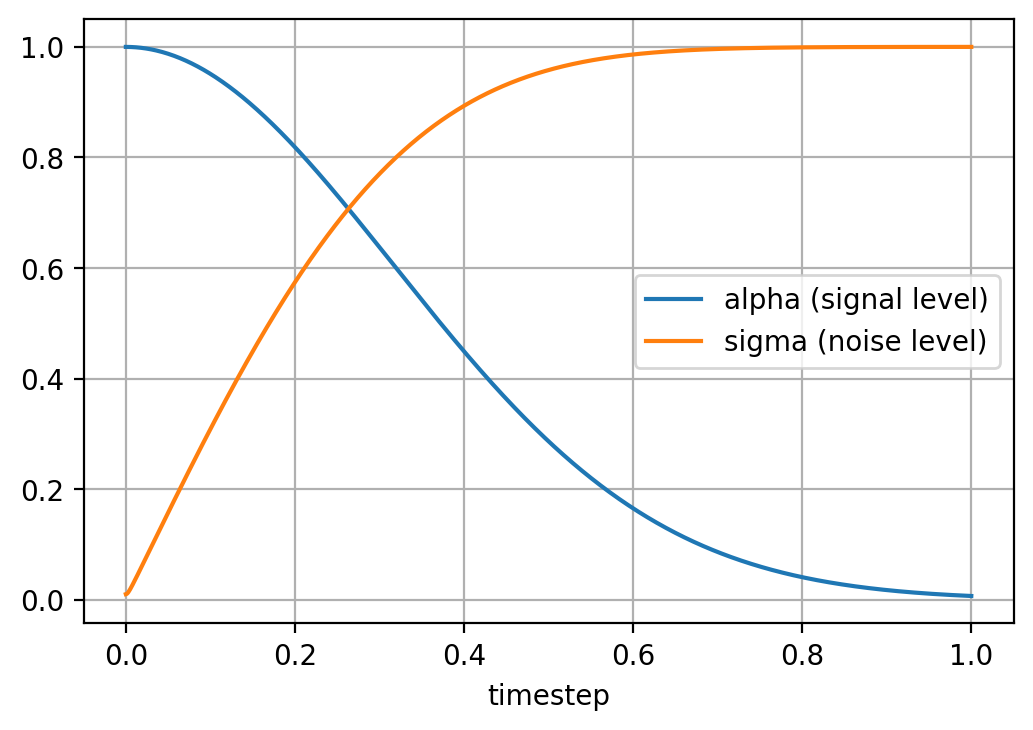

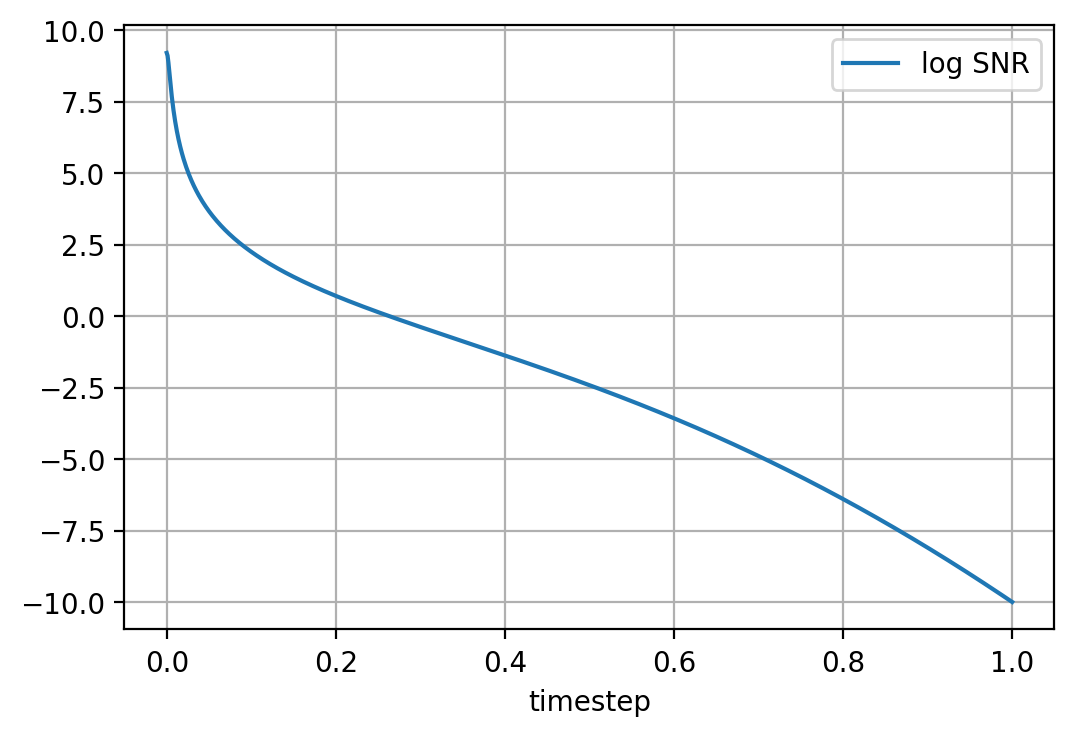

In [7]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
log_snrs_vis = get_ddpm_schedule(t_vis)
alphas_vis, sigmas_vis = get_alphas_sigmas(log_snrs_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()

plt.plot(t_vis, log_snrs_vis, label='log SNR')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [10]:
from torch.utils.data import Dataset
from PIL import Image
import glob

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.list_of_files = glob.glob(root_dir + '/*.jpg')

    def __len__(self):
        return len(self.list_of_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.list_of_files[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image

In [11]:
from torch.utils.data import Dataset, DataLoader, random_split

transform = transforms.Compose(
    [transforms.CenterCrop(178),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

# processing 4 images at once. *adjustable*
batch_size = 128

# set trainset: loading CIFAR-10, apply previously defined transform function
dataset = CelebADataset(root_dir='./data/img_align_celeba', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Create DataLoader for the training and validation sets
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

In [12]:
# Create the model and optimizer

seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 23213956



Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 0, loss: 0.223164
Epoch 0


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 0, iteration: 0, loss: 0.218497
Epoch: 0, iteration: 50, loss: 0.114142
Epoch: 0, iteration: 100, loss: 0.0762898
Epoch: 0, iteration: 150, loss: 0.0594099
Epoch: 0, iteration: 200, loss: 0.0620368
Epoch: 0, iteration: 250, loss: 0.0573514
Epoch: 0, iteration: 300, loss: 0.0604043
Epoch: 0, iteration: 350, loss: 0.0474706
Epoch: 0, iteration: 400, loss: 0.0548965
Epoch: 0, iteration: 450, loss: 0.0463906
Epoch: 0, iteration: 500, loss: 0.0556063
Epoch: 0, iteration: 550, loss: 0.0443794
Epoch: 0, iteration: 600, loss: 0.0505256
Epoch: 0, iteration: 650, loss: 0.047171
Epoch: 0, iteration: 700, loss: 0.0510317
Epoch 1


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1, iteration: 0, loss: 0.0414146
Epoch: 1, iteration: 50, loss: 0.0456752
Epoch: 1, iteration: 100, loss: 0.0438542
Epoch: 1, iteration: 150, loss: 0.0504594
Epoch: 1, iteration: 200, loss: 0.0400292
Epoch: 1, iteration: 250, loss: 0.0425059
Epoch: 1, iteration: 300, loss: 0.0387024
Epoch: 1, iteration: 350, loss: 0.0487347
Epoch: 1, iteration: 400, loss: 0.0353946
Epoch: 1, iteration: 450, loss: 0.0433016
Epoch: 1, iteration: 500, loss: 0.0376634
Epoch: 1, iteration: 550, loss: 0.045427
Epoch: 1, iteration: 600, loss: 0.0378495
Epoch: 1, iteration: 650, loss: 0.0413893
Epoch: 1, iteration: 700, loss: 0.0399329
Epoch 2


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2, iteration: 0, loss: 0.0436715
Epoch: 2, iteration: 50, loss: 0.0367919
Epoch: 2, iteration: 100, loss: 0.0449432
Epoch: 2, iteration: 150, loss: 0.0401355
Epoch: 2, iteration: 200, loss: 0.0418576
Epoch: 2, iteration: 250, loss: 0.0373624
Epoch: 2, iteration: 300, loss: 0.0383206
Epoch: 2, iteration: 350, loss: 0.0393208
Epoch: 2, iteration: 400, loss: 0.0425808
Epoch: 2, iteration: 450, loss: 0.0352007
Epoch: 2, iteration: 500, loss: 0.0397936
Epoch: 2, iteration: 550, loss: 0.040841
Epoch: 2, iteration: 600, loss: 0.0407992
Epoch: 2, iteration: 650, loss: 0.0332249
Epoch: 2, iteration: 700, loss: 0.0402627
Epoch 3


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3, iteration: 0, loss: 0.0380551
Epoch: 3, iteration: 50, loss: 0.0425602
Epoch: 3, iteration: 100, loss: 0.0368394
Epoch: 3, iteration: 150, loss: 0.0382551
Epoch: 3, iteration: 200, loss: 0.0347463
Epoch: 3, iteration: 250, loss: 0.0428547
Epoch: 3, iteration: 300, loss: 0.0355609
Epoch: 3, iteration: 350, loss: 0.0394826
Epoch: 3, iteration: 400, loss: 0.034431
Epoch: 3, iteration: 450, loss: 0.0420819
Epoch: 3, iteration: 500, loss: 0.0314648
Epoch: 3, iteration: 550, loss: 0.0406831
Epoch: 3, iteration: 600, loss: 0.0333622
Epoch: 3, iteration: 650, loss: 0.0421464
Epoch: 3, iteration: 700, loss: 0.0333188
Epoch 4


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4, iteration: 0, loss: 0.0381797
Epoch: 4, iteration: 50, loss: 0.0340826
Epoch: 4, iteration: 100, loss: 0.0379379
Epoch: 4, iteration: 150, loss: 0.033268
Epoch: 4, iteration: 200, loss: 0.0400776
Epoch: 4, iteration: 250, loss: 0.0363471
Epoch: 4, iteration: 300, loss: 0.0387172
Epoch: 4, iteration: 350, loss: 0.0332614
Epoch: 4, iteration: 400, loss: 0.0357984
Epoch: 4, iteration: 450, loss: 0.0334818
Epoch: 4, iteration: 500, loss: 0.0430064
Epoch: 4, iteration: 550, loss: 0.0301172
Epoch: 4, iteration: 600, loss: 0.0390177
Epoch: 4, iteration: 650, loss: 0.0321666
Epoch: 4, iteration: 700, loss: 0.0398313

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 5, loss: 0.0331798
Epoch 5


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5, iteration: 0, loss: 0.0316422
Epoch: 5, iteration: 50, loss: 0.0404024
Epoch: 5, iteration: 100, loss: 0.0318002
Epoch: 5, iteration: 150, loss: 0.0435692
Epoch: 5, iteration: 200, loss: 0.0321041
Epoch: 5, iteration: 250, loss: 0.0358678
Epoch: 5, iteration: 300, loss: 0.0339263
Epoch: 5, iteration: 350, loss: 0.0432911
Epoch: 5, iteration: 400, loss: 0.0337574
Epoch: 5, iteration: 450, loss: 0.0428062
Epoch: 5, iteration: 500, loss: 0.0354934
Epoch: 5, iteration: 550, loss: 0.0381731
Epoch: 5, iteration: 600, loss: 0.0318592
Epoch: 5, iteration: 650, loss: 0.0337774
Epoch: 5, iteration: 700, loss: 0.0333526
Epoch 6


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6, iteration: 0, loss: 0.0378213
Epoch: 6, iteration: 50, loss: 0.0312752
Epoch: 6, iteration: 100, loss: 0.0367214
Epoch: 6, iteration: 150, loss: 0.0322024
Epoch: 6, iteration: 200, loss: 0.036733
Epoch: 6, iteration: 250, loss: 0.0319709
Epoch: 6, iteration: 300, loss: 0.036895
Epoch: 6, iteration: 350, loss: 0.0331414
Epoch: 6, iteration: 400, loss: 0.041986
Epoch: 6, iteration: 450, loss: 0.0310995
Epoch: 6, iteration: 500, loss: 0.0353508
Epoch: 6, iteration: 550, loss: 0.0352099
Epoch: 6, iteration: 600, loss: 0.0362697
Epoch: 6, iteration: 650, loss: 0.0341887
Epoch: 6, iteration: 700, loss: 0.0395349
Epoch 7


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7, iteration: 0, loss: 0.0336117
Epoch: 7, iteration: 50, loss: 0.0437534
Epoch: 7, iteration: 100, loss: 0.0314499
Epoch: 7, iteration: 150, loss: 0.032321
Epoch: 7, iteration: 200, loss: 0.0337575
Epoch: 7, iteration: 250, loss: 0.0365496
Epoch: 7, iteration: 300, loss: 0.0305511
Epoch: 7, iteration: 350, loss: 0.0322954
Epoch: 7, iteration: 400, loss: 0.0303943
Epoch: 7, iteration: 450, loss: 0.03924
Epoch: 7, iteration: 500, loss: 0.0295827
Epoch: 7, iteration: 550, loss: 0.0326368
Epoch: 7, iteration: 600, loss: 0.030869
Epoch: 7, iteration: 650, loss: 0.0367065
Epoch: 7, iteration: 700, loss: 0.0340827
Epoch 8


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 8, iteration: 0, loss: 0.0352785
Epoch: 8, iteration: 50, loss: 0.0342389
Epoch: 8, iteration: 100, loss: 0.0354091
Epoch: 8, iteration: 150, loss: 0.0327371
Epoch: 8, iteration: 200, loss: 0.0330536
Epoch: 8, iteration: 250, loss: 0.0316622
Epoch: 8, iteration: 300, loss: 0.0387433
Epoch: 8, iteration: 350, loss: 0.0296175
Epoch: 8, iteration: 400, loss: 0.0342315
Epoch: 8, iteration: 450, loss: 0.0299452
Epoch: 8, iteration: 500, loss: 0.0392587
Epoch: 8, iteration: 550, loss: 0.0279458
Epoch: 8, iteration: 600, loss: 0.0357928
Epoch: 8, iteration: 650, loss: 0.03216
Epoch: 8, iteration: 700, loss: 0.0335931
Epoch 9


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 9, iteration: 0, loss: 0.0304841
Epoch: 9, iteration: 50, loss: 0.035556
Epoch: 9, iteration: 100, loss: 0.0308738
Epoch: 9, iteration: 150, loss: 0.0373288
Epoch: 9, iteration: 200, loss: 0.0329567
Epoch: 9, iteration: 250, loss: 0.0346032
Epoch: 9, iteration: 300, loss: 0.0306958
Epoch: 9, iteration: 350, loss: 0.0372541
Epoch: 9, iteration: 400, loss: 0.0282413
Epoch: 9, iteration: 450, loss: 0.0332037
Epoch: 9, iteration: 500, loss: 0.0312843
Epoch: 9, iteration: 550, loss: 0.0396988
Epoch: 9, iteration: 600, loss: 0.0289694
Epoch: 9, iteration: 650, loss: 0.034243
Epoch: 9, iteration: 700, loss: 0.0350636

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 10, loss: 0.0310497
Epoch 10


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 10, iteration: 0, loss: 0.03684
Epoch: 10, iteration: 50, loss: 0.0294607
Epoch: 10, iteration: 100, loss: 0.0307472
Epoch: 10, iteration: 150, loss: 0.0325213
Epoch: 10, iteration: 200, loss: 0.0378989
Epoch: 10, iteration: 250, loss: 0.0299734
Epoch: 10, iteration: 300, loss: 0.0359993
Epoch: 10, iteration: 350, loss: 0.0305463
Epoch: 10, iteration: 400, loss: 0.0367375
Epoch: 10, iteration: 450, loss: 0.0311494
Epoch: 10, iteration: 500, loss: 0.0330095
Epoch: 10, iteration: 550, loss: 0.0314287
Epoch: 10, iteration: 600, loss: 0.0389707
Epoch: 10, iteration: 650, loss: 0.0287688
Epoch: 10, iteration: 700, loss: 0.0319697
Epoch 11


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 11, iteration: 0, loss: 0.0284611
Epoch: 11, iteration: 50, loss: 0.0363993
Epoch: 11, iteration: 100, loss: 0.0301458
Epoch: 11, iteration: 150, loss: 0.0309994
Epoch: 11, iteration: 200, loss: 0.0330076
Epoch: 11, iteration: 250, loss: 0.0394105
Epoch: 11, iteration: 300, loss: 0.0292071
Epoch: 11, iteration: 350, loss: 0.0350505
Epoch: 11, iteration: 400, loss: 0.0320133
Epoch: 11, iteration: 450, loss: 0.0341521
Epoch: 11, iteration: 500, loss: 0.0297995
Epoch: 11, iteration: 550, loss: 0.0326294
Epoch: 11, iteration: 600, loss: 0.031946
Epoch: 11, iteration: 650, loss: 0.0344011
Epoch: 11, iteration: 700, loss: 0.0285283
Epoch 12


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 12, iteration: 0, loss: 0.0341269
Epoch: 12, iteration: 50, loss: 0.0321799
Epoch: 12, iteration: 100, loss: 0.0345486
Epoch: 12, iteration: 150, loss: 0.029625
Epoch: 12, iteration: 200, loss: 0.0337445
Epoch: 12, iteration: 250, loss: 0.028308
Epoch: 12, iteration: 300, loss: 0.0401092
Epoch: 12, iteration: 350, loss: 0.028195
Epoch: 12, iteration: 400, loss: 0.033902
Epoch: 12, iteration: 450, loss: 0.0317936
Epoch: 12, iteration: 500, loss: 0.037568
Epoch: 12, iteration: 550, loss: 0.0291948
Epoch: 12, iteration: 600, loss: 0.0319834
Epoch: 12, iteration: 650, loss: 0.0321562
Epoch: 12, iteration: 700, loss: 0.0341578
Epoch 13


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 13, iteration: 0, loss: 0.028577
Epoch: 13, iteration: 50, loss: 0.0341439
Epoch: 13, iteration: 100, loss: 0.0308334
Epoch: 13, iteration: 150, loss: 0.0355781
Epoch: 13, iteration: 200, loss: 0.0293229
Epoch: 13, iteration: 250, loss: 0.0305527
Epoch: 13, iteration: 300, loss: 0.0287241
Epoch: 13, iteration: 350, loss: 0.0367744
Epoch: 13, iteration: 400, loss: 0.0271531
Epoch: 13, iteration: 450, loss: 0.0335225
Epoch: 13, iteration: 500, loss: 0.0292054
Epoch: 13, iteration: 550, loss: 0.0374218
Epoch: 13, iteration: 600, loss: 0.0294607
Epoch: 13, iteration: 650, loss: 0.0332979
Epoch: 13, iteration: 700, loss: 0.0300707
Epoch 14


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 14, iteration: 0, loss: 0.0379748
Epoch: 14, iteration: 50, loss: 0.0314793
Epoch: 14, iteration: 100, loss: 0.034152
Epoch: 14, iteration: 150, loss: 0.031271
Epoch: 14, iteration: 200, loss: 0.0340053
Epoch: 14, iteration: 250, loss: 0.0324516
Epoch: 14, iteration: 300, loss: 0.0341253
Epoch: 14, iteration: 350, loss: 0.0297373
Epoch: 14, iteration: 400, loss: 0.0373286
Epoch: 14, iteration: 450, loss: 0.0286811
Epoch: 14, iteration: 500, loss: 0.0341766
Epoch: 14, iteration: 550, loss: 0.0297683
Epoch: 14, iteration: 600, loss: 0.0345076
Epoch: 14, iteration: 650, loss: 0.0287695
Epoch: 14, iteration: 700, loss: 0.0330237

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 15, loss: 0.0300578
Epoch 15


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 15, iteration: 0, loss: 0.0286666
Epoch: 15, iteration: 50, loss: 0.0343687
Epoch: 15, iteration: 100, loss: 0.0312798
Epoch: 15, iteration: 150, loss: 0.0347413
Epoch: 15, iteration: 200, loss: 0.0316901
Epoch: 15, iteration: 250, loss: 0.0361055
Epoch: 15, iteration: 300, loss: 0.0288691
Epoch: 15, iteration: 350, loss: 0.0342256
Epoch: 15, iteration: 400, loss: 0.0315666
Epoch: 15, iteration: 450, loss: 0.0359843
Epoch: 15, iteration: 500, loss: 0.0271531
Epoch: 15, iteration: 550, loss: 0.0346577
Epoch: 15, iteration: 600, loss: 0.0300217
Epoch: 15, iteration: 650, loss: 0.0339134
Epoch: 15, iteration: 700, loss: 0.0286915
Epoch 16


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 16, iteration: 0, loss: 0.0322122
Epoch: 16, iteration: 50, loss: 0.0285403
Epoch: 16, iteration: 100, loss: 0.0363478
Epoch: 16, iteration: 150, loss: 0.0308521
Epoch: 16, iteration: 200, loss: 0.0311667
Epoch: 16, iteration: 250, loss: 0.0302164
Epoch: 16, iteration: 300, loss: 0.0368348
Epoch: 16, iteration: 350, loss: 0.0275674
Epoch: 16, iteration: 400, loss: 0.0305332
Epoch: 16, iteration: 450, loss: 0.0267203
Epoch: 16, iteration: 500, loss: 0.0348337
Epoch: 16, iteration: 550, loss: 0.029832
Epoch: 16, iteration: 600, loss: 0.0332884
Epoch: 16, iteration: 650, loss: 0.0304812
Epoch: 16, iteration: 700, loss: 0.0355738
Epoch 17


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 17, iteration: 0, loss: 0.0288442
Epoch: 17, iteration: 50, loss: 0.0292202
Epoch: 17, iteration: 100, loss: 0.0308389
Epoch: 17, iteration: 150, loss: 0.0337945
Epoch: 17, iteration: 200, loss: 0.0282466
Epoch: 17, iteration: 250, loss: 0.0326611
Epoch: 17, iteration: 300, loss: 0.0317011
Epoch: 17, iteration: 350, loss: 0.035941
Epoch: 17, iteration: 400, loss: 0.0287658
Epoch: 17, iteration: 450, loss: 0.0313302
Epoch: 17, iteration: 500, loss: 0.0287938
Epoch: 17, iteration: 550, loss: 0.033145
Epoch: 17, iteration: 600, loss: 0.0288626
Epoch: 17, iteration: 650, loss: 0.0328963
Epoch: 17, iteration: 700, loss: 0.0309774
Epoch 18


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 18, iteration: 0, loss: 0.0337909
Epoch: 18, iteration: 50, loss: 0.0281485
Epoch: 18, iteration: 100, loss: 0.0322935
Epoch: 18, iteration: 150, loss: 0.0314046
Epoch: 18, iteration: 200, loss: 0.0371558
Epoch: 18, iteration: 250, loss: 0.0290166
Epoch: 18, iteration: 300, loss: 0.033996
Epoch: 18, iteration: 350, loss: 0.0305959
Epoch: 18, iteration: 400, loss: 0.0361316
Epoch: 18, iteration: 450, loss: 0.0263266
Epoch: 18, iteration: 500, loss: 0.0345425
Epoch: 18, iteration: 550, loss: 0.0305278
Epoch: 18, iteration: 600, loss: 0.0368218
Epoch: 18, iteration: 650, loss: 0.02824
Epoch: 18, iteration: 700, loss: 0.0321425
Epoch 19


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 19, iteration: 0, loss: 0.0266977
Epoch: 19, iteration: 50, loss: 0.036988
Epoch: 19, iteration: 100, loss: 0.0277086
Epoch: 19, iteration: 150, loss: 0.0329508
Epoch: 19, iteration: 200, loss: 0.0294728
Epoch: 19, iteration: 250, loss: 0.0340471
Epoch: 19, iteration: 300, loss: 0.0261891
Epoch: 19, iteration: 350, loss: 0.0331986
Epoch: 19, iteration: 400, loss: 0.0286395
Epoch: 19, iteration: 450, loss: 0.0351907
Epoch: 19, iteration: 500, loss: 0.028106
Epoch: 19, iteration: 550, loss: 0.0310226
Epoch: 19, iteration: 600, loss: 0.0300367
Epoch: 19, iteration: 650, loss: 0.0375667
Epoch: 19, iteration: 700, loss: 0.0320338

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 20, loss: 0.0295324
Epoch 20


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 20, iteration: 0, loss: 0.0301637
Epoch: 20, iteration: 50, loss: 0.0307371
Epoch: 20, iteration: 100, loss: 0.0323436
Epoch: 20, iteration: 150, loss: 0.0269157
Epoch: 20, iteration: 200, loss: 0.0348316
Epoch: 20, iteration: 250, loss: 0.028649
Epoch: 20, iteration: 300, loss: 0.0380718
Epoch: 20, iteration: 350, loss: 0.0280561
Epoch: 20, iteration: 400, loss: 0.0318146
Epoch: 20, iteration: 450, loss: 0.0297569
Epoch: 20, iteration: 500, loss: 0.0322596
Epoch: 20, iteration: 550, loss: 0.0293746
Epoch: 20, iteration: 600, loss: 0.0337049
Epoch: 20, iteration: 650, loss: 0.0290247
Epoch: 20, iteration: 700, loss: 0.0365106
Epoch 21


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 21, iteration: 0, loss: 0.029376
Epoch: 21, iteration: 50, loss: 0.0322183
Epoch: 21, iteration: 100, loss: 0.0293416
Epoch: 21, iteration: 150, loss: 0.0329653
Epoch: 21, iteration: 200, loss: 0.0256136
Epoch: 21, iteration: 250, loss: 0.0322665
Epoch: 21, iteration: 300, loss: 0.0291843
Epoch: 21, iteration: 350, loss: 0.0343046
Epoch: 21, iteration: 400, loss: 0.0277747
Epoch: 21, iteration: 450, loss: 0.030602
Epoch: 21, iteration: 500, loss: 0.0318424
Epoch: 21, iteration: 550, loss: 0.0330269
Epoch: 21, iteration: 600, loss: 0.0274748
Epoch: 21, iteration: 650, loss: 0.0259948
Epoch: 21, iteration: 700, loss: 0.0284126
Epoch 22


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 22, iteration: 0, loss: 0.0346497
Epoch: 22, iteration: 50, loss: 0.0257946
Epoch: 22, iteration: 100, loss: 0.0326509
Epoch: 22, iteration: 150, loss: 0.0305347
Epoch: 22, iteration: 200, loss: 0.0324242
Epoch: 22, iteration: 250, loss: 0.0294926
Epoch: 22, iteration: 300, loss: 0.0331967
Epoch: 22, iteration: 350, loss: 0.0286564
Epoch: 22, iteration: 400, loss: 0.0336452
Epoch: 22, iteration: 450, loss: 0.0268031
Epoch: 22, iteration: 500, loss: 0.0328875
Epoch: 22, iteration: 550, loss: 0.029739
Epoch: 22, iteration: 600, loss: 0.0341401
Epoch: 22, iteration: 650, loss: 0.0280498
Epoch: 22, iteration: 700, loss: 0.0312669
Epoch 23


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 23, iteration: 0, loss: 0.0323444
Epoch: 23, iteration: 50, loss: 0.0342559
Epoch: 23, iteration: 100, loss: 0.0272333
Epoch: 23, iteration: 150, loss: 0.031083
Epoch: 23, iteration: 200, loss: 0.031679
Epoch: 23, iteration: 250, loss: 0.0348021
Epoch: 23, iteration: 300, loss: 0.0270627
Epoch: 23, iteration: 350, loss: 0.0319475
Epoch: 23, iteration: 400, loss: 0.0293816
Epoch: 23, iteration: 450, loss: 0.0360378
Epoch: 23, iteration: 500, loss: 0.0259984
Epoch: 23, iteration: 550, loss: 0.0321861
Epoch: 23, iteration: 600, loss: 0.0287086
Epoch: 23, iteration: 650, loss: 0.0331864
Epoch: 23, iteration: 700, loss: 0.0272159
Epoch 24


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 24, iteration: 0, loss: 0.0324375
Epoch: 24, iteration: 50, loss: 0.0271633
Epoch: 24, iteration: 100, loss: 0.0363597
Epoch: 24, iteration: 150, loss: 0.0305876
Epoch: 24, iteration: 200, loss: 0.0309939
Epoch: 24, iteration: 250, loss: 0.0275769
Epoch: 24, iteration: 300, loss: 0.0326213
Epoch: 24, iteration: 350, loss: 0.0296942
Epoch: 24, iteration: 400, loss: 0.0342917
Epoch: 24, iteration: 450, loss: 0.0283971
Epoch: 24, iteration: 500, loss: 0.0363196
Epoch: 24, iteration: 550, loss: 0.0282559
Epoch: 24, iteration: 600, loss: 0.030837
Epoch: 24, iteration: 650, loss: 0.0325812
Epoch: 24, iteration: 700, loss: 0.0350963

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 25, loss: 0.0289391
Epoch 25


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 25, iteration: 0, loss: 0.0259711
Epoch: 25, iteration: 50, loss: 0.0344362
Epoch: 25, iteration: 100, loss: 0.0286656
Epoch: 25, iteration: 150, loss: 0.0357732
Epoch: 25, iteration: 200, loss: 0.025217
Epoch: 25, iteration: 250, loss: 0.0322904
Epoch: 25, iteration: 300, loss: 0.028917
Epoch: 25, iteration: 350, loss: 0.0330605
Epoch: 25, iteration: 400, loss: 0.0294433
Epoch: 25, iteration: 450, loss: 0.0329953
Epoch: 25, iteration: 500, loss: 0.0281378
Epoch: 25, iteration: 550, loss: 0.0311751
Epoch: 25, iteration: 600, loss: 0.0254594
Epoch: 25, iteration: 650, loss: 0.0295443
Epoch: 25, iteration: 700, loss: 0.0272285
Epoch 26


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 26, iteration: 0, loss: 0.0327511
Epoch: 26, iteration: 50, loss: 0.0286392
Epoch: 26, iteration: 100, loss: 0.0280009
Epoch: 26, iteration: 150, loss: 0.028748
Epoch: 26, iteration: 200, loss: 0.0363565
Epoch: 26, iteration: 250, loss: 0.0265436
Epoch: 26, iteration: 300, loss: 0.0308799
Epoch: 26, iteration: 350, loss: 0.0271513
Epoch: 26, iteration: 400, loss: 0.0341268
Epoch: 26, iteration: 450, loss: 0.0296907
Epoch: 26, iteration: 500, loss: 0.0330102
Epoch: 26, iteration: 550, loss: 0.0257362
Epoch: 26, iteration: 600, loss: 0.0357925
Epoch: 26, iteration: 650, loss: 0.0275705
Epoch: 26, iteration: 700, loss: 0.0345431
Epoch 27


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 27, iteration: 0, loss: 0.0287019
Epoch: 27, iteration: 50, loss: 0.0374061
Epoch: 27, iteration: 100, loss: 0.028205
Epoch: 27, iteration: 150, loss: 0.0314855
Epoch: 27, iteration: 200, loss: 0.0294783
Epoch: 27, iteration: 250, loss: 0.0366804
Epoch: 27, iteration: 300, loss: 0.0275726
Epoch: 27, iteration: 350, loss: 0.0317115
Epoch: 27, iteration: 400, loss: 0.0291647
Epoch: 27, iteration: 450, loss: 0.0319128
Epoch: 27, iteration: 500, loss: 0.0270635
Epoch: 27, iteration: 550, loss: 0.0319754
Epoch: 27, iteration: 600, loss: 0.0276559
Epoch: 27, iteration: 650, loss: 0.0351705
Epoch: 27, iteration: 700, loss: 0.0283789
Epoch 28


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 28, iteration: 0, loss: 0.0272544
Epoch: 28, iteration: 50, loss: 0.0280162
Epoch: 28, iteration: 100, loss: 0.035062
Epoch: 28, iteration: 150, loss: 0.0283405
Epoch: 28, iteration: 200, loss: 0.0316178
Epoch: 28, iteration: 250, loss: 0.0293947
Epoch: 28, iteration: 300, loss: 0.0359908
Epoch: 28, iteration: 350, loss: 0.0243208
Epoch: 28, iteration: 400, loss: 0.0318046
Epoch: 28, iteration: 450, loss: 0.0315448
Epoch: 28, iteration: 500, loss: 0.0350968
Epoch: 28, iteration: 550, loss: 0.0262145
Epoch: 28, iteration: 600, loss: 0.0322674
Epoch: 28, iteration: 650, loss: 0.0293547
Epoch: 28, iteration: 700, loss: 0.0359751
Epoch 29


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 29, iteration: 0, loss: 0.028165
Epoch: 29, iteration: 50, loss: 0.0310588
Epoch: 29, iteration: 100, loss: 0.0310492
Epoch: 29, iteration: 150, loss: 0.0344681
Epoch: 29, iteration: 200, loss: 0.0260929
Epoch: 29, iteration: 250, loss: 0.0322191
Epoch: 29, iteration: 300, loss: 0.0275003
Epoch: 29, iteration: 350, loss: 0.0322472
Epoch: 29, iteration: 400, loss: 0.027343
Epoch: 29, iteration: 450, loss: 0.0350284
Epoch: 29, iteration: 500, loss: 0.031927
Epoch: 29, iteration: 550, loss: 0.0354833
Epoch: 29, iteration: 600, loss: 0.0269512
Epoch: 29, iteration: 650, loss: 0.0287077
Epoch: 29, iteration: 700, loss: 0.0273582

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 30, loss: 0.0286809
Epoch 30


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 30, iteration: 0, loss: 0.0372682
Epoch: 30, iteration: 50, loss: 0.0316919
Epoch: 30, iteration: 100, loss: 0.0298178
Epoch: 30, iteration: 150, loss: 0.0297049
Epoch: 30, iteration: 200, loss: 0.032977
Epoch: 30, iteration: 250, loss: 0.0270539
Epoch: 30, iteration: 300, loss: 0.0289614
Epoch: 30, iteration: 350, loss: 0.027539
Epoch: 30, iteration: 400, loss: 0.0357029
Epoch: 30, iteration: 450, loss: 0.029717
Epoch: 30, iteration: 500, loss: 0.0296791
Epoch: 30, iteration: 550, loss: 0.0285424
Epoch: 30, iteration: 600, loss: 0.0340366
Epoch: 30, iteration: 650, loss: 0.0269234
Epoch: 30, iteration: 700, loss: 0.0319231
Epoch 31


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 31, iteration: 0, loss: 0.0306694
Epoch: 31, iteration: 50, loss: 0.0347182
Epoch: 31, iteration: 100, loss: 0.0275108
Epoch: 31, iteration: 150, loss: 0.0293148
Epoch: 31, iteration: 200, loss: 0.0296857
Epoch: 31, iteration: 250, loss: 0.0330417
Epoch: 31, iteration: 300, loss: 0.0280864
Epoch: 31, iteration: 350, loss: 0.0285384
Epoch: 31, iteration: 400, loss: 0.0290164
Epoch: 31, iteration: 450, loss: 0.0364314
Epoch: 31, iteration: 500, loss: 0.0274363
Epoch: 31, iteration: 550, loss: 0.032607
Epoch: 31, iteration: 600, loss: 0.0307834
Epoch: 31, iteration: 650, loss: 0.0351115
Epoch: 31, iteration: 700, loss: 0.0263929
Epoch 32


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 32, iteration: 0, loss: 0.0318605
Epoch: 32, iteration: 50, loss: 0.0286376
Epoch: 32, iteration: 100, loss: 0.0327096
Epoch: 32, iteration: 150, loss: 0.0268081
Epoch: 32, iteration: 200, loss: 0.0281706
Epoch: 32, iteration: 250, loss: 0.029664
Epoch: 32, iteration: 300, loss: 0.034614
Epoch: 32, iteration: 350, loss: 0.0272653
Epoch: 32, iteration: 400, loss: 0.0310548
Epoch: 32, iteration: 450, loss: 0.0318313
Epoch: 32, iteration: 500, loss: 0.0347584
Epoch: 32, iteration: 550, loss: 0.0257049
Epoch: 32, iteration: 600, loss: 0.0314887
Epoch: 32, iteration: 650, loss: 0.0288726
Epoch: 32, iteration: 700, loss: 0.0348222
Epoch 33


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 33, iteration: 0, loss: 0.0285127
Epoch: 33, iteration: 50, loss: 0.0307458
Epoch: 33, iteration: 100, loss: 0.0313329
Epoch: 33, iteration: 150, loss: 0.0350067
Epoch: 33, iteration: 200, loss: 0.0269649
Epoch: 33, iteration: 250, loss: 0.0292541
Epoch: 33, iteration: 300, loss: 0.0296619
Epoch: 33, iteration: 350, loss: 0.0362435
Epoch: 33, iteration: 400, loss: 0.0298489
Epoch: 33, iteration: 450, loss: 0.0296656
Epoch: 33, iteration: 500, loss: 0.0311597
Epoch: 33, iteration: 550, loss: 0.0360242
Epoch: 33, iteration: 600, loss: 0.0302384
Epoch: 33, iteration: 650, loss: 0.0303495
Epoch: 33, iteration: 700, loss: 0.0305064
Epoch 34


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 34, iteration: 0, loss: 0.0351351
Epoch: 34, iteration: 50, loss: 0.0253114
Epoch: 34, iteration: 100, loss: 0.0304162
Epoch: 34, iteration: 150, loss: 0.0264889
Epoch: 34, iteration: 200, loss: 0.0338362
Epoch: 34, iteration: 250, loss: 0.0300016
Epoch: 34, iteration: 300, loss: 0.0313748
Epoch: 34, iteration: 350, loss: 0.0292281
Epoch: 34, iteration: 400, loss: 0.0335605
Epoch: 34, iteration: 450, loss: 0.0250393
Epoch: 34, iteration: 500, loss: 0.0312765
Epoch: 34, iteration: 550, loss: 0.0279126
Epoch: 34, iteration: 600, loss: 0.0325527
Epoch: 34, iteration: 650, loss: 0.0290036
Epoch: 34, iteration: 700, loss: 0.029405

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 35, loss: 0.0284867
Epoch 35


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 35, iteration: 0, loss: 0.0298972
Epoch: 35, iteration: 50, loss: 0.0367694
Epoch: 35, iteration: 100, loss: 0.0291383
Epoch: 35, iteration: 150, loss: 0.0335178
Epoch: 35, iteration: 200, loss: 0.0265724
Epoch: 35, iteration: 250, loss: 0.0344622
Epoch: 35, iteration: 300, loss: 0.0262659
Epoch: 35, iteration: 350, loss: 0.0301641
Epoch: 35, iteration: 400, loss: 0.0290693
Epoch: 35, iteration: 450, loss: 0.0329077
Epoch: 35, iteration: 500, loss: 0.0274666
Epoch: 35, iteration: 550, loss: 0.0315005
Epoch: 35, iteration: 600, loss: 0.0276431
Epoch: 35, iteration: 650, loss: 0.0321811
Epoch: 35, iteration: 700, loss: 0.0275674
Epoch 36


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 36, iteration: 0, loss: 0.0323045
Epoch: 36, iteration: 50, loss: 0.0273916
Epoch: 36, iteration: 100, loss: 0.0358005
Epoch: 36, iteration: 150, loss: 0.0274211
Epoch: 36, iteration: 200, loss: 0.0281658
Epoch: 36, iteration: 250, loss: 0.031323
Epoch: 36, iteration: 300, loss: 0.0350408
Epoch: 36, iteration: 350, loss: 0.0314826
Epoch: 36, iteration: 400, loss: 0.0311093
Epoch: 36, iteration: 450, loss: 0.0301408
Epoch: 36, iteration: 500, loss: 0.0311917
Epoch: 36, iteration: 550, loss: 0.0275105
Epoch: 36, iteration: 600, loss: 0.0339776
Epoch: 36, iteration: 650, loss: 0.0283134
Epoch: 36, iteration: 700, loss: 0.0344445
Epoch 37


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 37, iteration: 0, loss: 0.028354
Epoch: 37, iteration: 50, loss: 0.0322477
Epoch: 37, iteration: 100, loss: 0.028772
Epoch: 37, iteration: 150, loss: 0.0331211
Epoch: 37, iteration: 200, loss: 0.0261088
Epoch: 37, iteration: 250, loss: 0.0284742
Epoch: 37, iteration: 300, loss: 0.0272506
Epoch: 37, iteration: 350, loss: 0.0324163
Epoch: 37, iteration: 400, loss: 0.0260934
Epoch: 37, iteration: 450, loss: 0.0284112
Epoch: 37, iteration: 500, loss: 0.0299981
Epoch: 37, iteration: 550, loss: 0.0306208
Epoch: 37, iteration: 600, loss: 0.0260502
Epoch: 37, iteration: 650, loss: 0.0304891
Epoch: 37, iteration: 700, loss: 0.027229
Epoch 38


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 38, iteration: 0, loss: 0.0341168
Epoch: 38, iteration: 50, loss: 0.0255423
Epoch: 38, iteration: 100, loss: 0.0316172
Epoch: 38, iteration: 150, loss: 0.0273045
Epoch: 38, iteration: 200, loss: 0.0315915
Epoch: 38, iteration: 250, loss: 0.0236855
Epoch: 38, iteration: 300, loss: 0.0290166
Epoch: 38, iteration: 350, loss: 0.0317299
Epoch: 38, iteration: 400, loss: 0.0351772
Epoch: 38, iteration: 450, loss: 0.0262811
Epoch: 38, iteration: 500, loss: 0.0314948
Epoch: 38, iteration: 550, loss: 0.0299585
Epoch: 38, iteration: 600, loss: 0.0322845
Epoch: 38, iteration: 650, loss: 0.0263048
Epoch: 38, iteration: 700, loss: 0.0300262
Epoch 39


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 39, iteration: 0, loss: 0.0263876
Epoch: 39, iteration: 50, loss: 0.0342485
Epoch: 39, iteration: 100, loss: 0.0267474
Epoch: 39, iteration: 150, loss: 0.0309336
Epoch: 39, iteration: 200, loss: 0.029329
Epoch: 39, iteration: 250, loss: 0.034351
Epoch: 39, iteration: 300, loss: 0.0293301
Epoch: 39, iteration: 350, loss: 0.0281625
Epoch: 39, iteration: 400, loss: 0.0270664
Epoch: 39, iteration: 450, loss: 0.0353596
Epoch: 39, iteration: 500, loss: 0.0253132
Epoch: 39, iteration: 550, loss: 0.0342782
Epoch: 39, iteration: 600, loss: 0.0295155
Epoch: 39, iteration: 650, loss: 0.0319748
Epoch: 39, iteration: 700, loss: 0.026333

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 40, loss: 0.0283421
Epoch 40


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 40, iteration: 0, loss: 0.0291788
Epoch: 40, iteration: 50, loss: 0.0252253
Epoch: 40, iteration: 100, loss: 0.034297
Epoch: 40, iteration: 150, loss: 0.0275727
Epoch: 40, iteration: 200, loss: 0.028037
Epoch: 40, iteration: 250, loss: 0.0299972
Epoch: 40, iteration: 300, loss: 0.0362466
Epoch: 40, iteration: 350, loss: 0.0273557
Epoch: 40, iteration: 400, loss: 0.029021
Epoch: 40, iteration: 450, loss: 0.0286276
Epoch: 40, iteration: 500, loss: 0.0335089
Epoch: 40, iteration: 550, loss: 0.0262611
Epoch: 40, iteration: 600, loss: 0.0324189
Epoch: 40, iteration: 650, loss: 0.0313857
Epoch: 40, iteration: 700, loss: 0.0309045
Epoch 41


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 41, iteration: 0, loss: 0.027398
Epoch: 41, iteration: 50, loss: 0.030048
Epoch: 41, iteration: 100, loss: 0.0270429
Epoch: 41, iteration: 150, loss: 0.0341151
Epoch: 41, iteration: 200, loss: 0.0279401
Epoch: 41, iteration: 250, loss: 0.0311018
Epoch: 41, iteration: 300, loss: 0.0282014
Epoch: 41, iteration: 350, loss: 0.0375071
Epoch: 41, iteration: 400, loss: 0.0256154
Epoch: 41, iteration: 450, loss: 0.0301561
Epoch: 41, iteration: 500, loss: 0.0270083
Epoch: 41, iteration: 550, loss: 0.0337478
Epoch: 41, iteration: 600, loss: 0.0278738
Epoch: 41, iteration: 650, loss: 0.0308378
Epoch: 41, iteration: 700, loss: 0.0258964
Epoch 42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 42, iteration: 0, loss: 0.0315553
Epoch: 42, iteration: 50, loss: 0.0270132
Epoch: 42, iteration: 100, loss: 0.0295429
Epoch: 42, iteration: 150, loss: 0.0284944
Epoch: 42, iteration: 200, loss: 0.0329963
Epoch: 42, iteration: 250, loss: 0.0254046
Epoch: 42, iteration: 300, loss: 0.0337718
Epoch: 42, iteration: 350, loss: 0.0277093
Epoch: 42, iteration: 400, loss: 0.0350956
Epoch: 42, iteration: 450, loss: 0.0271485
Epoch: 42, iteration: 500, loss: 0.0314009
Epoch: 42, iteration: 550, loss: 0.0281497
Epoch: 42, iteration: 600, loss: 0.0319553
Epoch: 42, iteration: 650, loss: 0.0268955
Epoch: 42, iteration: 700, loss: 0.0298973
Epoch 43


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 43, iteration: 0, loss: 0.0285332
Epoch: 43, iteration: 50, loss: 0.0312347
Epoch: 43, iteration: 100, loss: 0.0279196
Epoch: 43, iteration: 150, loss: 0.0279338
Epoch: 43, iteration: 200, loss: 0.0278003
Epoch: 43, iteration: 250, loss: 0.0331479
Epoch: 43, iteration: 300, loss: 0.0241221
Epoch: 43, iteration: 350, loss: 0.0333266
Epoch: 43, iteration: 400, loss: 0.0295017
Epoch: 43, iteration: 450, loss: 0.0336948
Epoch: 43, iteration: 500, loss: 0.0242198
Epoch: 43, iteration: 550, loss: 0.0291748
Epoch: 43, iteration: 600, loss: 0.0274003
Epoch: 43, iteration: 650, loss: 0.0303993
Epoch: 43, iteration: 700, loss: 0.0300193
Epoch 44


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 44, iteration: 0, loss: 0.0292304
Epoch: 44, iteration: 50, loss: 0.0294052
Epoch: 44, iteration: 100, loss: 0.0331797
Epoch: 44, iteration: 150, loss: 0.0242699
Epoch: 44, iteration: 200, loss: 0.0332559
Epoch: 44, iteration: 250, loss: 0.0299607
Epoch: 44, iteration: 300, loss: 0.0364804
Epoch: 44, iteration: 350, loss: 0.0284261
Epoch: 44, iteration: 400, loss: 0.0286987
Epoch: 44, iteration: 450, loss: 0.0288331
Epoch: 44, iteration: 500, loss: 0.0370401
Epoch: 44, iteration: 550, loss: 0.0265454
Epoch: 44, iteration: 600, loss: 0.0315109
Epoch: 44, iteration: 650, loss: 0.0266299
Epoch: 44, iteration: 700, loss: 0.0333742

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 45, loss: 0.0282324
Epoch 45


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 45, iteration: 0, loss: 0.0261501
Epoch: 45, iteration: 50, loss: 0.0295589
Epoch: 45, iteration: 100, loss: 0.0279132
Epoch: 45, iteration: 150, loss: 0.0338497
Epoch: 45, iteration: 200, loss: 0.0261821
Epoch: 45, iteration: 250, loss: 0.0311227
Epoch: 45, iteration: 300, loss: 0.0274789
Epoch: 45, iteration: 350, loss: 0.0347866
Epoch: 45, iteration: 400, loss: 0.0266803
Epoch: 45, iteration: 450, loss: 0.0307098
Epoch: 45, iteration: 500, loss: 0.0282902
Epoch: 45, iteration: 550, loss: 0.0338016
Epoch: 45, iteration: 600, loss: 0.0262694
Epoch: 45, iteration: 650, loss: 0.0288551
Epoch: 45, iteration: 700, loss: 0.0261872
Epoch 46


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 46, iteration: 0, loss: 0.0343032
Epoch: 46, iteration: 50, loss: 0.0277257
Epoch: 46, iteration: 100, loss: 0.0304607
Epoch: 46, iteration: 150, loss: 0.0311936
Epoch: 46, iteration: 200, loss: 0.0334501
Epoch: 46, iteration: 250, loss: 0.0262588
Epoch: 46, iteration: 300, loss: 0.0280446
Epoch: 46, iteration: 350, loss: 0.0274349
Epoch: 46, iteration: 400, loss: 0.0341649
Epoch: 46, iteration: 450, loss: 0.0281634
Epoch: 46, iteration: 500, loss: 0.0300024
Epoch: 46, iteration: 550, loss: 0.0269907
Epoch: 46, iteration: 600, loss: 0.0335464
Epoch: 46, iteration: 650, loss: 0.0289928
Epoch: 46, iteration: 700, loss: 0.0287874
Epoch 47


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 47, iteration: 0, loss: 0.0255405
Epoch: 47, iteration: 50, loss: 0.0319745
Epoch: 47, iteration: 100, loss: 0.0284223
Epoch: 47, iteration: 150, loss: 0.0311745
Epoch: 47, iteration: 200, loss: 0.0297142
Epoch: 47, iteration: 250, loss: 0.0335324
Epoch: 47, iteration: 300, loss: 0.0252903
Epoch: 47, iteration: 350, loss: 0.0294203
Epoch: 47, iteration: 400, loss: 0.0262877
Epoch: 47, iteration: 450, loss: 0.0370384
Epoch: 47, iteration: 500, loss: 0.0276334
Epoch: 47, iteration: 550, loss: 0.0307763
Epoch: 47, iteration: 600, loss: 0.0322232
Epoch: 47, iteration: 650, loss: 0.0330478
Epoch: 47, iteration: 700, loss: 0.0269584
Epoch 48


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 48, iteration: 0, loss: 0.0271745
Epoch: 48, iteration: 50, loss: 0.0250755
Epoch: 48, iteration: 100, loss: 0.0337968
Epoch: 48, iteration: 150, loss: 0.0285827
Epoch: 48, iteration: 200, loss: 0.0347496
Epoch: 48, iteration: 250, loss: 0.0286664
Epoch: 48, iteration: 300, loss: 0.0326953
Epoch: 48, iteration: 350, loss: 0.0256397
Epoch: 48, iteration: 400, loss: 0.0305996
Epoch: 48, iteration: 450, loss: 0.0273823
Epoch: 48, iteration: 500, loss: 0.0364462
Epoch: 48, iteration: 550, loss: 0.0250726
Epoch: 48, iteration: 600, loss: 0.0294447
Epoch: 48, iteration: 650, loss: 0.027912
Epoch: 48, iteration: 700, loss: 0.0333838
Epoch 49


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 49, iteration: 0, loss: 0.0287484
Epoch: 49, iteration: 50, loss: 0.0299296
Epoch: 49, iteration: 100, loss: 0.0285244
Epoch: 49, iteration: 150, loss: 0.0339365
Epoch: 49, iteration: 200, loss: 0.0264436
Epoch: 49, iteration: 250, loss: 0.032162
Epoch: 49, iteration: 300, loss: 0.0287748
Epoch: 49, iteration: 350, loss: 0.0285488
Epoch: 49, iteration: 400, loss: 0.0245329
Epoch: 49, iteration: 450, loss: 0.0304045
Epoch: 49, iteration: 500, loss: 0.0289587
Epoch: 49, iteration: 550, loss: 0.0341858
Epoch: 49, iteration: 600, loss: 0.0275956
Epoch: 49, iteration: 650, loss: 0.0294793
Epoch: 49, iteration: 700, loss: 0.0287327

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 50, loss: 0.0281341
Epoch 50


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 50, iteration: 0, loss: 0.0321565
Epoch: 50, iteration: 50, loss: 0.0241158
Epoch: 50, iteration: 100, loss: 0.0307306
Epoch: 50, iteration: 150, loss: 0.0284601
Epoch: 50, iteration: 200, loss: 0.0310953
Epoch: 50, iteration: 250, loss: 0.0284339
Epoch: 50, iteration: 300, loss: 0.0306151
Epoch: 50, iteration: 350, loss: 0.0282776
Epoch: 50, iteration: 400, loss: 0.0334401
Epoch: 50, iteration: 450, loss: 0.0261012
Epoch: 50, iteration: 500, loss: 0.0312717
Epoch: 50, iteration: 550, loss: 0.0261314
Epoch: 50, iteration: 600, loss: 0.0317708
Epoch: 50, iteration: 650, loss: 0.0272511
Epoch: 50, iteration: 700, loss: 0.0337389
Epoch 51


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 51, iteration: 0, loss: 0.0281537
Epoch: 51, iteration: 50, loss: 0.0318344
Epoch: 51, iteration: 100, loss: 0.0269127
Epoch: 51, iteration: 150, loss: 0.0323956
Epoch: 51, iteration: 200, loss: 0.0273344
Epoch: 51, iteration: 250, loss: 0.0345618
Epoch: 51, iteration: 300, loss: 0.0265416
Epoch: 51, iteration: 350, loss: 0.0321735
Epoch: 51, iteration: 400, loss: 0.0272922
Epoch: 51, iteration: 450, loss: 0.030459
Epoch: 51, iteration: 500, loss: 0.0262656
Epoch: 51, iteration: 550, loss: 0.0313562
Epoch: 51, iteration: 600, loss: 0.0259431
Epoch: 51, iteration: 650, loss: 0.0367121
Epoch: 51, iteration: 700, loss: 0.025501
Epoch 52


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 52, iteration: 0, loss: 0.0287885
Epoch: 52, iteration: 50, loss: 0.0289008
Epoch: 52, iteration: 100, loss: 0.0335062
Epoch: 52, iteration: 150, loss: 0.0255991
Epoch: 52, iteration: 200, loss: 0.0322639
Epoch: 52, iteration: 250, loss: 0.0280769
Epoch: 52, iteration: 300, loss: 0.0318088
Epoch: 52, iteration: 350, loss: 0.0241116
Epoch: 52, iteration: 400, loss: 0.0282785
Epoch: 52, iteration: 450, loss: 0.0273515
Epoch: 52, iteration: 500, loss: 0.0331984
Epoch: 52, iteration: 550, loss: 0.0272013
Epoch: 52, iteration: 600, loss: 0.029481
Epoch: 52, iteration: 650, loss: 0.0258197
Epoch: 52, iteration: 700, loss: 0.0336411
Epoch 53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 53, iteration: 0, loss: 0.0283008
Epoch: 53, iteration: 50, loss: 0.028128
Epoch: 53, iteration: 100, loss: 0.0295092
Epoch: 53, iteration: 150, loss: 0.0336718
Epoch: 53, iteration: 200, loss: 0.0252986
Epoch: 53, iteration: 250, loss: 0.0286393
Epoch: 53, iteration: 300, loss: 0.0282416
Epoch: 53, iteration: 350, loss: 0.0309957
Epoch: 53, iteration: 400, loss: 0.0257765
Epoch: 53, iteration: 450, loss: 0.0303322
Epoch: 53, iteration: 500, loss: 0.0286871
Epoch: 53, iteration: 550, loss: 0.0354449
Epoch: 53, iteration: 600, loss: 0.0284774
Epoch: 53, iteration: 650, loss: 0.0336461
Epoch: 53, iteration: 700, loss: 0.0306417
Epoch 54


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 54, iteration: 0, loss: 0.0335648
Epoch: 54, iteration: 50, loss: 0.0277751
Epoch: 54, iteration: 100, loss: 0.0314743
Epoch: 54, iteration: 150, loss: 0.0256152
Epoch: 54, iteration: 200, loss: 0.0308684
Epoch: 54, iteration: 250, loss: 0.0275611
Epoch: 54, iteration: 300, loss: 0.032383
Epoch: 54, iteration: 350, loss: 0.03076
Epoch: 54, iteration: 400, loss: 0.0344502
Epoch: 54, iteration: 450, loss: 0.0263034
Epoch: 54, iteration: 500, loss: 0.0310006
Epoch: 54, iteration: 550, loss: 0.0298421
Epoch: 54, iteration: 600, loss: 0.0354758
Epoch: 54, iteration: 650, loss: 0.0255998
Epoch: 54, iteration: 700, loss: 0.0295754

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 55, loss: 0.0280488
Epoch 55


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 55, iteration: 0, loss: 0.0270375
Epoch: 55, iteration: 50, loss: 0.0330253
Epoch: 55, iteration: 100, loss: 0.0260205
Epoch: 55, iteration: 150, loss: 0.0267019
Epoch: 55, iteration: 200, loss: 0.0269896
Epoch: 55, iteration: 250, loss: 0.0334818
Epoch: 55, iteration: 300, loss: 0.0254031
Epoch: 55, iteration: 350, loss: 0.0318083
Epoch: 55, iteration: 400, loss: 0.0302343
Epoch: 55, iteration: 450, loss: 0.028724
Epoch: 55, iteration: 500, loss: 0.0278782
Epoch: 55, iteration: 550, loss: 0.0338232
Epoch: 55, iteration: 600, loss: 0.0317711
Epoch: 55, iteration: 650, loss: 0.0342945
Epoch: 55, iteration: 700, loss: 0.0258522
Epoch 56


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 56, iteration: 0, loss: 0.0289372
Epoch: 56, iteration: 50, loss: 0.0297712
Epoch: 56, iteration: 100, loss: 0.0303807
Epoch: 56, iteration: 150, loss: 0.0265538
Epoch: 56, iteration: 200, loss: 0.0290239
Epoch: 56, iteration: 250, loss: 0.0268424
Epoch: 56, iteration: 300, loss: 0.0315847
Epoch: 56, iteration: 350, loss: 0.0268033
Epoch: 56, iteration: 400, loss: 0.0294303
Epoch: 56, iteration: 450, loss: 0.0280575
Epoch: 56, iteration: 500, loss: 0.0347944
Epoch: 56, iteration: 550, loss: 0.0277151
Epoch: 56, iteration: 600, loss: 0.0313038
Epoch: 56, iteration: 650, loss: 0.0273123
Epoch: 56, iteration: 700, loss: 0.0316484
Epoch 57


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 57, iteration: 0, loss: 0.0248109
Epoch: 57, iteration: 50, loss: 0.0302674
Epoch: 57, iteration: 100, loss: 0.0278716
Epoch: 57, iteration: 150, loss: 0.033931
Epoch: 57, iteration: 200, loss: 0.0274602
Epoch: 57, iteration: 250, loss: 0.0312448
Epoch: 57, iteration: 300, loss: 0.0261959
Epoch: 57, iteration: 350, loss: 0.0358603
Epoch: 57, iteration: 400, loss: 0.0266395
Epoch: 57, iteration: 450, loss: 0.0301874
Epoch: 57, iteration: 500, loss: 0.0260107
Epoch: 57, iteration: 550, loss: 0.0322139
Epoch: 57, iteration: 600, loss: 0.0264945
Epoch: 57, iteration: 650, loss: 0.0285336
Epoch: 57, iteration: 700, loss: 0.0268218
Epoch 58


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 58, iteration: 0, loss: 0.0339991
Epoch: 58, iteration: 50, loss: 0.0260742
Epoch: 58, iteration: 100, loss: 0.0313443
Epoch: 58, iteration: 150, loss: 0.0281945
Epoch: 58, iteration: 200, loss: 0.0331302
Epoch: 58, iteration: 250, loss: 0.0260363
Epoch: 58, iteration: 300, loss: 0.0283366
Epoch: 58, iteration: 350, loss: 0.0287341
Epoch: 58, iteration: 400, loss: 0.0304496
Epoch: 58, iteration: 450, loss: 0.0279444
Epoch: 58, iteration: 500, loss: 0.030551
Epoch: 58, iteration: 550, loss: 0.027212
Epoch: 58, iteration: 600, loss: 0.0335405
Epoch: 58, iteration: 650, loss: 0.0259083
Epoch: 58, iteration: 700, loss: 0.0324274
Epoch 59


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 59, iteration: 0, loss: 0.0260256
Epoch: 59, iteration: 50, loss: 0.032117
Epoch: 59, iteration: 100, loss: 0.027573
Epoch: 59, iteration: 150, loss: 0.0303481
Epoch: 59, iteration: 200, loss: 0.0263754
Epoch: 59, iteration: 250, loss: 0.0354806
Epoch: 59, iteration: 300, loss: 0.0268931
Epoch: 59, iteration: 350, loss: 0.032101
Epoch: 59, iteration: 400, loss: 0.0323239
Epoch: 59, iteration: 450, loss: 0.0352508
Epoch: 59, iteration: 500, loss: 0.0265488
Epoch: 59, iteration: 550, loss: 0.0298276
Epoch: 59, iteration: 600, loss: 0.030627
Epoch: 59, iteration: 650, loss: 0.0356617
Epoch: 59, iteration: 700, loss: 0.0275695

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 60, loss: 0.0279733
Epoch 60


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 60, iteration: 0, loss: 0.0301697
Epoch: 60, iteration: 50, loss: 0.0270292
Epoch: 60, iteration: 100, loss: 0.031659
Epoch: 60, iteration: 150, loss: 0.0254718
Epoch: 60, iteration: 200, loss: 0.0307017
Epoch: 60, iteration: 250, loss: 0.0295689
Epoch: 60, iteration: 300, loss: 0.0325373
Epoch: 60, iteration: 350, loss: 0.0253859
Epoch: 60, iteration: 400, loss: 0.0307924
Epoch: 60, iteration: 450, loss: 0.0255733
Epoch: 60, iteration: 500, loss: 0.0315993
Epoch: 60, iteration: 550, loss: 0.0236002
Epoch: 60, iteration: 600, loss: 0.0289902
Epoch: 60, iteration: 650, loss: 0.0260009
Epoch: 60, iteration: 700, loss: 0.0341447
Epoch 61


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 61, iteration: 0, loss: 0.030199
Epoch: 61, iteration: 50, loss: 0.0298198
Epoch: 61, iteration: 100, loss: 0.0272056
Epoch: 61, iteration: 150, loss: 0.0339137
Epoch: 61, iteration: 200, loss: 0.0264552
Epoch: 61, iteration: 250, loss: 0.032631
Epoch: 61, iteration: 300, loss: 0.0263562
Epoch: 61, iteration: 350, loss: 0.0329016
Epoch: 61, iteration: 400, loss: 0.0251178
Epoch: 61, iteration: 450, loss: 0.0292693
Epoch: 61, iteration: 500, loss: 0.0272144
Epoch: 61, iteration: 550, loss: 0.0338609
Epoch: 61, iteration: 600, loss: 0.026304
Epoch: 61, iteration: 650, loss: 0.0307251
Epoch: 61, iteration: 700, loss: 0.0273903
Epoch 62


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 62, iteration: 0, loss: 0.0346371
Epoch: 62, iteration: 50, loss: 0.0267696
Epoch: 62, iteration: 100, loss: 0.0299009
Epoch: 62, iteration: 150, loss: 0.0294128
Epoch: 62, iteration: 200, loss: 0.0342884
Epoch: 62, iteration: 250, loss: 0.0259483
Epoch: 62, iteration: 300, loss: 0.0261736
Epoch: 62, iteration: 350, loss: 0.0268382
Epoch: 62, iteration: 400, loss: 0.0331775
Epoch: 62, iteration: 450, loss: 0.0252794
Epoch: 62, iteration: 500, loss: 0.0319904
Epoch: 62, iteration: 550, loss: 0.0279736
Epoch: 62, iteration: 600, loss: 0.035051
Epoch: 62, iteration: 650, loss: 0.0258816
Epoch: 62, iteration: 700, loss: 0.027858
Epoch 63


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 63, iteration: 0, loss: 0.0285761
Epoch: 63, iteration: 50, loss: 0.0322094
Epoch: 63, iteration: 100, loss: 0.0260441
Epoch: 63, iteration: 150, loss: 0.0312192
Epoch: 63, iteration: 200, loss: 0.0260474
Epoch: 63, iteration: 250, loss: 0.0317958
Epoch: 63, iteration: 300, loss: 0.0280394
Epoch: 63, iteration: 350, loss: 0.034326
Epoch: 63, iteration: 400, loss: 0.0297142
Epoch: 63, iteration: 450, loss: 0.0364392
Epoch: 63, iteration: 500, loss: 0.0290078
Epoch: 63, iteration: 550, loss: 0.0306564
Epoch: 63, iteration: 600, loss: 0.0255271
Epoch: 63, iteration: 650, loss: 0.0321545
Epoch: 63, iteration: 700, loss: 0.0264506
Epoch 64


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 64, iteration: 0, loss: 0.0275266
Epoch: 64, iteration: 50, loss: 0.0300904
Epoch: 64, iteration: 100, loss: 0.0337389
Epoch: 64, iteration: 150, loss: 0.0275573
Epoch: 64, iteration: 200, loss: 0.0305798
Epoch: 64, iteration: 250, loss: 0.0304086
Epoch: 64, iteration: 300, loss: 0.0334306
Epoch: 64, iteration: 350, loss: 0.0274225
Epoch: 64, iteration: 400, loss: 0.0314782
Epoch: 64, iteration: 450, loss: 0.026507
Epoch: 64, iteration: 500, loss: 0.0335963
Epoch: 64, iteration: 550, loss: 0.0238719
Epoch: 64, iteration: 600, loss: 0.0300483
Epoch: 64, iteration: 650, loss: 0.0290654
Epoch: 64, iteration: 700, loss: 0.0344098

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 65, loss: 0.0279137
Epoch 65


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 65, iteration: 0, loss: 0.0246524
Epoch: 65, iteration: 50, loss: 0.0275125
Epoch: 65, iteration: 100, loss: 0.0288075
Epoch: 65, iteration: 150, loss: 0.0312029
Epoch: 65, iteration: 200, loss: 0.0269437
Epoch: 65, iteration: 250, loss: 0.0317165
Epoch: 65, iteration: 300, loss: 0.0293414
Epoch: 65, iteration: 350, loss: 0.0338166
Epoch: 65, iteration: 400, loss: 0.0250069
Epoch: 65, iteration: 450, loss: 0.0309255
Epoch: 65, iteration: 500, loss: 0.0270437
Epoch: 65, iteration: 550, loss: 0.0341437
Epoch: 65, iteration: 600, loss: 0.0246018
Epoch: 65, iteration: 650, loss: 0.0300146
Epoch: 65, iteration: 700, loss: 0.0282694
Epoch 66


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 66, iteration: 0, loss: 0.0328722
Epoch: 66, iteration: 50, loss: 0.0270449
Epoch: 66, iteration: 100, loss: 0.030502
Epoch: 66, iteration: 150, loss: 0.0251976
Epoch: 66, iteration: 200, loss: 0.033171
Epoch: 66, iteration: 250, loss: 0.0270073
Epoch: 66, iteration: 300, loss: 0.0299151
Epoch: 66, iteration: 350, loss: 0.0273865
Epoch: 66, iteration: 400, loss: 0.0322922
Epoch: 66, iteration: 450, loss: 0.0283953
Epoch: 66, iteration: 500, loss: 0.0322365
Epoch: 66, iteration: 550, loss: 0.0305544
Epoch: 66, iteration: 600, loss: 0.0305845
Epoch: 66, iteration: 650, loss: 0.0255026
Epoch: 66, iteration: 700, loss: 0.0280758
Epoch 67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 67, iteration: 0, loss: 0.0276676
Epoch: 67, iteration: 50, loss: 0.03247
Epoch: 67, iteration: 100, loss: 0.0258716
Epoch: 67, iteration: 150, loss: 0.030094
Epoch: 67, iteration: 200, loss: 0.0271459
Epoch: 67, iteration: 250, loss: 0.0329076
Epoch: 67, iteration: 300, loss: 0.0266718
Epoch: 67, iteration: 350, loss: 0.0281767
Epoch: 67, iteration: 400, loss: 0.0269916
Epoch: 67, iteration: 450, loss: 0.0329126
Epoch: 67, iteration: 500, loss: 0.0285179
Epoch: 67, iteration: 550, loss: 0.0268916
Epoch: 67, iteration: 600, loss: 0.0270983
Epoch: 67, iteration: 650, loss: 0.0353441
Epoch: 67, iteration: 700, loss: 0.0265631
Epoch 68


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 68, iteration: 0, loss: 0.0326149
Epoch: 68, iteration: 50, loss: 0.0299988
Epoch: 68, iteration: 100, loss: 0.0342914
Epoch: 68, iteration: 150, loss: 0.0263177
Epoch: 68, iteration: 200, loss: 0.029787
Epoch: 68, iteration: 250, loss: 0.0312156
Epoch: 68, iteration: 300, loss: 0.0335168
Epoch: 68, iteration: 350, loss: 0.0251924
Epoch: 68, iteration: 400, loss: 0.0268556
Epoch: 68, iteration: 450, loss: 0.0314299
Epoch: 68, iteration: 500, loss: 0.0316868
Epoch: 68, iteration: 550, loss: 0.0259042
Epoch: 68, iteration: 600, loss: 0.031975
Epoch: 68, iteration: 650, loss: 0.0272758
Epoch: 68, iteration: 700, loss: 0.0334702
Epoch 69


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 69, iteration: 0, loss: 0.0276251
Epoch: 69, iteration: 50, loss: 0.0330645
Epoch: 69, iteration: 100, loss: 0.0267697
Epoch: 69, iteration: 150, loss: 0.032004
Epoch: 69, iteration: 200, loss: 0.0265878
Epoch: 69, iteration: 250, loss: 0.0281734
Epoch: 69, iteration: 300, loss: 0.0276487
Epoch: 69, iteration: 350, loss: 0.0311034
Epoch: 69, iteration: 400, loss: 0.0256741
Epoch: 69, iteration: 450, loss: 0.0291315
Epoch: 69, iteration: 500, loss: 0.0290635
Epoch: 69, iteration: 550, loss: 0.0324619
Epoch: 69, iteration: 600, loss: 0.0265505
Epoch: 69, iteration: 650, loss: 0.0303367
Epoch: 69, iteration: 700, loss: 0.0308476

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 70, loss: 0.0278539
Epoch 70


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 70, iteration: 0, loss: 0.0370125
Epoch: 70, iteration: 50, loss: 0.0271542
Epoch: 70, iteration: 100, loss: 0.0297423
Epoch: 70, iteration: 150, loss: 0.0270547
Epoch: 70, iteration: 200, loss: 0.0319315
Epoch: 70, iteration: 250, loss: 0.0266156
Epoch: 70, iteration: 300, loss: 0.0321093
Epoch: 70, iteration: 350, loss: 0.027497
Epoch: 70, iteration: 400, loss: 0.0317957
Epoch: 70, iteration: 450, loss: 0.0257444
Epoch: 70, iteration: 500, loss: 0.0293797
Epoch: 70, iteration: 550, loss: 0.0285782
Epoch: 70, iteration: 600, loss: 0.0339138
Epoch: 70, iteration: 650, loss: 0.0245565
Epoch: 70, iteration: 700, loss: 0.0301811
Epoch 71


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 71, iteration: 0, loss: 0.0258277
Epoch: 71, iteration: 50, loss: 0.0312309
Epoch: 71, iteration: 100, loss: 0.0266621
Epoch: 71, iteration: 150, loss: 0.0289907
Epoch: 71, iteration: 200, loss: 0.0265812
Epoch: 71, iteration: 250, loss: 0.0338319
Epoch: 71, iteration: 300, loss: 0.0260362
Epoch: 71, iteration: 350, loss: 0.0277132
Epoch: 71, iteration: 400, loss: 0.0270058
Epoch: 71, iteration: 450, loss: 0.0322132
Epoch: 71, iteration: 500, loss: 0.0287095
Epoch: 71, iteration: 550, loss: 0.030678
Epoch: 71, iteration: 600, loss: 0.0316683
Epoch: 71, iteration: 650, loss: 0.0358843
Epoch: 71, iteration: 700, loss: 0.0268504
Epoch 72


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 72, iteration: 0, loss: 0.028218
Epoch: 72, iteration: 50, loss: 0.0294197
Epoch: 72, iteration: 100, loss: 0.0341422
Epoch: 72, iteration: 150, loss: 0.0256066
Epoch: 72, iteration: 200, loss: 0.0330896
Epoch: 72, iteration: 250, loss: 0.0254644
Epoch: 72, iteration: 300, loss: 0.0328164
Epoch: 72, iteration: 350, loss: 0.0255985
Epoch: 72, iteration: 400, loss: 0.028931
Epoch: 72, iteration: 450, loss: 0.027679
Epoch: 72, iteration: 500, loss: 0.0365068
Epoch: 72, iteration: 550, loss: 0.0278721
Epoch: 72, iteration: 600, loss: 0.0277823
Epoch: 72, iteration: 650, loss: 0.029302
Epoch: 72, iteration: 700, loss: 0.0288672
Epoch 73


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 73, iteration: 0, loss: 0.0299365
Epoch: 73, iteration: 50, loss: 0.0293873
Epoch: 73, iteration: 100, loss: 0.0298534
Epoch: 73, iteration: 150, loss: 0.0348928
Epoch: 73, iteration: 200, loss: 0.0261885
Epoch: 73, iteration: 250, loss: 0.0308022
Epoch: 73, iteration: 300, loss: 0.0253583
Epoch: 73, iteration: 350, loss: 0.030516
Epoch: 73, iteration: 400, loss: 0.0265297
Epoch: 73, iteration: 450, loss: 0.0277866
Epoch: 73, iteration: 500, loss: 0.0279543
Epoch: 73, iteration: 550, loss: 0.0331545
Epoch: 73, iteration: 600, loss: 0.0265709
Epoch: 73, iteration: 650, loss: 0.0310067
Epoch: 73, iteration: 700, loss: 0.0304744
Epoch 74


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 74, iteration: 0, loss: 0.0343743
Epoch: 74, iteration: 50, loss: 0.0262353
Epoch: 74, iteration: 100, loss: 0.0337042
Epoch: 74, iteration: 150, loss: 0.0286818
Epoch: 74, iteration: 200, loss: 0.0334072
Epoch: 74, iteration: 250, loss: 0.0275273
Epoch: 74, iteration: 300, loss: 0.0309284
Epoch: 74, iteration: 350, loss: 0.0291656
Epoch: 74, iteration: 400, loss: 0.0384121
Epoch: 74, iteration: 450, loss: 0.0244681
Epoch: 74, iteration: 500, loss: 0.0294713
Epoch: 74, iteration: 550, loss: 0.0272449
Epoch: 74, iteration: 600, loss: 0.0313295
Epoch: 74, iteration: 650, loss: 0.025702
Epoch: 74, iteration: 700, loss: 0.0306502

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 75, loss: 0.0278156
Epoch 75


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 75, iteration: 0, loss: 0.0275955
Epoch: 75, iteration: 50, loss: 0.0351598
Epoch: 75, iteration: 100, loss: 0.0285465
Epoch: 75, iteration: 150, loss: 0.0301595
Epoch: 75, iteration: 200, loss: 0.0268524
Epoch: 75, iteration: 250, loss: 0.0309973
Epoch: 75, iteration: 300, loss: 0.0238147
Epoch: 75, iteration: 350, loss: 0.030242
Epoch: 75, iteration: 400, loss: 0.0281371
Epoch: 75, iteration: 450, loss: 0.0335919
Epoch: 75, iteration: 500, loss: 0.0257923
Epoch: 75, iteration: 550, loss: 0.0284356
Epoch: 75, iteration: 600, loss: 0.0261708
Epoch: 75, iteration: 650, loss: 0.0324841
Epoch: 75, iteration: 700, loss: 0.0260534
Epoch 76


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 76, iteration: 0, loss: 0.029516
Epoch: 76, iteration: 50, loss: 0.0291381
Epoch: 76, iteration: 100, loss: 0.036111
Epoch: 76, iteration: 150, loss: 0.0272129
Epoch: 76, iteration: 200, loss: 0.0263824
Epoch: 76, iteration: 250, loss: 0.027688
Epoch: 76, iteration: 300, loss: 0.0343906
Epoch: 76, iteration: 350, loss: 0.0243163
Epoch: 76, iteration: 400, loss: 0.030061
Epoch: 76, iteration: 450, loss: 0.0263394
Epoch: 76, iteration: 500, loss: 0.0290185
Epoch: 76, iteration: 550, loss: 0.0262221
Epoch: 76, iteration: 600, loss: 0.0277476
Epoch: 76, iteration: 650, loss: 0.026078
Epoch: 76, iteration: 700, loss: 0.0303061
Epoch 77


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 77, iteration: 0, loss: 0.0248598
Epoch: 77, iteration: 50, loss: 0.0311303
Epoch: 77, iteration: 100, loss: 0.0300967
Epoch: 77, iteration: 150, loss: 0.0326462
Epoch: 77, iteration: 200, loss: 0.0264206
Epoch: 77, iteration: 250, loss: 0.030946
Epoch: 77, iteration: 300, loss: 0.0253826
Epoch: 77, iteration: 350, loss: 0.0333053
Epoch: 77, iteration: 400, loss: 0.0256442
Epoch: 77, iteration: 450, loss: 0.0328323
Epoch: 77, iteration: 500, loss: 0.0292751
Epoch: 77, iteration: 550, loss: 0.0328912
Epoch: 77, iteration: 600, loss: 0.0262285
Epoch: 77, iteration: 650, loss: 0.0276943
Epoch: 77, iteration: 700, loss: 0.0269142
Epoch 78


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 78, iteration: 0, loss: 0.0304983
Epoch: 78, iteration: 50, loss: 0.0265907
Epoch: 78, iteration: 100, loss: 0.030686
Epoch: 78, iteration: 150, loss: 0.0314107
Epoch: 78, iteration: 200, loss: 0.033199
Epoch: 78, iteration: 250, loss: 0.0247486
Epoch: 78, iteration: 300, loss: 0.0320491
Epoch: 78, iteration: 350, loss: 0.0268435
Epoch: 78, iteration: 400, loss: 0.0339599
Epoch: 78, iteration: 450, loss: 0.028715
Epoch: 78, iteration: 500, loss: 0.0319299
Epoch: 78, iteration: 550, loss: 0.0263436
Epoch: 78, iteration: 600, loss: 0.031613
Epoch: 78, iteration: 650, loss: 0.0262501
Epoch: 78, iteration: 700, loss: 0.0283994
Epoch 79


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 79, iteration: 0, loss: 0.0277328
Epoch: 79, iteration: 50, loss: 0.0343159
Epoch: 79, iteration: 100, loss: 0.0278007
Epoch: 79, iteration: 150, loss: 0.0313624
Epoch: 79, iteration: 200, loss: 0.0313454
Epoch: 79, iteration: 250, loss: 0.0304097
Epoch: 79, iteration: 300, loss: 0.0246385
Epoch: 79, iteration: 350, loss: 0.0339818
Epoch: 79, iteration: 400, loss: 0.0285322
Epoch: 79, iteration: 450, loss: 0.0360358
Epoch: 79, iteration: 500, loss: 0.0262309
Epoch: 79, iteration: 550, loss: 0.030996
Epoch: 79, iteration: 600, loss: 0.0261222
Epoch: 79, iteration: 650, loss: 0.0305566
Epoch: 79, iteration: 700, loss: 0.0273652

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 80, loss: 0.0277705
Epoch 80


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 80, iteration: 0, loss: 0.0301118
Epoch: 80, iteration: 50, loss: 0.0275246
Epoch: 80, iteration: 100, loss: 0.0345671
Epoch: 80, iteration: 150, loss: 0.0266761
Epoch: 80, iteration: 200, loss: 0.0300788
Epoch: 80, iteration: 250, loss: 0.0280884
Epoch: 80, iteration: 300, loss: 0.0340146
Epoch: 80, iteration: 350, loss: 0.0241942
Epoch: 80, iteration: 400, loss: 0.0283958
Epoch: 80, iteration: 450, loss: 0.0265805
Epoch: 80, iteration: 500, loss: 0.032952
Epoch: 80, iteration: 550, loss: 0.0259894
Epoch: 80, iteration: 600, loss: 0.0273712
Epoch: 80, iteration: 650, loss: 0.0280843
Epoch: 80, iteration: 700, loss: 0.0313263
Epoch 81


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 81, iteration: 0, loss: 0.0277293
Epoch: 81, iteration: 50, loss: 0.0308604
Epoch: 81, iteration: 100, loss: 0.0290762
Epoch: 81, iteration: 150, loss: 0.0340828
Epoch: 81, iteration: 200, loss: 0.0285195
Epoch: 81, iteration: 250, loss: 0.0296177
Epoch: 81, iteration: 300, loss: 0.0275064
Epoch: 81, iteration: 350, loss: 0.0298825
Epoch: 81, iteration: 400, loss: 0.0240254
Epoch: 81, iteration: 450, loss: 0.0288648
Epoch: 81, iteration: 500, loss: 0.0248286
Epoch: 81, iteration: 550, loss: 0.0342144
Epoch: 81, iteration: 600, loss: 0.0272776
Epoch: 81, iteration: 650, loss: 0.0304461
Epoch: 81, iteration: 700, loss: 0.0287538
Epoch 82


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 82, iteration: 0, loss: 0.0355183
Epoch: 82, iteration: 50, loss: 0.0267743
Epoch: 82, iteration: 100, loss: 0.0278995
Epoch: 82, iteration: 150, loss: 0.0267043
Epoch: 82, iteration: 200, loss: 0.0322752
Epoch: 82, iteration: 250, loss: 0.0252954
Epoch: 82, iteration: 300, loss: 0.0304588
Epoch: 82, iteration: 350, loss: 0.030372
Epoch: 82, iteration: 400, loss: 0.0328976
Epoch: 82, iteration: 450, loss: 0.0266311
Epoch: 82, iteration: 500, loss: 0.0300741
Epoch: 82, iteration: 550, loss: 0.0260441
Epoch: 82, iteration: 600, loss: 0.0328786
Epoch: 82, iteration: 650, loss: 0.0266951
Epoch: 82, iteration: 700, loss: 0.0296515
Epoch 83


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 83, iteration: 0, loss: 0.0269685
Epoch: 83, iteration: 50, loss: 0.0294624
Epoch: 83, iteration: 100, loss: 0.0242572
Epoch: 83, iteration: 150, loss: 0.0286208
Epoch: 83, iteration: 200, loss: 0.0293332
Epoch: 83, iteration: 250, loss: 0.0321016
Epoch: 83, iteration: 300, loss: 0.0278723
Epoch: 83, iteration: 350, loss: 0.0302894
Epoch: 83, iteration: 400, loss: 0.029414
Epoch: 83, iteration: 450, loss: 0.032148
Epoch: 83, iteration: 500, loss: 0.0242195
Epoch: 83, iteration: 550, loss: 0.0315367
Epoch: 83, iteration: 600, loss: 0.0241273
Epoch: 83, iteration: 650, loss: 0.0335491
Epoch: 83, iteration: 700, loss: 0.0281611
Epoch 84


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 84, iteration: 0, loss: 0.0283959
Epoch: 84, iteration: 50, loss: 0.0283108
Epoch: 84, iteration: 100, loss: 0.035757
Epoch: 84, iteration: 150, loss: 0.0241068
Epoch: 84, iteration: 200, loss: 0.0280695
Epoch: 84, iteration: 250, loss: 0.031943
Epoch: 84, iteration: 300, loss: 0.0320092
Epoch: 84, iteration: 350, loss: 0.0282056
Epoch: 84, iteration: 400, loss: 0.0323147
Epoch: 84, iteration: 450, loss: 0.0279462
Epoch: 84, iteration: 500, loss: 0.0328928
Epoch: 84, iteration: 550, loss: 0.0254104
Epoch: 84, iteration: 600, loss: 0.0297657
Epoch: 84, iteration: 650, loss: 0.0263752
Epoch: 84, iteration: 700, loss: 0.0364921

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 85, loss: 0.0277304
Epoch 85


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 85, iteration: 0, loss: 0.0272807
Epoch: 85, iteration: 50, loss: 0.0295361
Epoch: 85, iteration: 100, loss: 0.0292041
Epoch: 85, iteration: 150, loss: 0.0323977
Epoch: 85, iteration: 200, loss: 0.0269439
Epoch: 85, iteration: 250, loss: 0.0298561
Epoch: 85, iteration: 300, loss: 0.0267384
Epoch: 85, iteration: 350, loss: 0.0319407
Epoch: 85, iteration: 400, loss: 0.0250584
Epoch: 85, iteration: 450, loss: 0.0335042
Epoch: 85, iteration: 500, loss: 0.0254192
Epoch: 85, iteration: 550, loss: 0.0300817
Epoch: 85, iteration: 600, loss: 0.0260583
Epoch: 85, iteration: 650, loss: 0.0309746
Epoch: 85, iteration: 700, loss: 0.0293573
Epoch 86


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 86, iteration: 0, loss: 0.0303142
Epoch: 86, iteration: 50, loss: 0.0244866
Epoch: 86, iteration: 100, loss: 0.028959
Epoch: 86, iteration: 150, loss: 0.0250577
Epoch: 86, iteration: 200, loss: 0.0332128
Epoch: 86, iteration: 250, loss: 0.0241132
Epoch: 86, iteration: 300, loss: 0.0294176
Epoch: 86, iteration: 350, loss: 0.0268812
Epoch: 86, iteration: 400, loss: 0.0331336
Epoch: 86, iteration: 450, loss: 0.0234016
Epoch: 86, iteration: 500, loss: 0.0287516
Epoch: 86, iteration: 550, loss: 0.02679
Epoch: 86, iteration: 600, loss: 0.0335462
Epoch: 86, iteration: 650, loss: 0.0247981
Epoch: 86, iteration: 700, loss: 0.0304191
Epoch 87


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 87, iteration: 0, loss: 0.026727
Epoch: 87, iteration: 50, loss: 0.0321378
Epoch: 87, iteration: 100, loss: 0.0255247
Epoch: 87, iteration: 150, loss: 0.0296768
Epoch: 87, iteration: 200, loss: 0.0275259
Epoch: 87, iteration: 250, loss: 0.0323088
Epoch: 87, iteration: 300, loss: 0.0266198
Epoch: 87, iteration: 350, loss: 0.0300502
Epoch: 87, iteration: 400, loss: 0.0247578
Epoch: 87, iteration: 450, loss: 0.0358669
Epoch: 87, iteration: 500, loss: 0.0254224
Epoch: 87, iteration: 550, loss: 0.030921
Epoch: 87, iteration: 600, loss: 0.0289406
Epoch: 87, iteration: 650, loss: 0.0323699
Epoch: 87, iteration: 700, loss: 0.0265501
Epoch 88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 88, iteration: 0, loss: 0.0272422
Epoch: 88, iteration: 50, loss: 0.0259878
Epoch: 88, iteration: 100, loss: 0.0361278
Epoch: 88, iteration: 150, loss: 0.0258139
Epoch: 88, iteration: 200, loss: 0.0273582
Epoch: 88, iteration: 250, loss: 0.0275947
Epoch: 88, iteration: 300, loss: 0.0330055
Epoch: 88, iteration: 350, loss: 0.0265133
Epoch: 88, iteration: 400, loss: 0.0284072
Epoch: 88, iteration: 450, loss: 0.028269
Epoch: 88, iteration: 500, loss: 0.0331161
Epoch: 88, iteration: 550, loss: 0.0264923
Epoch: 88, iteration: 600, loss: 0.029743
Epoch: 88, iteration: 650, loss: 0.0275097
Epoch: 88, iteration: 700, loss: 0.0317593
Epoch 89


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 89, iteration: 0, loss: 0.0271494
Epoch: 89, iteration: 50, loss: 0.0302162
Epoch: 89, iteration: 100, loss: 0.0264925
Epoch: 89, iteration: 150, loss: 0.0352468
Epoch: 89, iteration: 200, loss: 0.0237387
Epoch: 89, iteration: 250, loss: 0.033294
Epoch: 89, iteration: 300, loss: 0.0271736
Epoch: 89, iteration: 350, loss: 0.0339441
Epoch: 89, iteration: 400, loss: 0.0249401
Epoch: 89, iteration: 450, loss: 0.0284212
Epoch: 89, iteration: 500, loss: 0.0284332
Epoch: 89, iteration: 550, loss: 0.0333822
Epoch: 89, iteration: 600, loss: 0.0260588
Epoch: 89, iteration: 650, loss: 0.0284226
Epoch: 89, iteration: 700, loss: 0.0274671

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 90, loss: 0.0276888
Epoch 90


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 90, iteration: 0, loss: 0.0342822
Epoch: 90, iteration: 50, loss: 0.0239113
Epoch: 90, iteration: 100, loss: 0.0321053
Epoch: 90, iteration: 150, loss: 0.0293292
Epoch: 90, iteration: 200, loss: 0.034183
Epoch: 90, iteration: 250, loss: 0.0270956
Epoch: 90, iteration: 300, loss: 0.0290974
Epoch: 90, iteration: 350, loss: 0.0270601
Epoch: 90, iteration: 400, loss: 0.0335787
Epoch: 90, iteration: 450, loss: 0.0268091
Epoch: 90, iteration: 500, loss: 0.0289145
Epoch: 90, iteration: 550, loss: 0.0268885
Epoch: 90, iteration: 600, loss: 0.0341143
Epoch: 90, iteration: 650, loss: 0.0268508
Epoch: 90, iteration: 700, loss: 0.0329878
Epoch 91


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 91, iteration: 0, loss: 0.0275367
Epoch: 91, iteration: 50, loss: 0.0332539
Epoch: 91, iteration: 100, loss: 0.0266321
Epoch: 91, iteration: 150, loss: 0.0263192
Epoch: 91, iteration: 200, loss: 0.0277476
Epoch: 91, iteration: 250, loss: 0.0335651
Epoch: 91, iteration: 300, loss: 0.0269911
Epoch: 91, iteration: 350, loss: 0.0294558
Epoch: 91, iteration: 400, loss: 0.0304875
Epoch: 91, iteration: 450, loss: 0.0325293
Epoch: 91, iteration: 500, loss: 0.0281818
Epoch: 91, iteration: 550, loss: 0.0297066
Epoch: 91, iteration: 600, loss: 0.029784
Epoch: 91, iteration: 650, loss: 0.0309828
Epoch: 91, iteration: 700, loss: 0.0274821
Epoch 92


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 92, iteration: 0, loss: 0.03173
Epoch: 92, iteration: 50, loss: 0.0271576
Epoch: 92, iteration: 100, loss: 0.0312661
Epoch: 92, iteration: 150, loss: 0.0271837
Epoch: 92, iteration: 200, loss: 0.0326336
Epoch: 92, iteration: 250, loss: 0.0277893
Epoch: 92, iteration: 300, loss: 0.0327393
Epoch: 92, iteration: 350, loss: 0.0269631
Epoch: 92, iteration: 400, loss: 0.0298442
Epoch: 92, iteration: 450, loss: 0.0297538
Epoch: 92, iteration: 500, loss: 0.0301551
Epoch: 92, iteration: 550, loss: 0.0260665
Epoch: 92, iteration: 600, loss: 0.0296375
Epoch: 92, iteration: 650, loss: 0.0259273
Epoch: 92, iteration: 700, loss: 0.034825
Epoch 93


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 93, iteration: 0, loss: 0.0257718
Epoch: 93, iteration: 50, loss: 0.0278244
Epoch: 93, iteration: 100, loss: 0.0287121
Epoch: 93, iteration: 150, loss: 0.0326669
Epoch: 93, iteration: 200, loss: 0.0249453
Epoch: 93, iteration: 250, loss: 0.0287293
Epoch: 93, iteration: 300, loss: 0.0270678
Epoch: 93, iteration: 350, loss: 0.0306509
Epoch: 93, iteration: 400, loss: 0.0257417
Epoch: 93, iteration: 450, loss: 0.0318091
Epoch: 93, iteration: 500, loss: 0.0291138
Epoch: 93, iteration: 550, loss: 0.0323116
Epoch: 93, iteration: 600, loss: 0.0250124
Epoch: 93, iteration: 650, loss: 0.0276361
Epoch: 93, iteration: 700, loss: 0.0266103
Epoch 94


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 94, iteration: 0, loss: 0.0333915
Epoch: 94, iteration: 50, loss: 0.0295467
Epoch: 94, iteration: 100, loss: 0.0291134
Epoch: 94, iteration: 150, loss: 0.0265707
Epoch: 94, iteration: 200, loss: 0.0328577
Epoch: 94, iteration: 250, loss: 0.0237499
Epoch: 94, iteration: 300, loss: 0.0327685
Epoch: 94, iteration: 350, loss: 0.0267752
Epoch: 94, iteration: 400, loss: 0.0317625
Epoch: 94, iteration: 450, loss: 0.0241989
Epoch: 94, iteration: 500, loss: 0.0293517
Epoch: 94, iteration: 550, loss: 0.0264004
Epoch: 94, iteration: 600, loss: 0.0344061
Epoch: 94, iteration: 650, loss: 0.0268995
Epoch: 94, iteration: 700, loss: 0.0282389

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 95, loss: 0.0276598
Epoch 95


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 95, iteration: 0, loss: 0.0295312
Epoch: 95, iteration: 50, loss: 0.0339704
Epoch: 95, iteration: 100, loss: 0.0258474
Epoch: 95, iteration: 150, loss: 0.0315088
Epoch: 95, iteration: 200, loss: 0.0262492
Epoch: 95, iteration: 250, loss: 0.0318208
Epoch: 95, iteration: 300, loss: 0.0274265
Epoch: 95, iteration: 350, loss: 0.0310734
Epoch: 95, iteration: 400, loss: 0.0265618
Epoch: 95, iteration: 450, loss: 0.0347653
Epoch: 95, iteration: 500, loss: 0.0264319
Epoch: 95, iteration: 550, loss: 0.0306966
Epoch: 95, iteration: 600, loss: 0.0270775
Epoch: 95, iteration: 650, loss: 0.0338949
Epoch: 95, iteration: 700, loss: 0.0267096
Epoch 96


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 96, iteration: 0, loss: 0.0269465
Epoch: 96, iteration: 50, loss: 0.0285685
Epoch: 96, iteration: 100, loss: 0.0331262
Epoch: 96, iteration: 150, loss: 0.0259668
Epoch: 96, iteration: 200, loss: 0.0290269
Epoch: 96, iteration: 250, loss: 0.0279402
Epoch: 96, iteration: 300, loss: 0.0337015
Epoch: 96, iteration: 350, loss: 0.027386
Epoch: 96, iteration: 400, loss: 0.0298997
Epoch: 96, iteration: 450, loss: 0.024974
Epoch: 96, iteration: 500, loss: 0.0352369
Epoch: 96, iteration: 550, loss: 0.025801
Epoch: 96, iteration: 600, loss: 0.0336371
Epoch: 96, iteration: 650, loss: 0.0284801
Epoch: 96, iteration: 700, loss: 0.0276404
Epoch 97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 97, iteration: 0, loss: 0.0266731
Epoch: 97, iteration: 50, loss: 0.029712
Epoch: 97, iteration: 100, loss: 0.0248753
Epoch: 97, iteration: 150, loss: 0.0324092
Epoch: 97, iteration: 200, loss: 0.0251206
Epoch: 97, iteration: 250, loss: 0.0306803
Epoch: 97, iteration: 300, loss: 0.0275495
Epoch: 97, iteration: 350, loss: 0.0332831
Epoch: 97, iteration: 400, loss: 0.029209
Epoch: 97, iteration: 450, loss: 0.0296359
Epoch: 97, iteration: 500, loss: 0.0277583
Epoch: 97, iteration: 550, loss: 0.0331357
Epoch: 97, iteration: 600, loss: 0.026581
Epoch: 97, iteration: 650, loss: 0.0316805
Epoch: 97, iteration: 700, loss: 0.0310727
Epoch 98


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 98, iteration: 0, loss: 0.0299011
Epoch: 98, iteration: 50, loss: 0.0238885
Epoch: 98, iteration: 100, loss: 0.0289377
Epoch: 98, iteration: 150, loss: 0.027092
Epoch: 98, iteration: 200, loss: 0.0337176
Epoch: 98, iteration: 250, loss: 0.0284128
Epoch: 98, iteration: 300, loss: 0.0294092
Epoch: 98, iteration: 350, loss: 0.0283764
Epoch: 98, iteration: 400, loss: 0.0323068
Epoch: 98, iteration: 450, loss: 0.0274484
Epoch: 98, iteration: 500, loss: 0.0280381
Epoch: 98, iteration: 550, loss: 0.0262716
Epoch: 98, iteration: 600, loss: 0.0338541
Epoch: 98, iteration: 650, loss: 0.0253216
Epoch: 98, iteration: 700, loss: 0.0287341
Epoch 99


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 99, iteration: 0, loss: 0.0245704
Epoch: 99, iteration: 50, loss: 0.033808
Epoch: 99, iteration: 100, loss: 0.0265187
Epoch: 99, iteration: 150, loss: 0.028943
Epoch: 99, iteration: 200, loss: 0.0252166
Epoch: 99, iteration: 250, loss: 0.0368529
Epoch: 99, iteration: 300, loss: 0.0272768
Epoch: 99, iteration: 350, loss: 0.0322493
Epoch: 99, iteration: 400, loss: 0.0283531
Epoch: 99, iteration: 450, loss: 0.0335404
Epoch: 99, iteration: 500, loss: 0.0254062
Epoch: 99, iteration: 550, loss: 0.0295608
Epoch: 99, iteration: 600, loss: 0.026909
Epoch: 99, iteration: 650, loss: 0.0343548
Epoch: 99, iteration: 700, loss: 0.0255538

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 100, loss: 0.0276296
Epoch 100


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 100, iteration: 0, loss: 0.0292079
Epoch: 100, iteration: 50, loss: 0.0279702
Epoch: 100, iteration: 100, loss: 0.0290031
Epoch: 100, iteration: 150, loss: 0.0263678
Epoch: 100, iteration: 200, loss: 0.0291752
Epoch: 100, iteration: 250, loss: 0.0272305
Epoch: 100, iteration: 300, loss: 0.031684
Epoch: 100, iteration: 350, loss: 0.0269099
Epoch: 100, iteration: 400, loss: 0.0320893
Epoch: 100, iteration: 450, loss: 0.0269353
Epoch: 100, iteration: 500, loss: 0.033877
Epoch: 100, iteration: 550, loss: 0.0242044
Epoch: 100, iteration: 600, loss: 0.030283
Epoch: 100, iteration: 650, loss: 0.0285251
Epoch: 100, iteration: 700, loss: 0.0334226
Epoch 101


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 101, iteration: 0, loss: 0.0237449
Epoch: 101, iteration: 50, loss: 0.0297604
Epoch: 101, iteration: 100, loss: 0.0267492
Epoch: 101, iteration: 150, loss: 0.0336403
Epoch: 101, iteration: 200, loss: 0.0228626
Epoch: 101, iteration: 250, loss: 0.0294898
Epoch: 101, iteration: 300, loss: 0.026584
Epoch: 101, iteration: 350, loss: 0.0334522
Epoch: 101, iteration: 400, loss: 0.0265899
Epoch: 101, iteration: 450, loss: 0.0312864
Epoch: 101, iteration: 500, loss: 0.0309018
Epoch: 101, iteration: 550, loss: 0.03194
Epoch: 101, iteration: 600, loss: 0.0272299
Epoch: 101, iteration: 650, loss: 0.0301168
Epoch: 101, iteration: 700, loss: 0.024016
Epoch 102


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 102, iteration: 0, loss: 0.0300649
Epoch: 102, iteration: 50, loss: 0.0269776
Epoch: 102, iteration: 100, loss: 0.029538
Epoch: 102, iteration: 150, loss: 0.0289035
Epoch: 102, iteration: 200, loss: 0.0370678
Epoch: 102, iteration: 250, loss: 0.0260219
Epoch: 102, iteration: 300, loss: 0.0308983
Epoch: 102, iteration: 350, loss: 0.0262904
Epoch: 102, iteration: 400, loss: 0.0330614
Epoch: 102, iteration: 450, loss: 0.0265806
Epoch: 102, iteration: 500, loss: 0.0335717
Epoch: 102, iteration: 550, loss: 0.0312698
Epoch: 102, iteration: 600, loss: 0.0299277
Epoch: 102, iteration: 650, loss: 0.0257665
Epoch: 102, iteration: 700, loss: 0.0301729
Epoch 103


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 103, iteration: 0, loss: 0.0272469
Epoch: 103, iteration: 50, loss: 0.0344047
Epoch: 103, iteration: 100, loss: 0.0277656
Epoch: 103, iteration: 150, loss: 0.0328697
Epoch: 103, iteration: 200, loss: 0.0286637
Epoch: 103, iteration: 250, loss: 0.0334933
Epoch: 103, iteration: 300, loss: 0.0253255
Epoch: 103, iteration: 350, loss: 0.0294089
Epoch: 103, iteration: 400, loss: 0.0289915
Epoch: 103, iteration: 450, loss: 0.034956
Epoch: 103, iteration: 500, loss: 0.0284262
Epoch: 103, iteration: 550, loss: 0.0306449
Epoch: 103, iteration: 600, loss: 0.0269718
Epoch: 103, iteration: 650, loss: 0.0337109
Epoch: 103, iteration: 700, loss: 0.0266179
Epoch 104


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 104, iteration: 0, loss: 0.0347322
Epoch: 104, iteration: 50, loss: 0.0278451
Epoch: 104, iteration: 100, loss: 0.031931
Epoch: 104, iteration: 150, loss: 0.0258971
Epoch: 104, iteration: 200, loss: 0.0332574
Epoch: 104, iteration: 250, loss: 0.0296913
Epoch: 104, iteration: 300, loss: 0.0347317
Epoch: 104, iteration: 350, loss: 0.0222932
Epoch: 104, iteration: 400, loss: 0.032547
Epoch: 104, iteration: 450, loss: 0.0277145
Epoch: 104, iteration: 500, loss: 0.0328078
Epoch: 104, iteration: 550, loss: 0.0249694
Epoch: 104, iteration: 600, loss: 0.0269283
Epoch: 104, iteration: 650, loss: 0.03079
Epoch: 104, iteration: 700, loss: 0.0286737

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 105, loss: 0.0276042
Epoch 105


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 105, iteration: 0, loss: 0.0259065
Epoch: 105, iteration: 50, loss: 0.0313478
Epoch: 105, iteration: 100, loss: 0.0266379
Epoch: 105, iteration: 150, loss: 0.0321885
Epoch: 105, iteration: 200, loss: 0.0258985
Epoch: 105, iteration: 250, loss: 0.0315608
Epoch: 105, iteration: 300, loss: 0.029165
Epoch: 105, iteration: 350, loss: 0.0305968
Epoch: 105, iteration: 400, loss: 0.0262689
Epoch: 105, iteration: 450, loss: 0.0267983
Epoch: 105, iteration: 500, loss: 0.0304073
Epoch: 105, iteration: 550, loss: 0.0355526
Epoch: 105, iteration: 600, loss: 0.0242776
Epoch: 105, iteration: 650, loss: 0.0292298
Epoch: 105, iteration: 700, loss: 0.026274
Epoch 106


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 106, iteration: 0, loss: 0.0354354
Epoch: 106, iteration: 50, loss: 0.0266831
Epoch: 106, iteration: 100, loss: 0.028223
Epoch: 106, iteration: 150, loss: 0.0270674
Epoch: 106, iteration: 200, loss: 0.0295059
Epoch: 106, iteration: 250, loss: 0.0271589
Epoch: 106, iteration: 300, loss: 0.0309278
Epoch: 106, iteration: 350, loss: 0.0270261
Epoch: 106, iteration: 400, loss: 0.0305891
Epoch: 106, iteration: 450, loss: 0.0248131
Epoch: 106, iteration: 500, loss: 0.0311498
Epoch: 106, iteration: 550, loss: 0.028365
Epoch: 106, iteration: 600, loss: 0.030724
Epoch: 106, iteration: 650, loss: 0.0287654
Epoch: 106, iteration: 700, loss: 0.0308607
Epoch 107


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 107, iteration: 0, loss: 0.0338681
Epoch: 107, iteration: 50, loss: 0.0320472
Epoch: 107, iteration: 100, loss: 0.0239906
Epoch: 107, iteration: 150, loss: 0.0292125
Epoch: 107, iteration: 200, loss: 0.0275763
Epoch: 107, iteration: 250, loss: 0.03292
Epoch: 107, iteration: 300, loss: 0.0245226
Epoch: 107, iteration: 350, loss: 0.0284358
Epoch: 107, iteration: 400, loss: 0.0276004
Epoch: 107, iteration: 450, loss: 0.0330173
Epoch: 107, iteration: 500, loss: 0.0250437
Epoch: 107, iteration: 550, loss: 0.0285732
Epoch: 107, iteration: 600, loss: 0.0273507
Epoch: 107, iteration: 650, loss: 0.0315345
Epoch: 107, iteration: 700, loss: 0.0243876
Epoch 108


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 108, iteration: 0, loss: 0.0311787
Epoch: 108, iteration: 50, loss: 0.0271941
Epoch: 108, iteration: 100, loss: 0.0356647
Epoch: 108, iteration: 150, loss: 0.0240875
Epoch: 108, iteration: 200, loss: 0.0279346
Epoch: 108, iteration: 250, loss: 0.0275698
Epoch: 108, iteration: 300, loss: 0.0351038
Epoch: 108, iteration: 350, loss: 0.0246788
Epoch: 108, iteration: 400, loss: 0.0282762
Epoch: 108, iteration: 450, loss: 0.0250906
Epoch: 108, iteration: 500, loss: 0.0310604
Epoch: 108, iteration: 550, loss: 0.0243024
Epoch: 108, iteration: 600, loss: 0.028728
Epoch: 108, iteration: 650, loss: 0.0262902
Epoch: 108, iteration: 700, loss: 0.0298472
Epoch 109


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 109, iteration: 0, loss: 0.0279291
Epoch: 109, iteration: 50, loss: 0.0297779
Epoch: 109, iteration: 100, loss: 0.0289248
Epoch: 109, iteration: 150, loss: 0.0327137
Epoch: 109, iteration: 200, loss: 0.0269214
Epoch: 109, iteration: 250, loss: 0.029852
Epoch: 109, iteration: 300, loss: 0.0274869
Epoch: 109, iteration: 350, loss: 0.0324309
Epoch: 109, iteration: 400, loss: 0.0261412
Epoch: 109, iteration: 450, loss: 0.0282712
Epoch: 109, iteration: 500, loss: 0.0285534
Epoch: 109, iteration: 550, loss: 0.0343578
Epoch: 109, iteration: 600, loss: 0.0272708
Epoch: 109, iteration: 650, loss: 0.0291972
Epoch: 109, iteration: 700, loss: 0.0281535

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 110, loss: 0.0275806
Epoch 110


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 110, iteration: 0, loss: 0.0352779
Epoch: 110, iteration: 50, loss: 0.0257571
Epoch: 110, iteration: 100, loss: 0.0303147
Epoch: 110, iteration: 150, loss: 0.0255222
Epoch: 110, iteration: 200, loss: 0.0318892
Epoch: 110, iteration: 250, loss: 0.0262623
Epoch: 110, iteration: 300, loss: 0.0284427
Epoch: 110, iteration: 350, loss: 0.0262269
Epoch: 110, iteration: 400, loss: 0.0318646
Epoch: 110, iteration: 450, loss: 0.0247213
Epoch: 110, iteration: 500, loss: 0.0288507
Epoch: 110, iteration: 550, loss: 0.0280143
Epoch: 110, iteration: 600, loss: 0.0331461
Epoch: 110, iteration: 650, loss: 0.0258308
Epoch: 110, iteration: 700, loss: 0.0268084
Epoch 111


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 111, iteration: 0, loss: 0.0271385
Epoch: 111, iteration: 50, loss: 0.0326821
Epoch: 111, iteration: 100, loss: 0.026237
Epoch: 111, iteration: 150, loss: 0.0270615
Epoch: 111, iteration: 200, loss: 0.0276294
Epoch: 111, iteration: 250, loss: 0.027137
Epoch: 111, iteration: 300, loss: 0.0251546
Epoch: 111, iteration: 350, loss: 0.0285693
Epoch: 111, iteration: 400, loss: 0.0244496
Epoch: 111, iteration: 450, loss: 0.0304829
Epoch: 111, iteration: 500, loss: 0.0255237
Epoch: 111, iteration: 550, loss: 0.0283128
Epoch: 111, iteration: 600, loss: 0.0298115
Epoch: 111, iteration: 650, loss: 0.0289421
Epoch: 111, iteration: 700, loss: 0.0262907
Epoch 112


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 112, iteration: 0, loss: 0.0303115
Epoch: 112, iteration: 50, loss: 0.0298273
Epoch: 112, iteration: 100, loss: 0.034958
Epoch: 112, iteration: 150, loss: 0.0269981
Epoch: 112, iteration: 200, loss: 0.0292182
Epoch: 112, iteration: 250, loss: 0.0266729
Epoch: 112, iteration: 300, loss: 0.0297633
Epoch: 112, iteration: 350, loss: 0.0262091
Epoch: 112, iteration: 400, loss: 0.0299476
Epoch: 112, iteration: 450, loss: 0.025709
Epoch: 112, iteration: 500, loss: 0.0360416
Epoch: 112, iteration: 550, loss: 0.0218425
Epoch: 112, iteration: 600, loss: 0.0324827
Epoch: 112, iteration: 650, loss: 0.0271818
Epoch: 112, iteration: 700, loss: 0.0324108
Epoch 113


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 113, iteration: 0, loss: 0.0274264
Epoch: 113, iteration: 50, loss: 0.0288836
Epoch: 113, iteration: 100, loss: 0.027308
Epoch: 113, iteration: 150, loss: 0.0312784
Epoch: 113, iteration: 200, loss: 0.0279424
Epoch: 113, iteration: 250, loss: 0.0285579
Epoch: 113, iteration: 300, loss: 0.0257677
Epoch: 113, iteration: 350, loss: 0.0310127
Epoch: 113, iteration: 400, loss: 0.0281084
Epoch: 113, iteration: 450, loss: 0.033928
Epoch: 113, iteration: 500, loss: 0.0270173
Epoch: 113, iteration: 550, loss: 0.0307773
Epoch: 113, iteration: 600, loss: 0.0256524
Epoch: 113, iteration: 650, loss: 0.0307078
Epoch: 113, iteration: 700, loss: 0.0247897
Epoch 114


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 114, iteration: 0, loss: 0.0311579
Epoch: 114, iteration: 50, loss: 0.0265244
Epoch: 114, iteration: 100, loss: 0.0318883
Epoch: 114, iteration: 150, loss: 0.0266381
Epoch: 114, iteration: 200, loss: 0.0339301
Epoch: 114, iteration: 250, loss: 0.024818
Epoch: 114, iteration: 300, loss: 0.0300078
Epoch: 114, iteration: 350, loss: 0.0255826
Epoch: 114, iteration: 400, loss: 0.0310778
Epoch: 114, iteration: 450, loss: 0.0250595
Epoch: 114, iteration: 500, loss: 0.0287802
Epoch: 114, iteration: 550, loss: 0.0267371
Epoch: 114, iteration: 600, loss: 0.0352401
Epoch: 114, iteration: 650, loss: 0.0284113
Epoch: 114, iteration: 700, loss: 0.0298352

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 115, loss: 0.0275487
Epoch 115


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 115, iteration: 0, loss: 0.025709
Epoch: 115, iteration: 50, loss: 0.0302275
Epoch: 115, iteration: 100, loss: 0.0232413
Epoch: 115, iteration: 150, loss: 0.0275988
Epoch: 115, iteration: 200, loss: 0.0281818
Epoch: 115, iteration: 250, loss: 0.032371
Epoch: 115, iteration: 300, loss: 0.0277142
Epoch: 115, iteration: 350, loss: 0.0298751
Epoch: 115, iteration: 400, loss: 0.0283459
Epoch: 115, iteration: 450, loss: 0.0339679
Epoch: 115, iteration: 500, loss: 0.0267555
Epoch: 115, iteration: 550, loss: 0.0326399
Epoch: 115, iteration: 600, loss: 0.0271427
Epoch: 115, iteration: 650, loss: 0.0365088
Epoch: 115, iteration: 700, loss: 0.0264049
Epoch 116


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 116, iteration: 0, loss: 0.0271349
Epoch: 116, iteration: 50, loss: 0.0284371
Epoch: 116, iteration: 100, loss: 0.0346528
Epoch: 116, iteration: 150, loss: 0.0239695
Epoch: 116, iteration: 200, loss: 0.0310314
Epoch: 116, iteration: 250, loss: 0.0280964
Epoch: 116, iteration: 300, loss: 0.0330669
Epoch: 116, iteration: 350, loss: 0.0267468
Epoch: 116, iteration: 400, loss: 0.0302242
Epoch: 116, iteration: 450, loss: 0.0252887
Epoch: 116, iteration: 500, loss: 0.0333605
Epoch: 116, iteration: 550, loss: 0.0263619
Epoch: 116, iteration: 600, loss: 0.0321045
Epoch: 116, iteration: 650, loss: 0.0269621
Epoch: 116, iteration: 700, loss: 0.0318057
Epoch 117


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 117, iteration: 0, loss: 0.0262657
Epoch: 117, iteration: 50, loss: 0.0307989
Epoch: 117, iteration: 100, loss: 0.0260768
Epoch: 117, iteration: 150, loss: 0.0327058
Epoch: 117, iteration: 200, loss: 0.0241264
Epoch: 117, iteration: 250, loss: 0.0260995
Epoch: 117, iteration: 300, loss: 0.0280121
Epoch: 117, iteration: 350, loss: 0.0308038
Epoch: 117, iteration: 400, loss: 0.0246183
Epoch: 117, iteration: 450, loss: 0.0283821
Epoch: 117, iteration: 500, loss: 0.0311212
Epoch: 117, iteration: 550, loss: 0.0345475
Epoch: 117, iteration: 600, loss: 0.0269125
Epoch: 117, iteration: 650, loss: 0.0269027
Epoch: 117, iteration: 700, loss: 0.0292113
Epoch 118


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 118, iteration: 0, loss: 0.0324872
Epoch: 118, iteration: 50, loss: 0.026551
Epoch: 118, iteration: 100, loss: 0.031046
Epoch: 118, iteration: 150, loss: 0.0277953
Epoch: 118, iteration: 200, loss: 0.0316267
Epoch: 118, iteration: 250, loss: 0.0240075
Epoch: 118, iteration: 300, loss: 0.0296927
Epoch: 118, iteration: 350, loss: 0.0255131
Epoch: 118, iteration: 400, loss: 0.0363129
Epoch: 118, iteration: 450, loss: 0.025239
Epoch: 118, iteration: 500, loss: 0.031125
Epoch: 118, iteration: 550, loss: 0.0255557
Epoch: 118, iteration: 600, loss: 0.0314102
Epoch: 118, iteration: 650, loss: 0.02429
Epoch: 118, iteration: 700, loss: 0.0281864
Epoch 119


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 119, iteration: 0, loss: 0.0252062
Epoch: 119, iteration: 50, loss: 0.0332671
Epoch: 119, iteration: 100, loss: 0.0244334
Epoch: 119, iteration: 150, loss: 0.031518
Epoch: 119, iteration: 200, loss: 0.0274739
Epoch: 119, iteration: 250, loss: 0.0329357
Epoch: 119, iteration: 300, loss: 0.0279767
Epoch: 119, iteration: 350, loss: 0.0283739
Epoch: 119, iteration: 400, loss: 0.0266626
Epoch: 119, iteration: 450, loss: 0.0333237
Epoch: 119, iteration: 500, loss: 0.027389
Epoch: 119, iteration: 550, loss: 0.0279093
Epoch: 119, iteration: 600, loss: 0.0252685
Epoch: 119, iteration: 650, loss: 0.0326357
Epoch: 119, iteration: 700, loss: 0.0226293

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 120, loss: 0.0275336
Epoch 120


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 120, iteration: 0, loss: 0.0281972
Epoch: 120, iteration: 50, loss: 0.025262
Epoch: 120, iteration: 100, loss: 0.0279609
Epoch: 120, iteration: 150, loss: 0.0285747
Epoch: 120, iteration: 200, loss: 0.0326706
Epoch: 120, iteration: 250, loss: 0.0291852
Epoch: 120, iteration: 300, loss: 0.034572
Epoch: 120, iteration: 350, loss: 0.0275674
Epoch: 120, iteration: 400, loss: 0.0304218
Epoch: 120, iteration: 450, loss: 0.0271429
Epoch: 120, iteration: 500, loss: 0.0333465
Epoch: 120, iteration: 550, loss: 0.024087
Epoch: 120, iteration: 600, loss: 0.0308022
Epoch: 120, iteration: 650, loss: 0.0264853
Epoch: 120, iteration: 700, loss: 0.0330444
Epoch 121


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 121, iteration: 0, loss: 0.0231225
Epoch: 121, iteration: 50, loss: 0.033807
Epoch: 121, iteration: 100, loss: 0.0296035
Epoch: 121, iteration: 150, loss: 0.0294819
Epoch: 121, iteration: 200, loss: 0.0256177
Epoch: 121, iteration: 250, loss: 0.0325372
Epoch: 121, iteration: 300, loss: 0.025929
Epoch: 121, iteration: 350, loss: 0.0314024
Epoch: 121, iteration: 400, loss: 0.0282567
Epoch: 121, iteration: 450, loss: 0.0291622
Epoch: 121, iteration: 500, loss: 0.0252626
Epoch: 121, iteration: 550, loss: 0.0296274
Epoch: 121, iteration: 600, loss: 0.0270912
Epoch: 121, iteration: 650, loss: 0.0291186
Epoch: 121, iteration: 700, loss: 0.0272108
Epoch 122


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 122, iteration: 0, loss: 0.0317484
Epoch: 122, iteration: 50, loss: 0.0278289
Epoch: 122, iteration: 100, loss: 0.0292973
Epoch: 122, iteration: 150, loss: 0.0302619
Epoch: 122, iteration: 200, loss: 0.0345894
Epoch: 122, iteration: 250, loss: 0.0277498
Epoch: 122, iteration: 300, loss: 0.0310834
Epoch: 122, iteration: 350, loss: 0.0269993
Epoch: 122, iteration: 400, loss: 0.0311856
Epoch: 122, iteration: 450, loss: 0.0270261
Epoch: 122, iteration: 500, loss: 0.0317662
Epoch: 122, iteration: 550, loss: 0.0276635
Epoch: 122, iteration: 600, loss: 0.0337406
Epoch: 122, iteration: 650, loss: 0.0242468
Epoch: 122, iteration: 700, loss: 0.029532
Epoch 123


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 123, iteration: 0, loss: 0.0280381
Epoch: 123, iteration: 50, loss: 0.0338455
Epoch: 123, iteration: 100, loss: 0.0246997
Epoch: 123, iteration: 150, loss: 0.0302086
Epoch: 123, iteration: 200, loss: 0.0262747
Epoch: 123, iteration: 250, loss: 0.0343235
Epoch: 123, iteration: 300, loss: 0.0255954
Epoch: 123, iteration: 350, loss: 0.0309254
Epoch: 123, iteration: 400, loss: 0.0265755
Epoch: 123, iteration: 450, loss: 0.0326196
Epoch: 123, iteration: 500, loss: 0.0263464
Epoch: 123, iteration: 550, loss: 0.0288684
Epoch: 123, iteration: 600, loss: 0.0286005
Epoch: 123, iteration: 650, loss: 0.0322297
Epoch: 123, iteration: 700, loss: 0.0289264
Epoch 124


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 124, iteration: 0, loss: 0.0315064
Epoch: 124, iteration: 50, loss: 0.0273034
Epoch: 124, iteration: 100, loss: 0.0319842
Epoch: 124, iteration: 150, loss: 0.0255505
Epoch: 124, iteration: 200, loss: 0.0271432
Epoch: 124, iteration: 250, loss: 0.0268998
Epoch: 124, iteration: 300, loss: 0.0317161
Epoch: 124, iteration: 350, loss: 0.0251685
Epoch: 124, iteration: 400, loss: 0.031901
Epoch: 124, iteration: 450, loss: 0.026844
Epoch: 124, iteration: 500, loss: 0.033456
Epoch: 124, iteration: 550, loss: 0.0267852
Epoch: 124, iteration: 600, loss: 0.0309051
Epoch: 124, iteration: 650, loss: 0.0263155
Epoch: 124, iteration: 700, loss: 0.0319738

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 125, loss: 0.027511
Epoch 125


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 125, iteration: 0, loss: 0.025407
Epoch: 125, iteration: 50, loss: 0.0319149
Epoch: 125, iteration: 100, loss: 0.0277455
Epoch: 125, iteration: 150, loss: 0.0301247
Epoch: 125, iteration: 200, loss: 0.0252388
Epoch: 125, iteration: 250, loss: 0.0287192
Epoch: 125, iteration: 300, loss: 0.0299154
Epoch: 125, iteration: 350, loss: 0.0319762
Epoch: 125, iteration: 400, loss: 0.0251872
Epoch: 125, iteration: 450, loss: 0.0318816
Epoch: 125, iteration: 500, loss: 0.027001
Epoch: 125, iteration: 550, loss: 0.0331568
Epoch: 125, iteration: 600, loss: 0.023758
Epoch: 125, iteration: 650, loss: 0.0268708
Epoch: 125, iteration: 700, loss: 0.0263745
Epoch 126


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 126, iteration: 0, loss: 0.0332276
Epoch: 126, iteration: 50, loss: 0.0279842
Epoch: 126, iteration: 100, loss: 0.0299011
Epoch: 126, iteration: 150, loss: 0.0294408
Epoch: 126, iteration: 200, loss: 0.0313476
Epoch: 126, iteration: 250, loss: 0.0245311
Epoch: 126, iteration: 300, loss: 0.0280301
Epoch: 126, iteration: 350, loss: 0.0280245
Epoch: 126, iteration: 400, loss: 0.0340384
Epoch: 126, iteration: 450, loss: 0.0270156
Epoch: 126, iteration: 500, loss: 0.0295082
Epoch: 126, iteration: 550, loss: 0.0291555
Epoch: 126, iteration: 600, loss: 0.0298307
Epoch: 126, iteration: 650, loss: 0.0264402
Epoch: 126, iteration: 700, loss: 0.0284397
Epoch 127


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 127, iteration: 0, loss: 0.0279827
Epoch: 127, iteration: 50, loss: 0.0331419
Epoch: 127, iteration: 100, loss: 0.0260954
Epoch: 127, iteration: 150, loss: 0.0266913
Epoch: 127, iteration: 200, loss: 0.025919
Epoch: 127, iteration: 250, loss: 0.0300443
Epoch: 127, iteration: 300, loss: 0.0249495
Epoch: 127, iteration: 350, loss: 0.0310963
Epoch: 127, iteration: 400, loss: 0.0278004
Epoch: 127, iteration: 450, loss: 0.0308221
Epoch: 127, iteration: 500, loss: 0.0262998
Epoch: 127, iteration: 550, loss: 0.0314976
Epoch: 127, iteration: 600, loss: 0.0268293
Epoch: 127, iteration: 650, loss: 0.0327147
Epoch: 127, iteration: 700, loss: 0.0256144
Epoch 128


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 128, iteration: 0, loss: 0.0291116
Epoch: 128, iteration: 50, loss: 0.02557
Epoch: 128, iteration: 100, loss: 0.0341255
Epoch: 128, iteration: 150, loss: 0.0276469
Epoch: 128, iteration: 200, loss: 0.0305646
Epoch: 128, iteration: 250, loss: 0.0263344
Epoch: 128, iteration: 300, loss: 0.0287121
Epoch: 128, iteration: 350, loss: 0.0251149
Epoch: 128, iteration: 400, loss: 0.0270546
Epoch: 128, iteration: 450, loss: 0.0271158
Epoch: 128, iteration: 500, loss: 0.0352183
Epoch: 128, iteration: 550, loss: 0.0274866
Epoch: 128, iteration: 600, loss: 0.0276245
Epoch: 128, iteration: 650, loss: 0.0276045
Epoch: 128, iteration: 700, loss: 0.0319614
Epoch 129


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 129, iteration: 0, loss: 0.0250416
Epoch: 129, iteration: 50, loss: 0.0296424
Epoch: 129, iteration: 100, loss: 0.0258094
Epoch: 129, iteration: 150, loss: 0.0356696
Epoch: 129, iteration: 200, loss: 0.0259838
Epoch: 129, iteration: 250, loss: 0.0297752
Epoch: 129, iteration: 300, loss: 0.0288782
Epoch: 129, iteration: 350, loss: 0.0300585
Epoch: 129, iteration: 400, loss: 0.0240249
Epoch: 129, iteration: 450, loss: 0.027313
Epoch: 129, iteration: 500, loss: 0.0276442
Epoch: 129, iteration: 550, loss: 0.0304115
Epoch: 129, iteration: 600, loss: 0.0256879
Epoch: 129, iteration: 650, loss: 0.0303993
Epoch: 129, iteration: 700, loss: 0.030307

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 130, loss: 0.0274907
Epoch 130


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 130, iteration: 0, loss: 0.0340693
Epoch: 130, iteration: 50, loss: 0.0292553
Epoch: 130, iteration: 100, loss: 0.0283771
Epoch: 130, iteration: 150, loss: 0.0249415
Epoch: 130, iteration: 200, loss: 0.0337658
Epoch: 130, iteration: 250, loss: 0.0271407
Epoch: 130, iteration: 300, loss: 0.0294561
Epoch: 130, iteration: 350, loss: 0.0291373
Epoch: 130, iteration: 400, loss: 0.0311017
Epoch: 130, iteration: 450, loss: 0.0267863
Epoch: 130, iteration: 500, loss: 0.0283444
Epoch: 130, iteration: 550, loss: 0.0239887
Epoch: 130, iteration: 600, loss: 0.0339825
Epoch: 130, iteration: 650, loss: 0.0258864
Epoch: 130, iteration: 700, loss: 0.0296133
Epoch 131


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 131, iteration: 0, loss: 0.0280642
Epoch: 131, iteration: 50, loss: 0.0346792
Epoch: 131, iteration: 100, loss: 0.0244781
Epoch: 131, iteration: 150, loss: 0.0312832
Epoch: 131, iteration: 200, loss: 0.0286239
Epoch: 131, iteration: 250, loss: 0.0321224
Epoch: 131, iteration: 300, loss: 0.0254937
Epoch: 131, iteration: 350, loss: 0.0318569
Epoch: 131, iteration: 400, loss: 0.0270761
Epoch: 131, iteration: 450, loss: 0.0358573
Epoch: 131, iteration: 500, loss: 0.0258949
Epoch: 131, iteration: 550, loss: 0.0301078
Epoch: 131, iteration: 600, loss: 0.0276008
Epoch: 131, iteration: 650, loss: 0.0322872
Epoch: 131, iteration: 700, loss: 0.0246155
Epoch 132


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 132, iteration: 0, loss: 0.0289268
Epoch: 132, iteration: 50, loss: 0.0250653
Epoch: 132, iteration: 100, loss: 0.033742
Epoch: 132, iteration: 150, loss: 0.023279
Epoch: 132, iteration: 200, loss: 0.0277293
Epoch: 132, iteration: 250, loss: 0.0284802
Epoch: 132, iteration: 300, loss: 0.0304331
Epoch: 132, iteration: 350, loss: 0.0274584
Epoch: 132, iteration: 400, loss: 0.0295134
Epoch: 132, iteration: 450, loss: 0.0284627
Epoch: 132, iteration: 500, loss: 0.0319736
Epoch: 132, iteration: 550, loss: 0.0248905
Epoch: 132, iteration: 600, loss: 0.0302007
Epoch: 132, iteration: 650, loss: 0.0269219
Epoch: 132, iteration: 700, loss: 0.0333876
Epoch 133


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 133, iteration: 0, loss: 0.0231788
Epoch: 133, iteration: 50, loss: 0.0323353
Epoch: 133, iteration: 100, loss: 0.0264863
Epoch: 133, iteration: 150, loss: 0.0320962
Epoch: 133, iteration: 200, loss: 0.0237161
Epoch: 133, iteration: 250, loss: 0.0276202
Epoch: 133, iteration: 300, loss: 0.0270459
Epoch: 133, iteration: 350, loss: 0.032639
Epoch: 133, iteration: 400, loss: 0.0267284
Epoch: 133, iteration: 450, loss: 0.0307996
Epoch: 133, iteration: 500, loss: 0.0274668
Epoch: 133, iteration: 550, loss: 0.0366548
Epoch: 133, iteration: 600, loss: 0.0241482
Epoch: 133, iteration: 650, loss: 0.0311308
Epoch: 133, iteration: 700, loss: 0.0263297
Epoch 134


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 134, iteration: 0, loss: 0.0360814
Epoch: 134, iteration: 50, loss: 0.025751
Epoch: 134, iteration: 100, loss: 0.0321091
Epoch: 134, iteration: 150, loss: 0.0300575
Epoch: 134, iteration: 200, loss: 0.0327986
Epoch: 134, iteration: 250, loss: 0.0244768
Epoch: 134, iteration: 300, loss: 0.0278152
Epoch: 134, iteration: 350, loss: 0.0261625
Epoch: 134, iteration: 400, loss: 0.0323405
Epoch: 134, iteration: 450, loss: 0.0245839
Epoch: 134, iteration: 500, loss: 0.034469
Epoch: 134, iteration: 550, loss: 0.0264467
Epoch: 134, iteration: 600, loss: 0.0317235
Epoch: 134, iteration: 650, loss: 0.0249445
Epoch: 134, iteration: 700, loss: 0.0276153

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 135, loss: 0.0274737
Epoch 135


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 135, iteration: 0, loss: 0.0275907
Epoch: 135, iteration: 50, loss: 0.0316467
Epoch: 135, iteration: 100, loss: 0.0227844
Epoch: 135, iteration: 150, loss: 0.0259577
Epoch: 135, iteration: 200, loss: 0.026418
Epoch: 135, iteration: 250, loss: 0.0300593
Epoch: 135, iteration: 300, loss: 0.0253825
Epoch: 135, iteration: 350, loss: 0.0293439
Epoch: 135, iteration: 400, loss: 0.0282192
Epoch: 135, iteration: 450, loss: 0.0304861
Epoch: 135, iteration: 500, loss: 0.0244336
Epoch: 135, iteration: 550, loss: 0.0273873
Epoch: 135, iteration: 600, loss: 0.0281309
Epoch: 135, iteration: 650, loss: 0.0345882
Epoch: 135, iteration: 700, loss: 0.0256925
Epoch 136


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 136, iteration: 0, loss: 0.0309801
Epoch: 136, iteration: 50, loss: 0.0238254
Epoch: 136, iteration: 100, loss: 0.033607
Epoch: 136, iteration: 150, loss: 0.0269582
Epoch: 136, iteration: 200, loss: 0.0283154
Epoch: 136, iteration: 250, loss: 0.0279286
Epoch: 136, iteration: 300, loss: 0.0330706
Epoch: 136, iteration: 350, loss: 0.0252682
Epoch: 136, iteration: 400, loss: 0.0293333
Epoch: 136, iteration: 450, loss: 0.0265422
Epoch: 136, iteration: 500, loss: 0.0369555
Epoch: 136, iteration: 550, loss: 0.0261118
Epoch: 136, iteration: 600, loss: 0.0287668
Epoch: 136, iteration: 650, loss: 0.0255211
Epoch: 136, iteration: 700, loss: 0.0321973
Epoch 137


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 137, iteration: 0, loss: 0.0248729
Epoch: 137, iteration: 50, loss: 0.0322412
Epoch: 137, iteration: 100, loss: 0.0266521
Epoch: 137, iteration: 150, loss: 0.0314474
Epoch: 137, iteration: 200, loss: 0.0269105
Epoch: 137, iteration: 250, loss: 0.0298795
Epoch: 137, iteration: 300, loss: 0.0293763
Epoch: 137, iteration: 350, loss: 0.0315531
Epoch: 137, iteration: 400, loss: 0.0240198
Epoch: 137, iteration: 450, loss: 0.0300215
Epoch: 137, iteration: 500, loss: 0.0262622
Epoch: 137, iteration: 550, loss: 0.0279253
Epoch: 137, iteration: 600, loss: 0.025546
Epoch: 137, iteration: 650, loss: 0.0290337
Epoch: 137, iteration: 700, loss: 0.0277406
Epoch 138


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 138, iteration: 0, loss: 0.0328548
Epoch: 138, iteration: 50, loss: 0.0268434
Epoch: 138, iteration: 100, loss: 0.029644
Epoch: 138, iteration: 150, loss: 0.0252362
Epoch: 138, iteration: 200, loss: 0.0321149
Epoch: 138, iteration: 250, loss: 0.0249175
Epoch: 138, iteration: 300, loss: 0.0300442
Epoch: 138, iteration: 350, loss: 0.0256371
Epoch: 138, iteration: 400, loss: 0.0322735
Epoch: 138, iteration: 450, loss: 0.0253181
Epoch: 138, iteration: 500, loss: 0.0275396
Epoch: 138, iteration: 550, loss: 0.0281462
Epoch: 138, iteration: 600, loss: 0.0335547
Epoch: 138, iteration: 650, loss: 0.0258784
Epoch: 138, iteration: 700, loss: 0.0296098
Epoch 139


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 139, iteration: 0, loss: 0.0268326
Epoch: 139, iteration: 50, loss: 0.0292965
Epoch: 139, iteration: 100, loss: 0.0263777
Epoch: 139, iteration: 150, loss: 0.0297589
Epoch: 139, iteration: 200, loss: 0.0279524
Epoch: 139, iteration: 250, loss: 0.0335152
Epoch: 139, iteration: 300, loss: 0.0268563
Epoch: 139, iteration: 350, loss: 0.0311264
Epoch: 139, iteration: 400, loss: 0.0282163
Epoch: 139, iteration: 450, loss: 0.0315921
Epoch: 139, iteration: 500, loss: 0.0238237
Epoch: 139, iteration: 550, loss: 0.0301433
Epoch: 139, iteration: 600, loss: 0.0268762
Epoch: 139, iteration: 650, loss: 0.0311286
Epoch: 139, iteration: 700, loss: 0.0270455

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 140, loss: 0.0274587
Epoch 140


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 140, iteration: 0, loss: 0.0287879
Epoch: 140, iteration: 50, loss: 0.0281579
Epoch: 140, iteration: 100, loss: 0.0310505
Epoch: 140, iteration: 150, loss: 0.0260413
Epoch: 140, iteration: 200, loss: 0.0318442
Epoch: 140, iteration: 250, loss: 0.0249764
Epoch: 140, iteration: 300, loss: 0.0340034
Epoch: 140, iteration: 350, loss: 0.027438
Epoch: 140, iteration: 400, loss: 0.0283772
Epoch: 140, iteration: 450, loss: 0.0258447
Epoch: 140, iteration: 500, loss: 0.033293
Epoch: 140, iteration: 550, loss: 0.0267057
Epoch: 140, iteration: 600, loss: 0.0277218
Epoch: 140, iteration: 650, loss: 0.0255071
Epoch: 140, iteration: 700, loss: 0.0340114
Epoch 141


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 141, iteration: 0, loss: 0.0246762
Epoch: 141, iteration: 50, loss: 0.026542
Epoch: 141, iteration: 100, loss: 0.0267497
Epoch: 141, iteration: 150, loss: 0.0334338
Epoch: 141, iteration: 200, loss: 0.0265678
Epoch: 141, iteration: 250, loss: 0.0297703
Epoch: 141, iteration: 300, loss: 0.0276496
Epoch: 141, iteration: 350, loss: 0.035997
Epoch: 141, iteration: 400, loss: 0.0249456
Epoch: 141, iteration: 450, loss: 0.0328488
Epoch: 141, iteration: 500, loss: 0.0291983
Epoch: 141, iteration: 550, loss: 0.033652
Epoch: 141, iteration: 600, loss: 0.0253924
Epoch: 141, iteration: 650, loss: 0.030071
Epoch: 141, iteration: 700, loss: 0.0285736
Epoch 142


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 142, iteration: 0, loss: 0.0297012
Epoch: 142, iteration: 50, loss: 0.0242991
Epoch: 142, iteration: 100, loss: 0.0289375
Epoch: 142, iteration: 150, loss: 0.0259476
Epoch: 142, iteration: 200, loss: 0.0313627
Epoch: 142, iteration: 250, loss: 0.0252675
Epoch: 142, iteration: 300, loss: 0.0318865
Epoch: 142, iteration: 350, loss: 0.030259
Epoch: 142, iteration: 400, loss: 0.0359402
Epoch: 142, iteration: 450, loss: 0.0261589
Epoch: 142, iteration: 500, loss: 0.0313436
Epoch: 142, iteration: 550, loss: 0.0273386
Epoch: 142, iteration: 600, loss: 0.034254
Epoch: 142, iteration: 650, loss: 0.0264012
Epoch: 142, iteration: 700, loss: 0.0287721
Epoch 143


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 143, iteration: 0, loss: 0.0249611
Epoch: 143, iteration: 50, loss: 0.0339354
Epoch: 143, iteration: 100, loss: 0.0245083
Epoch: 143, iteration: 150, loss: 0.0278715
Epoch: 143, iteration: 200, loss: 0.027425
Epoch: 143, iteration: 250, loss: 0.0305541
Epoch: 143, iteration: 300, loss: 0.0256689
Epoch: 143, iteration: 350, loss: 0.0256074
Epoch: 143, iteration: 400, loss: 0.0255273
Epoch: 143, iteration: 450, loss: 0.0311291
Epoch: 143, iteration: 500, loss: 0.0262287
Epoch: 143, iteration: 550, loss: 0.0304078
Epoch: 143, iteration: 600, loss: 0.0240795
Epoch: 143, iteration: 650, loss: 0.0284227
Epoch: 143, iteration: 700, loss: 0.0290468
Epoch 144


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 144, iteration: 0, loss: 0.02545
Epoch: 144, iteration: 50, loss: 0.027452
Epoch: 144, iteration: 100, loss: 0.0296868
Epoch: 144, iteration: 150, loss: 0.0251557
Epoch: 144, iteration: 200, loss: 0.0301678
Epoch: 144, iteration: 250, loss: 0.0258327
Epoch: 144, iteration: 300, loss: 0.0326886
Epoch: 144, iteration: 350, loss: 0.0267162
Epoch: 144, iteration: 400, loss: 0.0274243
Epoch: 144, iteration: 450, loss: 0.025694
Epoch: 144, iteration: 500, loss: 0.0324601
Epoch: 144, iteration: 550, loss: 0.0231916
Epoch: 144, iteration: 600, loss: 0.0316791
Epoch: 144, iteration: 650, loss: 0.0272852
Epoch: 144, iteration: 700, loss: 0.0324541

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 145, loss: 0.0274394
Epoch 145


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 145, iteration: 0, loss: 0.0251084
Epoch: 145, iteration: 50, loss: 0.0276608
Epoch: 145, iteration: 100, loss: 0.0264395
Epoch: 145, iteration: 150, loss: 0.0307708
Epoch: 145, iteration: 200, loss: 0.0244169
Epoch: 145, iteration: 250, loss: 0.0298416
Epoch: 145, iteration: 300, loss: 0.0249674
Epoch: 145, iteration: 350, loss: 0.0314091
Epoch: 145, iteration: 400, loss: 0.0283278
Epoch: 145, iteration: 450, loss: 0.032227
Epoch: 145, iteration: 500, loss: 0.0245394
Epoch: 145, iteration: 550, loss: 0.0321049
Epoch: 145, iteration: 600, loss: 0.0253358
Epoch: 145, iteration: 650, loss: 0.0297268
Epoch: 145, iteration: 700, loss: 0.0295026
Epoch 146


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 146, iteration: 0, loss: 0.0327458
Epoch: 146, iteration: 50, loss: 0.0277961
Epoch: 146, iteration: 100, loss: 0.0279884
Epoch: 146, iteration: 150, loss: 0.030826
Epoch: 146, iteration: 200, loss: 0.0318803
Epoch: 146, iteration: 250, loss: 0.0282543
Epoch: 146, iteration: 300, loss: 0.0319906
Epoch: 146, iteration: 350, loss: 0.0263562
Epoch: 146, iteration: 400, loss: 0.0302442
Epoch: 146, iteration: 450, loss: 0.026767
Epoch: 146, iteration: 500, loss: 0.0267696
Epoch: 146, iteration: 550, loss: 0.0263115
Epoch: 146, iteration: 600, loss: 0.0327639
Epoch: 146, iteration: 650, loss: 0.0270317
Epoch: 146, iteration: 700, loss: 0.0284619
Epoch 147


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 147, iteration: 0, loss: 0.0299432
Epoch: 147, iteration: 50, loss: 0.0310802
Epoch: 147, iteration: 100, loss: 0.0287714
Epoch: 147, iteration: 150, loss: 0.0278553
Epoch: 147, iteration: 200, loss: 0.0269862
Epoch: 147, iteration: 250, loss: 0.0321901
Epoch: 147, iteration: 300, loss: 0.0239476
Epoch: 147, iteration: 350, loss: 0.0293263
Epoch: 147, iteration: 400, loss: 0.0270681
Epoch: 147, iteration: 450, loss: 0.0311861
Epoch: 147, iteration: 500, loss: 0.0238921
Epoch: 147, iteration: 550, loss: 0.0288464
Epoch: 147, iteration: 600, loss: 0.0279781
Epoch: 147, iteration: 650, loss: 0.0328629
Epoch: 147, iteration: 700, loss: 0.0256159
Epoch 148


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 148, iteration: 0, loss: 0.0290958
Epoch: 148, iteration: 50, loss: 0.0279218
Epoch: 148, iteration: 100, loss: 0.0319371
Epoch: 148, iteration: 150, loss: 0.0246141
Epoch: 148, iteration: 200, loss: 0.0283239
Epoch: 148, iteration: 250, loss: 0.0276398
Epoch: 148, iteration: 300, loss: 0.0332403
Epoch: 148, iteration: 350, loss: 0.025511
Epoch: 148, iteration: 400, loss: 0.0311261
Epoch: 148, iteration: 450, loss: 0.0295242
Epoch: 148, iteration: 500, loss: 0.0303727
Epoch: 148, iteration: 550, loss: 0.0242583
Epoch: 148, iteration: 600, loss: 0.0275788
Epoch: 148, iteration: 650, loss: 0.0268795
Epoch: 148, iteration: 700, loss: 0.0334372
Epoch 149


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 149, iteration: 0, loss: 0.0217676
Epoch: 149, iteration: 50, loss: 0.0276886
Epoch: 149, iteration: 100, loss: 0.0293312
Epoch: 149, iteration: 150, loss: 0.0295557
Epoch: 149, iteration: 200, loss: 0.0244276
Epoch: 149, iteration: 250, loss: 0.0288799
Epoch: 149, iteration: 300, loss: 0.0262975
Epoch: 149, iteration: 350, loss: 0.0305573
Epoch: 149, iteration: 400, loss: 0.0264561
Epoch: 149, iteration: 450, loss: 0.028478
Epoch: 149, iteration: 500, loss: 0.0272084
Epoch: 149, iteration: 550, loss: 0.0302641
Epoch: 149, iteration: 600, loss: 0.026217
Epoch: 149, iteration: 650, loss: 0.0325328
Epoch: 149, iteration: 700, loss: 0.0244925

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 150, loss: 0.0274228
Epoch 150


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 150, iteration: 0, loss: 0.0344192
Epoch: 150, iteration: 50, loss: 0.0246793
Epoch: 150, iteration: 100, loss: 0.0295299
Epoch: 150, iteration: 150, loss: 0.0316348
Epoch: 150, iteration: 200, loss: 0.0312987
Epoch: 150, iteration: 250, loss: 0.0243035
Epoch: 150, iteration: 300, loss: 0.0273115
Epoch: 150, iteration: 350, loss: 0.0261339
Epoch: 150, iteration: 400, loss: 0.0329007
Epoch: 150, iteration: 450, loss: 0.0284963
Epoch: 150, iteration: 500, loss: 0.0307514
Epoch: 150, iteration: 550, loss: 0.0280717
Epoch: 150, iteration: 600, loss: 0.0323637
Epoch: 150, iteration: 650, loss: 0.0251474
Epoch: 150, iteration: 700, loss: 0.0282024
Epoch 151


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 151, iteration: 0, loss: 0.0246875
Epoch: 151, iteration: 50, loss: 0.0332806
Epoch: 151, iteration: 100, loss: 0.0260196
Epoch: 151, iteration: 150, loss: 0.0321438
Epoch: 151, iteration: 200, loss: 0.0265117
Epoch: 151, iteration: 250, loss: 0.032865
Epoch: 151, iteration: 300, loss: 0.023636
Epoch: 151, iteration: 350, loss: 0.0275753
Epoch: 151, iteration: 400, loss: 0.0272713
Epoch: 151, iteration: 450, loss: 0.03276
Epoch: 151, iteration: 500, loss: 0.0260841
Epoch: 151, iteration: 550, loss: 0.0255763
Epoch: 151, iteration: 600, loss: 0.0299441
Epoch: 151, iteration: 650, loss: 0.0337273
Epoch: 151, iteration: 700, loss: 0.0236949
Epoch 152


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 152, iteration: 0, loss: 0.0256073
Epoch: 152, iteration: 50, loss: 0.0264392
Epoch: 152, iteration: 100, loss: 0.0315323
Epoch: 152, iteration: 150, loss: 0.0261897
Epoch: 152, iteration: 200, loss: 0.0310742
Epoch: 152, iteration: 250, loss: 0.0257073
Epoch: 152, iteration: 300, loss: 0.033291
Epoch: 152, iteration: 350, loss: 0.0266812
Epoch: 152, iteration: 400, loss: 0.0282515
Epoch: 152, iteration: 450, loss: 0.0281878
Epoch: 152, iteration: 500, loss: 0.0310788
Epoch: 152, iteration: 550, loss: 0.0257778
Epoch: 152, iteration: 600, loss: 0.0281634
Epoch: 152, iteration: 650, loss: 0.0282856
Epoch: 152, iteration: 700, loss: 0.0319193
Epoch 153


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 153, iteration: 0, loss: 0.0235351
Epoch: 153, iteration: 50, loss: 0.0273347
Epoch: 153, iteration: 100, loss: 0.0277077
Epoch: 153, iteration: 150, loss: 0.0343144
Epoch: 153, iteration: 200, loss: 0.0262663
Epoch: 153, iteration: 250, loss: 0.0305168
Epoch: 153, iteration: 300, loss: 0.0270106
Epoch: 153, iteration: 350, loss: 0.0318622
Epoch: 153, iteration: 400, loss: 0.0244883
Epoch: 153, iteration: 450, loss: 0.0279274
Epoch: 153, iteration: 500, loss: 0.0249192
Epoch: 153, iteration: 550, loss: 0.0324097
Epoch: 153, iteration: 600, loss: 0.0251936
Epoch: 153, iteration: 650, loss: 0.0285363
Epoch: 153, iteration: 700, loss: 0.0284831
Epoch 154


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 154, iteration: 0, loss: 0.0311279
Epoch: 154, iteration: 50, loss: 0.0242728
Epoch: 154, iteration: 100, loss: 0.0267757
Epoch: 154, iteration: 150, loss: 0.0267417
Epoch: 154, iteration: 200, loss: 0.031947
Epoch: 154, iteration: 250, loss: 0.0252216
Epoch: 154, iteration: 300, loss: 0.0276627
Epoch: 154, iteration: 350, loss: 0.0261001
Epoch: 154, iteration: 400, loss: 0.0294808
Epoch: 154, iteration: 450, loss: 0.0259927
Epoch: 154, iteration: 500, loss: 0.0292381
Epoch: 154, iteration: 550, loss: 0.0281076
Epoch: 154, iteration: 600, loss: 0.0333368
Epoch: 154, iteration: 650, loss: 0.0262863
Epoch: 154, iteration: 700, loss: 0.0292996

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 155, loss: 0.0273978
Epoch 155


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 155, iteration: 0, loss: 0.0295041
Epoch: 155, iteration: 50, loss: 0.0318488
Epoch: 155, iteration: 100, loss: 0.026102
Epoch: 155, iteration: 150, loss: 0.0293649
Epoch: 155, iteration: 200, loss: 0.0265087
Epoch: 155, iteration: 250, loss: 0.0356563
Epoch: 155, iteration: 300, loss: 0.026176
Epoch: 155, iteration: 350, loss: 0.0275099
Epoch: 155, iteration: 400, loss: 0.0277425
Epoch: 155, iteration: 450, loss: 0.032428
Epoch: 155, iteration: 500, loss: 0.0238881
Epoch: 155, iteration: 550, loss: 0.0254471
Epoch: 155, iteration: 600, loss: 0.0266041
Epoch: 155, iteration: 650, loss: 0.0372257
Epoch: 155, iteration: 700, loss: 0.02695
Epoch 156


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 156, iteration: 0, loss: 0.0324249
Epoch: 156, iteration: 50, loss: 0.0300771
Epoch: 156, iteration: 100, loss: 0.0294875
Epoch: 156, iteration: 150, loss: 0.0243974
Epoch: 156, iteration: 200, loss: 0.0269258
Epoch: 156, iteration: 250, loss: 0.0287456
Epoch: 156, iteration: 300, loss: 0.0317928
Epoch: 156, iteration: 350, loss: 0.0250983
Epoch: 156, iteration: 400, loss: 0.0298051
Epoch: 156, iteration: 450, loss: 0.0281166
Epoch: 156, iteration: 500, loss: 0.0350414
Epoch: 156, iteration: 550, loss: 0.0284664
Epoch: 156, iteration: 600, loss: 0.0282554
Epoch: 156, iteration: 650, loss: 0.0297413
Epoch: 156, iteration: 700, loss: 0.0335464
Epoch 157


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 157, iteration: 0, loss: 0.0265109
Epoch: 157, iteration: 50, loss: 0.0295299
Epoch: 157, iteration: 100, loss: 0.0269291
Epoch: 157, iteration: 150, loss: 0.0319893
Epoch: 157, iteration: 200, loss: 0.0239476
Epoch: 157, iteration: 250, loss: 0.0288506
Epoch: 157, iteration: 300, loss: 0.0284474
Epoch: 157, iteration: 350, loss: 0.0340969
Epoch: 157, iteration: 400, loss: 0.0267482
Epoch: 157, iteration: 450, loss: 0.029659
Epoch: 157, iteration: 500, loss: 0.0276391
Epoch: 157, iteration: 550, loss: 0.032004
Epoch: 157, iteration: 600, loss: 0.0281388
Epoch: 157, iteration: 650, loss: 0.0280006
Epoch: 157, iteration: 700, loss: 0.0263799
Epoch 158


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 158, iteration: 0, loss: 0.031195
Epoch: 158, iteration: 50, loss: 0.0277218
Epoch: 158, iteration: 100, loss: 0.0288797
Epoch: 158, iteration: 150, loss: 0.0281256
Epoch: 158, iteration: 200, loss: 0.0324668
Epoch: 158, iteration: 250, loss: 0.0272541
Epoch: 158, iteration: 300, loss: 0.0285746
Epoch: 158, iteration: 350, loss: 0.0268423
Epoch: 158, iteration: 400, loss: 0.0338532
Epoch: 158, iteration: 450, loss: 0.0256251
Epoch: 158, iteration: 500, loss: 0.0285083
Epoch: 158, iteration: 550, loss: 0.0293292
Epoch: 158, iteration: 600, loss: 0.0339585
Epoch: 158, iteration: 650, loss: 0.0235481
Epoch: 158, iteration: 700, loss: 0.0277892
Epoch 159


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 159, iteration: 0, loss: 0.0275878
Epoch: 159, iteration: 50, loss: 0.0346881
Epoch: 159, iteration: 100, loss: 0.0255908
Epoch: 159, iteration: 150, loss: 0.02931
Epoch: 159, iteration: 200, loss: 0.0254108
Epoch: 159, iteration: 250, loss: 0.0306212
Epoch: 159, iteration: 300, loss: 0.0259438
Epoch: 159, iteration: 350, loss: 0.0293818
Epoch: 159, iteration: 400, loss: 0.0272965
Epoch: 159, iteration: 450, loss: 0.0333059
Epoch: 159, iteration: 500, loss: 0.0234737
Epoch: 159, iteration: 550, loss: 0.0298776
Epoch: 159, iteration: 600, loss: 0.0285715
Epoch: 159, iteration: 650, loss: 0.037109
Epoch: 159, iteration: 700, loss: 0.0256719

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 160, loss: 0.0273855
Epoch 160


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 160, iteration: 0, loss: 0.0267584
Epoch: 160, iteration: 50, loss: 0.0285786
Epoch: 160, iteration: 100, loss: 0.0328441
Epoch: 160, iteration: 150, loss: 0.0259991
Epoch: 160, iteration: 200, loss: 0.0275309
Epoch: 160, iteration: 250, loss: 0.0261084
Epoch: 160, iteration: 300, loss: 0.0301084
Epoch: 160, iteration: 350, loss: 0.0250355
Epoch: 160, iteration: 400, loss: 0.0300919
Epoch: 160, iteration: 450, loss: 0.0265533
Epoch: 160, iteration: 500, loss: 0.0352947
Epoch: 160, iteration: 550, loss: 0.0255233
Epoch: 160, iteration: 600, loss: 0.0299153
Epoch: 160, iteration: 650, loss: 0.0263003
Epoch: 160, iteration: 700, loss: 0.0355051
Epoch 161


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 161, iteration: 0, loss: 0.0257187
Epoch: 161, iteration: 50, loss: 0.0274861
Epoch: 161, iteration: 100, loss: 0.0293672
Epoch: 161, iteration: 150, loss: 0.0315025
Epoch: 161, iteration: 200, loss: 0.027464
Epoch: 161, iteration: 250, loss: 0.0317277
Epoch: 161, iteration: 300, loss: 0.0262196
Epoch: 161, iteration: 350, loss: 0.0308566
Epoch: 161, iteration: 400, loss: 0.0257819
Epoch: 161, iteration: 450, loss: 0.0279362
Epoch: 161, iteration: 500, loss: 0.0266204
Epoch: 161, iteration: 550, loss: 0.0354474
Epoch: 161, iteration: 600, loss: 0.0216546
Epoch: 161, iteration: 650, loss: 0.0320993
Epoch: 161, iteration: 700, loss: 0.0273949
Epoch 162


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 162, iteration: 0, loss: 0.0308832
Epoch: 162, iteration: 50, loss: 0.0230292
Epoch: 162, iteration: 100, loss: 0.0269836
Epoch: 162, iteration: 150, loss: 0.0262326
Epoch: 162, iteration: 200, loss: 0.0328089
Epoch: 162, iteration: 250, loss: 0.0250477
Epoch: 162, iteration: 300, loss: 0.0301831
Epoch: 162, iteration: 350, loss: 0.027218
Epoch: 162, iteration: 400, loss: 0.0322856
Epoch: 162, iteration: 450, loss: 0.0251053
Epoch: 162, iteration: 500, loss: 0.0329269
Epoch: 162, iteration: 550, loss: 0.0263519
Epoch: 162, iteration: 600, loss: 0.0346369
Epoch: 162, iteration: 650, loss: 0.0247891
Epoch: 162, iteration: 700, loss: 0.0273445
Epoch 163


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 163, iteration: 0, loss: 0.0288236
Epoch: 163, iteration: 50, loss: 0.0359603
Epoch: 163, iteration: 100, loss: 0.0257303
Epoch: 163, iteration: 150, loss: 0.0257018
Epoch: 163, iteration: 200, loss: 0.0275389
Epoch: 163, iteration: 250, loss: 0.0307384
Epoch: 163, iteration: 300, loss: 0.0292242
Epoch: 163, iteration: 350, loss: 0.0308445
Epoch: 163, iteration: 400, loss: 0.0259534
Epoch: 163, iteration: 450, loss: 0.0321474
Epoch: 163, iteration: 500, loss: 0.0231974
Epoch: 163, iteration: 550, loss: 0.0285839
Epoch: 163, iteration: 600, loss: 0.0310122
Epoch: 163, iteration: 650, loss: 0.0325655
Epoch: 163, iteration: 700, loss: 0.0270844
Epoch 164


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 164, iteration: 0, loss: 0.0313232
Epoch: 164, iteration: 50, loss: 0.0289031
Epoch: 164, iteration: 100, loss: 0.0297779
Epoch: 164, iteration: 150, loss: 0.0255231
Epoch: 164, iteration: 200, loss: 0.0283256
Epoch: 164, iteration: 250, loss: 0.0248357
Epoch: 164, iteration: 300, loss: 0.0292681
Epoch: 164, iteration: 350, loss: 0.0268128
Epoch: 164, iteration: 400, loss: 0.0279675
Epoch: 164, iteration: 450, loss: 0.0293578
Epoch: 164, iteration: 500, loss: 0.0312588
Epoch: 164, iteration: 550, loss: 0.025059
Epoch: 164, iteration: 600, loss: 0.0276923
Epoch: 164, iteration: 650, loss: 0.0277733
Epoch: 164, iteration: 700, loss: 0.0331386

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 165, loss: 0.027391
Epoch 165


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 165, iteration: 0, loss: 0.0259884
Epoch: 165, iteration: 50, loss: 0.0295654
Epoch: 165, iteration: 100, loss: 0.0267376
Epoch: 165, iteration: 150, loss: 0.0320208
Epoch: 165, iteration: 200, loss: 0.0244935
Epoch: 165, iteration: 250, loss: 0.0291921
Epoch: 165, iteration: 300, loss: 0.0252752
Epoch: 165, iteration: 350, loss: 0.0290345
Epoch: 165, iteration: 400, loss: 0.0261573
Epoch: 165, iteration: 450, loss: 0.0289495
Epoch: 165, iteration: 500, loss: 0.0267189
Epoch: 165, iteration: 550, loss: 0.0296609
Epoch: 165, iteration: 600, loss: 0.0230617
Epoch: 165, iteration: 650, loss: 0.0302679
Epoch: 165, iteration: 700, loss: 0.0287494
Epoch 166


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 166, iteration: 0, loss: 0.0296049
Epoch: 166, iteration: 50, loss: 0.0242005
Epoch: 166, iteration: 100, loss: 0.0296372
Epoch: 166, iteration: 150, loss: 0.025017
Epoch: 166, iteration: 200, loss: 0.0334515
Epoch: 166, iteration: 250, loss: 0.0242188
Epoch: 166, iteration: 300, loss: 0.0287357
Epoch: 166, iteration: 350, loss: 0.0294108
Epoch: 166, iteration: 400, loss: 0.0353446
Epoch: 166, iteration: 450, loss: 0.025972
Epoch: 166, iteration: 500, loss: 0.0275306
Epoch: 166, iteration: 550, loss: 0.0273299
Epoch: 166, iteration: 600, loss: 0.0318448
Epoch: 166, iteration: 650, loss: 0.0243822
Epoch: 166, iteration: 700, loss: 0.0269379
Epoch 167


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 167, iteration: 0, loss: 0.0273896
Epoch: 167, iteration: 50, loss: 0.0308136
Epoch: 167, iteration: 100, loss: 0.0253643
Epoch: 167, iteration: 150, loss: 0.0287769
Epoch: 167, iteration: 200, loss: 0.0293862
Epoch: 167, iteration: 250, loss: 0.0343303
Epoch: 167, iteration: 300, loss: 0.0272382
Epoch: 167, iteration: 350, loss: 0.0298192
Epoch: 167, iteration: 400, loss: 0.027748
Epoch: 167, iteration: 450, loss: 0.0331586
Epoch: 167, iteration: 500, loss: 0.0272979
Epoch: 167, iteration: 550, loss: 0.0260346
Epoch: 167, iteration: 600, loss: 0.0283847
Epoch: 167, iteration: 650, loss: 0.0322034
Epoch: 167, iteration: 700, loss: 0.0251729
Epoch 168


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 168, iteration: 0, loss: 0.0295927
Epoch: 168, iteration: 50, loss: 0.0276952
Epoch: 168, iteration: 100, loss: 0.0334322
Epoch: 168, iteration: 150, loss: 0.0249943
Epoch: 168, iteration: 200, loss: 0.0326774
Epoch: 168, iteration: 250, loss: 0.0253747
Epoch: 168, iteration: 300, loss: 0.0323309
Epoch: 168, iteration: 350, loss: 0.0236068
Epoch: 168, iteration: 400, loss: 0.0257475
Epoch: 168, iteration: 450, loss: 0.0265271
Epoch: 168, iteration: 500, loss: 0.0328828
Epoch: 168, iteration: 550, loss: 0.026852
Epoch: 168, iteration: 600, loss: 0.0294066
Epoch: 168, iteration: 650, loss: 0.0267359
Epoch: 168, iteration: 700, loss: 0.0296062
Epoch 169


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 169, iteration: 0, loss: 0.0251981
Epoch: 169, iteration: 50, loss: 0.0302902
Epoch: 169, iteration: 100, loss: 0.026572
Epoch: 169, iteration: 150, loss: 0.0279597
Epoch: 169, iteration: 200, loss: 0.0240643
Epoch: 169, iteration: 250, loss: 0.027457
Epoch: 169, iteration: 300, loss: 0.0273209
Epoch: 169, iteration: 350, loss: 0.0318758
Epoch: 169, iteration: 400, loss: 0.0258912
Epoch: 169, iteration: 450, loss: 0.0308886
Epoch: 169, iteration: 500, loss: 0.0281645
Epoch: 169, iteration: 550, loss: 0.0330914
Epoch: 169, iteration: 600, loss: 0.0279608
Epoch: 169, iteration: 650, loss: 0.0287355
Epoch: 169, iteration: 700, loss: 0.024877

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 170, loss: 0.0273694
Epoch 170


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 170, iteration: 0, loss: 0.0333875
Epoch: 170, iteration: 50, loss: 0.0241494
Epoch: 170, iteration: 100, loss: 0.0284187
Epoch: 170, iteration: 150, loss: 0.0247762
Epoch: 170, iteration: 200, loss: 0.0326217
Epoch: 170, iteration: 250, loss: 0.0259395
Epoch: 170, iteration: 300, loss: 0.0297201
Epoch: 170, iteration: 350, loss: 0.0259773
Epoch: 170, iteration: 400, loss: 0.0321656
Epoch: 170, iteration: 450, loss: 0.0237444
Epoch: 170, iteration: 500, loss: 0.027931
Epoch: 170, iteration: 550, loss: 0.0243531
Epoch: 170, iteration: 600, loss: 0.0359464
Epoch: 170, iteration: 650, loss: 0.0251799
Epoch: 170, iteration: 700, loss: 0.0297966
Epoch 171


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 171, iteration: 0, loss: 0.0297388
Epoch: 171, iteration: 50, loss: 0.0338706
Epoch: 171, iteration: 100, loss: 0.0240269
Epoch: 171, iteration: 150, loss: 0.0278558
Epoch: 171, iteration: 200, loss: 0.0244485
Epoch: 171, iteration: 250, loss: 0.0338316
Epoch: 171, iteration: 300, loss: 0.0260154
Epoch: 171, iteration: 350, loss: 0.0326817
Epoch: 171, iteration: 400, loss: 0.0265385
Epoch: 171, iteration: 450, loss: 0.0335171
Epoch: 171, iteration: 500, loss: 0.0244761
Epoch: 171, iteration: 550, loss: 0.0284789
Epoch: 171, iteration: 600, loss: 0.0284935
Epoch: 171, iteration: 650, loss: 0.0322985
Epoch: 171, iteration: 700, loss: 0.02404
Epoch 172


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 172, iteration: 0, loss: 0.0272888
Epoch: 172, iteration: 50, loss: 0.0274097
Epoch: 172, iteration: 100, loss: 0.0324589
Epoch: 172, iteration: 150, loss: 0.025764
Epoch: 172, iteration: 200, loss: 0.0305186
Epoch: 172, iteration: 250, loss: 0.0284548
Epoch: 172, iteration: 300, loss: 0.0338048
Epoch: 172, iteration: 350, loss: 0.0227357
Epoch: 172, iteration: 400, loss: 0.0311757
Epoch: 172, iteration: 450, loss: 0.0321935
Epoch: 172, iteration: 500, loss: 0.0316313
Epoch: 172, iteration: 550, loss: 0.0261181
Epoch: 172, iteration: 600, loss: 0.0267406
Epoch: 172, iteration: 650, loss: 0.0268157
Epoch: 172, iteration: 700, loss: 0.0329923
Epoch 173


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 173, iteration: 0, loss: 0.0284726
Epoch: 173, iteration: 50, loss: 0.0294577
Epoch: 173, iteration: 100, loss: 0.0272957
Epoch: 173, iteration: 150, loss: 0.0334122
Epoch: 173, iteration: 200, loss: 0.0246736
Epoch: 173, iteration: 250, loss: 0.0300881
Epoch: 173, iteration: 300, loss: 0.0303765
Epoch: 173, iteration: 350, loss: 0.0304842
Epoch: 173, iteration: 400, loss: 0.0270703
Epoch: 173, iteration: 450, loss: 0.0303659
Epoch: 173, iteration: 500, loss: 0.0245459
Epoch: 173, iteration: 550, loss: 0.0312237
Epoch: 173, iteration: 600, loss: 0.0252058
Epoch: 173, iteration: 650, loss: 0.0282636
Epoch: 173, iteration: 700, loss: 0.0275463
Epoch 174


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 174, iteration: 0, loss: 0.0339968
Epoch: 174, iteration: 50, loss: 0.0246786
Epoch: 174, iteration: 100, loss: 0.0296787
Epoch: 174, iteration: 150, loss: 0.028954
Epoch: 174, iteration: 200, loss: 0.0302664
Epoch: 174, iteration: 250, loss: 0.0260975
Epoch: 174, iteration: 300, loss: 0.0294397
Epoch: 174, iteration: 350, loss: 0.026348
Epoch: 174, iteration: 400, loss: 0.0335159
Epoch: 174, iteration: 450, loss: 0.0251756
Epoch: 174, iteration: 500, loss: 0.0275647
Epoch: 174, iteration: 550, loss: 0.0265663
Epoch: 174, iteration: 600, loss: 0.031255
Epoch: 174, iteration: 650, loss: 0.0249636
Epoch: 174, iteration: 700, loss: 0.0279461

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 175, loss: 0.0273519
Epoch 175


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 175, iteration: 0, loss: 0.0273954
Epoch: 175, iteration: 50, loss: 0.0312106
Epoch: 175, iteration: 100, loss: 0.0238452
Epoch: 175, iteration: 150, loss: 0.0299078
Epoch: 175, iteration: 200, loss: 0.0285619
Epoch: 175, iteration: 250, loss: 0.0351415
Epoch: 175, iteration: 300, loss: 0.0283606
Epoch: 175, iteration: 350, loss: 0.0306799
Epoch: 175, iteration: 400, loss: 0.0259675
Epoch: 175, iteration: 450, loss: 0.0325142
Epoch: 175, iteration: 500, loss: 0.0291993
Epoch: 175, iteration: 550, loss: 0.0279595
Epoch: 175, iteration: 600, loss: 0.0263511
Epoch: 175, iteration: 650, loss: 0.0337886
Epoch: 175, iteration: 700, loss: 0.0248648
Epoch 176


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 176, iteration: 0, loss: 0.0248193
Epoch: 176, iteration: 50, loss: 0.0260904
Epoch: 176, iteration: 100, loss: 0.0317541
Epoch: 176, iteration: 150, loss: 0.0259139
Epoch: 176, iteration: 200, loss: 0.0277982
Epoch: 176, iteration: 250, loss: 0.0275203
Epoch: 176, iteration: 300, loss: 0.0330982
Epoch: 176, iteration: 350, loss: 0.0237357
Epoch: 176, iteration: 400, loss: 0.0308586
Epoch: 176, iteration: 450, loss: 0.0274028
Epoch: 176, iteration: 500, loss: 0.0313319
Epoch: 176, iteration: 550, loss: 0.0270988
Epoch: 176, iteration: 600, loss: 0.0271479
Epoch: 176, iteration: 650, loss: 0.0268666
Epoch: 176, iteration: 700, loss: 0.0306753
Epoch 177


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 177, iteration: 0, loss: 0.0242547
Epoch: 177, iteration: 50, loss: 0.0277698
Epoch: 177, iteration: 100, loss: 0.0275115
Epoch: 177, iteration: 150, loss: 0.0338196
Epoch: 177, iteration: 200, loss: 0.0247299
Epoch: 177, iteration: 250, loss: 0.0273102
Epoch: 177, iteration: 300, loss: 0.0265812
Epoch: 177, iteration: 350, loss: 0.0322475
Epoch: 177, iteration: 400, loss: 0.025262
Epoch: 177, iteration: 450, loss: 0.0325636
Epoch: 177, iteration: 500, loss: 0.0269762
Epoch: 177, iteration: 550, loss: 0.0316539
Epoch: 177, iteration: 600, loss: 0.0260858
Epoch: 177, iteration: 650, loss: 0.0315107
Epoch: 177, iteration: 700, loss: 0.0270088
Epoch 178


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 178, iteration: 0, loss: 0.0361651
Epoch: 178, iteration: 50, loss: 0.0266276
Epoch: 178, iteration: 100, loss: 0.0322642
Epoch: 178, iteration: 150, loss: 0.0268163
Epoch: 178, iteration: 200, loss: 0.0328612
Epoch: 178, iteration: 250, loss: 0.0272101
Epoch: 178, iteration: 300, loss: 0.0252422
Epoch: 178, iteration: 350, loss: 0.0242955
Epoch: 178, iteration: 400, loss: 0.0297714
Epoch: 178, iteration: 450, loss: 0.0266962
Epoch: 178, iteration: 500, loss: 0.0321283
Epoch: 178, iteration: 550, loss: 0.0243719
Epoch: 178, iteration: 600, loss: 0.0308854
Epoch: 178, iteration: 650, loss: 0.0263394
Epoch: 178, iteration: 700, loss: 0.0279276
Epoch 179


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 179, iteration: 0, loss: 0.0272112
Epoch: 179, iteration: 50, loss: 0.032333
Epoch: 179, iteration: 100, loss: 0.0255383
Epoch: 179, iteration: 150, loss: 0.0272492
Epoch: 179, iteration: 200, loss: 0.0261958
Epoch: 179, iteration: 250, loss: 0.0317953
Epoch: 179, iteration: 300, loss: 0.0271614
Epoch: 179, iteration: 350, loss: 0.0282896
Epoch: 179, iteration: 400, loss: 0.0262772
Epoch: 179, iteration: 450, loss: 0.0303978
Epoch: 179, iteration: 500, loss: 0.0246214
Epoch: 179, iteration: 550, loss: 0.0269872
Epoch: 179, iteration: 600, loss: 0.0270388
Epoch: 179, iteration: 650, loss: 0.032439
Epoch: 179, iteration: 700, loss: 0.0249487

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 180, loss: 0.0273495
Epoch 180


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 180, iteration: 0, loss: 0.0259088
Epoch: 180, iteration: 50, loss: 0.0263351
Epoch: 180, iteration: 100, loss: 0.0347492
Epoch: 180, iteration: 150, loss: 0.0264184
Epoch: 180, iteration: 200, loss: 0.0267386
Epoch: 180, iteration: 250, loss: 0.0259723
Epoch: 180, iteration: 300, loss: 0.0326456
Epoch: 180, iteration: 350, loss: 0.0241781
Epoch: 180, iteration: 400, loss: 0.0286413
Epoch: 180, iteration: 450, loss: 0.0282665
Epoch: 180, iteration: 500, loss: 0.0316806
Epoch: 180, iteration: 550, loss: 0.0241808
Epoch: 180, iteration: 600, loss: 0.0315614
Epoch: 180, iteration: 650, loss: 0.0258353
Epoch: 180, iteration: 700, loss: 0.0360013
Epoch 181


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 181, iteration: 0, loss: 0.0216022
Epoch: 181, iteration: 50, loss: 0.0319734
Epoch: 181, iteration: 100, loss: 0.0277472
Epoch: 181, iteration: 150, loss: 0.0338506
Epoch: 181, iteration: 200, loss: 0.0251421
Epoch: 181, iteration: 250, loss: 0.0308745
Epoch: 181, iteration: 300, loss: 0.0248406
Epoch: 181, iteration: 350, loss: 0.0343805
Epoch: 181, iteration: 400, loss: 0.0264276
Epoch: 181, iteration: 450, loss: 0.0304154
Epoch: 181, iteration: 500, loss: 0.0304707
Epoch: 181, iteration: 550, loss: 0.029939
Epoch: 181, iteration: 600, loss: 0.0267765
Epoch: 181, iteration: 650, loss: 0.029546
Epoch: 181, iteration: 700, loss: 0.0254944
Epoch 182


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 182, iteration: 0, loss: 0.0324194
Epoch: 182, iteration: 50, loss: 0.0266925
Epoch: 182, iteration: 100, loss: 0.0286761
Epoch: 182, iteration: 150, loss: 0.0293661
Epoch: 182, iteration: 200, loss: 0.0331644
Epoch: 182, iteration: 250, loss: 0.0276098
Epoch: 182, iteration: 300, loss: 0.0283426
Epoch: 182, iteration: 350, loss: 0.0285896
Epoch: 182, iteration: 400, loss: 0.0330842
Epoch: 182, iteration: 450, loss: 0.0261506
Epoch: 182, iteration: 500, loss: 0.0287194
Epoch: 182, iteration: 550, loss: 0.0292506
Epoch: 182, iteration: 600, loss: 0.0304434
Epoch: 182, iteration: 650, loss: 0.0273381
Epoch: 182, iteration: 700, loss: 0.031071
Epoch 183


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 183, iteration: 0, loss: 0.0259678
Epoch: 183, iteration: 50, loss: 0.0309124
Epoch: 183, iteration: 100, loss: 0.0234668
Epoch: 183, iteration: 150, loss: 0.030105
Epoch: 183, iteration: 200, loss: 0.027103
Epoch: 183, iteration: 250, loss: 0.0300682
Epoch: 183, iteration: 300, loss: 0.0244696
Epoch: 183, iteration: 350, loss: 0.027822
Epoch: 183, iteration: 400, loss: 0.0269535
Epoch: 183, iteration: 450, loss: 0.034104
Epoch: 183, iteration: 500, loss: 0.0238652
Epoch: 183, iteration: 550, loss: 0.0276401
Epoch: 183, iteration: 600, loss: 0.0262451
Epoch: 183, iteration: 650, loss: 0.0289256
Epoch: 183, iteration: 700, loss: 0.0250189
Epoch 184


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 184, iteration: 0, loss: 0.0283488
Epoch: 184, iteration: 50, loss: 0.02701
Epoch: 184, iteration: 100, loss: 0.0328212
Epoch: 184, iteration: 150, loss: 0.0226926
Epoch: 184, iteration: 200, loss: 0.0311242
Epoch: 184, iteration: 250, loss: 0.0248726
Epoch: 184, iteration: 300, loss: 0.0309232
Epoch: 184, iteration: 350, loss: 0.0274393
Epoch: 184, iteration: 400, loss: 0.0313995
Epoch: 184, iteration: 450, loss: 0.0258096
Epoch: 184, iteration: 500, loss: 0.033146
Epoch: 184, iteration: 550, loss: 0.0242628
Epoch: 184, iteration: 600, loss: 0.0286535
Epoch: 184, iteration: 650, loss: 0.0269182
Epoch: 184, iteration: 700, loss: 0.0299388

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 185, loss: 0.0273311
Epoch 185


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 185, iteration: 0, loss: 0.0238943
Epoch: 185, iteration: 50, loss: 0.0293876
Epoch: 185, iteration: 100, loss: 0.0254144
Epoch: 185, iteration: 150, loss: 0.0309233
Epoch: 185, iteration: 200, loss: 0.0261976
Epoch: 185, iteration: 250, loss: 0.0290302
Epoch: 185, iteration: 300, loss: 0.0260144
Epoch: 185, iteration: 350, loss: 0.0319486
Epoch: 185, iteration: 400, loss: 0.0258794
Epoch: 185, iteration: 450, loss: 0.0287167
Epoch: 185, iteration: 500, loss: 0.0287541
Epoch: 185, iteration: 550, loss: 0.0314524
Epoch: 185, iteration: 600, loss: 0.0276441
Epoch: 185, iteration: 650, loss: 0.0276622
Epoch: 185, iteration: 700, loss: 0.0311765
Epoch 186


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 186, iteration: 0, loss: 0.0297127
Epoch: 186, iteration: 50, loss: 0.0260807
Epoch: 186, iteration: 100, loss: 0.0277548
Epoch: 186, iteration: 150, loss: 0.0282259
Epoch: 186, iteration: 200, loss: 0.0283254
Epoch: 186, iteration: 250, loss: 0.0285164
Epoch: 186, iteration: 300, loss: 0.0293981
Epoch: 186, iteration: 350, loss: 0.0253363
Epoch: 186, iteration: 400, loss: 0.0315478
Epoch: 186, iteration: 450, loss: 0.0268085
Epoch: 186, iteration: 500, loss: 0.0305356
Epoch: 186, iteration: 550, loss: 0.0268651
Epoch: 186, iteration: 600, loss: 0.0300076
Epoch: 186, iteration: 650, loss: 0.0255639
Epoch: 186, iteration: 700, loss: 0.0285173
Epoch 187


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 187, iteration: 0, loss: 0.0279509
Epoch: 187, iteration: 50, loss: 0.0304078
Epoch: 187, iteration: 100, loss: 0.0248435
Epoch: 187, iteration: 150, loss: 0.0291253
Epoch: 187, iteration: 200, loss: 0.0258064
Epoch: 187, iteration: 250, loss: 0.0334953
Epoch: 187, iteration: 300, loss: 0.0243849
Epoch: 187, iteration: 350, loss: 0.0263389
Epoch: 187, iteration: 400, loss: 0.0278966
Epoch: 187, iteration: 450, loss: 0.0301803
Epoch: 187, iteration: 500, loss: 0.0243261
Epoch: 187, iteration: 550, loss: 0.0284951
Epoch: 187, iteration: 600, loss: 0.0267632
Epoch: 187, iteration: 650, loss: 0.0322546
Epoch: 187, iteration: 700, loss: 0.0257498
Epoch 188


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 188, iteration: 0, loss: 0.0278957
Epoch: 188, iteration: 50, loss: 0.0293354
Epoch: 188, iteration: 100, loss: 0.0301022
Epoch: 188, iteration: 150, loss: 0.0266452
Epoch: 188, iteration: 200, loss: 0.0299047
Epoch: 188, iteration: 250, loss: 0.0261415
Epoch: 188, iteration: 300, loss: 0.0325741
Epoch: 188, iteration: 350, loss: 0.0264819
Epoch: 188, iteration: 400, loss: 0.0291134
Epoch: 188, iteration: 450, loss: 0.0265309
Epoch: 188, iteration: 500, loss: 0.0316372
Epoch: 188, iteration: 550, loss: 0.0245824
Epoch: 188, iteration: 600, loss: 0.0257704
Epoch: 188, iteration: 650, loss: 0.0248902
Epoch: 188, iteration: 700, loss: 0.0346725
Epoch 189


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 189, iteration: 0, loss: 0.0258865
Epoch: 189, iteration: 50, loss: 0.0288342
Epoch: 189, iteration: 100, loss: 0.0273995
Epoch: 189, iteration: 150, loss: 0.032383
Epoch: 189, iteration: 200, loss: 0.0248636
Epoch: 189, iteration: 250, loss: 0.0297403
Epoch: 189, iteration: 300, loss: 0.0290612
Epoch: 189, iteration: 350, loss: 0.0341937
Epoch: 189, iteration: 400, loss: 0.0233547
Epoch: 189, iteration: 450, loss: 0.0310544
Epoch: 189, iteration: 500, loss: 0.0267633
Epoch: 189, iteration: 550, loss: 0.0292312
Epoch: 189, iteration: 600, loss: 0.0252903
Epoch: 189, iteration: 650, loss: 0.0294495
Epoch: 189, iteration: 700, loss: 0.0275283

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 190, loss: 0.0273178
Epoch 190


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 190, iteration: 0, loss: 0.0315816
Epoch: 190, iteration: 50, loss: 0.0278984
Epoch: 190, iteration: 100, loss: 0.0270338
Epoch: 190, iteration: 150, loss: 0.0259564
Epoch: 190, iteration: 200, loss: 0.0303762
Epoch: 190, iteration: 250, loss: 0.0245091
Epoch: 190, iteration: 300, loss: 0.0284614
Epoch: 190, iteration: 350, loss: 0.0288444
Epoch: 190, iteration: 400, loss: 0.0317671
Epoch: 190, iteration: 450, loss: 0.0284586
Epoch: 190, iteration: 500, loss: 0.0281957
Epoch: 190, iteration: 550, loss: 0.0248065
Epoch: 190, iteration: 600, loss: 0.0323151
Epoch: 190, iteration: 650, loss: 0.0246543
Epoch: 190, iteration: 700, loss: 0.0262236
Epoch 191


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 191, iteration: 0, loss: 0.0258911
Epoch: 191, iteration: 50, loss: 0.0311466
Epoch: 191, iteration: 100, loss: 0.025441
Epoch: 191, iteration: 150, loss: 0.0305109
Epoch: 191, iteration: 200, loss: 0.0259069
Epoch: 191, iteration: 250, loss: 0.0338873
Epoch: 191, iteration: 300, loss: 0.0270619
Epoch: 191, iteration: 350, loss: 0.0318596
Epoch: 191, iteration: 400, loss: 0.0285597
Epoch: 191, iteration: 450, loss: 0.0331744
Epoch: 191, iteration: 500, loss: 0.0255012
Epoch: 191, iteration: 550, loss: 0.0273204
Epoch: 191, iteration: 600, loss: 0.0256596
Epoch: 191, iteration: 650, loss: 0.0318755
Epoch: 191, iteration: 700, loss: 0.0251134
Epoch 192


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 192, iteration: 0, loss: 0.0281331
Epoch: 192, iteration: 50, loss: 0.0268845
Epoch: 192, iteration: 100, loss: 0.0318486
Epoch: 192, iteration: 150, loss: 0.0250522
Epoch: 192, iteration: 200, loss: 0.0305878
Epoch: 192, iteration: 250, loss: 0.0243888
Epoch: 192, iteration: 300, loss: 0.0305927
Epoch: 192, iteration: 350, loss: 0.0241541
Epoch: 192, iteration: 400, loss: 0.031062
Epoch: 192, iteration: 450, loss: 0.0285577
Epoch: 192, iteration: 500, loss: 0.0362119
Epoch: 192, iteration: 550, loss: 0.0273279
Epoch: 192, iteration: 600, loss: 0.0311628
Epoch: 192, iteration: 650, loss: 0.0281253
Epoch: 192, iteration: 700, loss: 0.0310775
Epoch 193


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 193, iteration: 0, loss: 0.0264774
Epoch: 193, iteration: 50, loss: 0.0298122
Epoch: 193, iteration: 100, loss: 0.030213
Epoch: 193, iteration: 150, loss: 0.0343333
Epoch: 193, iteration: 200, loss: 0.0258243
Epoch: 193, iteration: 250, loss: 0.0294066
Epoch: 193, iteration: 300, loss: 0.0265013
Epoch: 193, iteration: 350, loss: 0.0319097
Epoch: 193, iteration: 400, loss: 0.0245913
Epoch: 193, iteration: 450, loss: 0.0315856
Epoch: 193, iteration: 500, loss: 0.025658
Epoch: 193, iteration: 550, loss: 0.0341352
Epoch: 193, iteration: 600, loss: 0.0240439
Epoch: 193, iteration: 650, loss: 0.0278394
Epoch: 193, iteration: 700, loss: 0.030814
Epoch 194


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 194, iteration: 0, loss: 0.0351117
Epoch: 194, iteration: 50, loss: 0.0258635
Epoch: 194, iteration: 100, loss: 0.0331355
Epoch: 194, iteration: 150, loss: 0.0284164
Epoch: 194, iteration: 200, loss: 0.0311469
Epoch: 194, iteration: 250, loss: 0.0247472
Epoch: 194, iteration: 300, loss: 0.0295695
Epoch: 194, iteration: 350, loss: 0.0255203
Epoch: 194, iteration: 400, loss: 0.0299571
Epoch: 194, iteration: 450, loss: 0.0244665
Epoch: 194, iteration: 500, loss: 0.0279149
Epoch: 194, iteration: 550, loss: 0.0257105
Epoch: 194, iteration: 600, loss: 0.0316997
Epoch: 194, iteration: 650, loss: 0.0261238
Epoch: 194, iteration: 700, loss: 0.0294532

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 195, loss: 0.027312
Epoch 195


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 195, iteration: 0, loss: 0.0265121
Epoch: 195, iteration: 50, loss: 0.0344198
Epoch: 195, iteration: 100, loss: 0.024557
Epoch: 195, iteration: 150, loss: 0.0259391
Epoch: 195, iteration: 200, loss: 0.0274725
Epoch: 195, iteration: 250, loss: 0.036107
Epoch: 195, iteration: 300, loss: 0.0220602
Epoch: 195, iteration: 350, loss: 0.0307127
Epoch: 195, iteration: 400, loss: 0.0266845
Epoch: 195, iteration: 450, loss: 0.0329969
Epoch: 195, iteration: 500, loss: 0.0252293
Epoch: 195, iteration: 550, loss: 0.0291752
Epoch: 195, iteration: 600, loss: 0.0266015
Epoch: 195, iteration: 650, loss: 0.0347059
Epoch: 195, iteration: 700, loss: 0.0268842
Epoch 196


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 196, iteration: 0, loss: 0.0299547
Epoch: 196, iteration: 50, loss: 0.0268065
Epoch: 196, iteration: 100, loss: 0.0307345
Epoch: 196, iteration: 150, loss: 0.0246417
Epoch: 196, iteration: 200, loss: 0.0326144
Epoch: 196, iteration: 250, loss: 0.0258131
Epoch: 196, iteration: 300, loss: 0.0321531
Epoch: 196, iteration: 350, loss: 0.0251535
Epoch: 196, iteration: 400, loss: 0.0323493
Epoch: 196, iteration: 450, loss: 0.0284791
Epoch: 196, iteration: 500, loss: 0.0306807
Epoch: 196, iteration: 550, loss: 0.0224427
Epoch: 196, iteration: 600, loss: 0.0292916
Epoch: 196, iteration: 650, loss: 0.0288186
Epoch: 196, iteration: 700, loss: 0.0320221
Epoch 197


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 197, iteration: 0, loss: 0.0282363
Epoch: 197, iteration: 50, loss: 0.0290748
Epoch: 197, iteration: 100, loss: 0.027308
Epoch: 197, iteration: 150, loss: 0.0293603
Epoch: 197, iteration: 200, loss: 0.0243301
Epoch: 197, iteration: 250, loss: 0.0285733
Epoch: 197, iteration: 300, loss: 0.026386
Epoch: 197, iteration: 350, loss: 0.0324002
Epoch: 197, iteration: 400, loss: 0.0254712
Epoch: 197, iteration: 450, loss: 0.0335144
Epoch: 197, iteration: 500, loss: 0.0261476
Epoch: 197, iteration: 550, loss: 0.0319655
Epoch: 197, iteration: 600, loss: 0.0225492
Epoch: 197, iteration: 650, loss: 0.0301773
Epoch: 197, iteration: 700, loss: 0.0268155
Epoch 198


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 198, iteration: 0, loss: 0.0323758
Epoch: 198, iteration: 50, loss: 0.0244911
Epoch: 198, iteration: 100, loss: 0.029463
Epoch: 198, iteration: 150, loss: 0.025032
Epoch: 198, iteration: 200, loss: 0.0323786
Epoch: 198, iteration: 250, loss: 0.0256844
Epoch: 198, iteration: 300, loss: 0.0294627
Epoch: 198, iteration: 350, loss: 0.0250093
Epoch: 198, iteration: 400, loss: 0.0332081
Epoch: 198, iteration: 450, loss: 0.0269493
Epoch: 198, iteration: 500, loss: 0.0305241
Epoch: 198, iteration: 550, loss: 0.0286402
Epoch: 198, iteration: 600, loss: 0.0312333
Epoch: 198, iteration: 650, loss: 0.0261111
Epoch: 198, iteration: 700, loss: 0.0293055
Epoch 199


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 199, iteration: 0, loss: 0.0274595
Epoch: 199, iteration: 50, loss: 0.0339349
Epoch: 199, iteration: 100, loss: 0.0254351
Epoch: 199, iteration: 150, loss: 0.0249804
Epoch: 199, iteration: 200, loss: 0.0291406
Epoch: 199, iteration: 250, loss: 0.0296832
Epoch: 199, iteration: 300, loss: 0.0240917
Epoch: 199, iteration: 350, loss: 0.0275531
Epoch: 199, iteration: 400, loss: 0.0267125
Epoch: 199, iteration: 450, loss: 0.0321351
Epoch: 199, iteration: 500, loss: 0.0246406
Epoch: 199, iteration: 550, loss: 0.0270321
Epoch: 199, iteration: 600, loss: 0.0271569
Epoch: 199, iteration: 650, loss: 0.0347009
Epoch: 199, iteration: 700, loss: 0.0251545

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 200, loss: 0.0273109
Epoch 200


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 200, iteration: 0, loss: 0.0274477
Epoch: 200, iteration: 50, loss: 0.0294392
Epoch: 200, iteration: 100, loss: 0.0307257
Epoch: 200, iteration: 150, loss: 0.02505
Epoch: 200, iteration: 200, loss: 0.0308958
Epoch: 200, iteration: 250, loss: 0.0257281
Epoch: 200, iteration: 300, loss: 0.0307995
Epoch: 200, iteration: 350, loss: 0.0237907
Epoch: 200, iteration: 400, loss: 0.0244156
Epoch: 200, iteration: 450, loss: 0.0287917
Epoch: 200, iteration: 500, loss: 0.0331947
Epoch: 200, iteration: 550, loss: 0.0245896
Epoch: 200, iteration: 600, loss: 0.0288432
Epoch: 200, iteration: 650, loss: 0.0264021
Epoch: 200, iteration: 700, loss: 0.0287895
Epoch 201


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 201, iteration: 0, loss: 0.0235165
Epoch: 201, iteration: 50, loss: 0.0258876
Epoch: 201, iteration: 100, loss: 0.0284468
Epoch: 201, iteration: 150, loss: 0.0298185
Epoch: 201, iteration: 200, loss: 0.0295559
Epoch: 201, iteration: 250, loss: 0.0280967
Epoch: 201, iteration: 300, loss: 0.029783
Epoch: 201, iteration: 350, loss: 0.0331557
Epoch: 201, iteration: 400, loss: 0.0238868
Epoch: 201, iteration: 450, loss: 0.0290945
Epoch: 201, iteration: 500, loss: 0.0253526
Epoch: 201, iteration: 550, loss: 0.033432
Epoch: 201, iteration: 600, loss: 0.0263781
Epoch: 201, iteration: 650, loss: 0.0276467
Epoch: 201, iteration: 700, loss: 0.0256708
Epoch 202


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 202, iteration: 0, loss: 0.0317624
Epoch: 202, iteration: 50, loss: 0.0287304
Epoch: 202, iteration: 100, loss: 0.0267973
Epoch: 202, iteration: 150, loss: 0.0248171
Epoch: 202, iteration: 200, loss: 0.0335068
Epoch: 202, iteration: 250, loss: 0.0251438
Epoch: 202, iteration: 300, loss: 0.0305952
Epoch: 202, iteration: 350, loss: 0.0261619
Epoch: 202, iteration: 400, loss: 0.0323207
Epoch: 202, iteration: 450, loss: 0.0245003
Epoch: 202, iteration: 500, loss: 0.0311919
Epoch: 202, iteration: 550, loss: 0.025372
Epoch: 202, iteration: 600, loss: 0.0325703
Epoch: 202, iteration: 650, loss: 0.0254386
Epoch: 202, iteration: 700, loss: 0.0321069
Epoch 203


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 203, iteration: 0, loss: 0.0266273
Epoch: 203, iteration: 50, loss: 0.0318672
Epoch: 203, iteration: 100, loss: 0.022807
Epoch: 203, iteration: 150, loss: 0.0281401
Epoch: 203, iteration: 200, loss: 0.0275559
Epoch: 203, iteration: 250, loss: 0.0350795
Epoch: 203, iteration: 300, loss: 0.0255976
Epoch: 203, iteration: 350, loss: 0.0306233
Epoch: 203, iteration: 400, loss: 0.0234007
Epoch: 203, iteration: 450, loss: 0.0334696
Epoch: 203, iteration: 500, loss: 0.0246919
Epoch: 203, iteration: 550, loss: 0.0318505
Epoch: 203, iteration: 600, loss: 0.027632
Epoch: 203, iteration: 650, loss: 0.0304395
Epoch: 203, iteration: 700, loss: 0.0258944
Epoch 204


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 204, iteration: 0, loss: 0.0274012
Epoch: 204, iteration: 50, loss: 0.0307346
Epoch: 204, iteration: 100, loss: 0.0294246
Epoch: 204, iteration: 150, loss: 0.0283852
Epoch: 204, iteration: 200, loss: 0.0291464
Epoch: 204, iteration: 250, loss: 0.0275189
Epoch: 204, iteration: 300, loss: 0.0337012
Epoch: 204, iteration: 350, loss: 0.0231941
Epoch: 204, iteration: 400, loss: 0.0333303
Epoch: 204, iteration: 450, loss: 0.0275848
Epoch: 204, iteration: 500, loss: 0.0319238
Epoch: 204, iteration: 550, loss: 0.0228281
Epoch: 204, iteration: 600, loss: 0.0275106
Epoch: 204, iteration: 650, loss: 0.0261377
Epoch: 204, iteration: 700, loss: 0.0341862

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 205, loss: 0.0273054
Epoch 205


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 205, iteration: 0, loss: 0.0261277
Epoch: 205, iteration: 50, loss: 0.0296217
Epoch: 205, iteration: 100, loss: 0.0277023
Epoch: 205, iteration: 150, loss: 0.0314944
Epoch: 205, iteration: 200, loss: 0.0241088
Epoch: 205, iteration: 250, loss: 0.0281508
Epoch: 205, iteration: 300, loss: 0.0254586
Epoch: 205, iteration: 350, loss: 0.0317732
Epoch: 205, iteration: 400, loss: 0.0251968
Epoch: 205, iteration: 450, loss: 0.0273866
Epoch: 205, iteration: 500, loss: 0.0286328
Epoch: 205, iteration: 550, loss: 0.0321264
Epoch: 205, iteration: 600, loss: 0.0249314
Epoch: 205, iteration: 650, loss: 0.0296448
Epoch: 205, iteration: 700, loss: 0.0276418
Epoch 206


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 206, iteration: 0, loss: 0.0312962
Epoch: 206, iteration: 50, loss: 0.0254705
Epoch: 206, iteration: 100, loss: 0.0306717
Epoch: 206, iteration: 150, loss: 0.0299222
Epoch: 206, iteration: 200, loss: 0.0318794
Epoch: 206, iteration: 250, loss: 0.0266019
Epoch: 206, iteration: 300, loss: 0.0279351
Epoch: 206, iteration: 350, loss: 0.0278265
Epoch: 206, iteration: 400, loss: 0.0338139
Epoch: 206, iteration: 450, loss: 0.0259035
Epoch: 206, iteration: 500, loss: 0.0280773
Epoch: 206, iteration: 550, loss: 0.0259636
Epoch: 206, iteration: 600, loss: 0.0323377
Epoch: 206, iteration: 650, loss: 0.0258073
Epoch: 206, iteration: 700, loss: 0.0330764
Epoch 207


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 207, iteration: 0, loss: 0.0257566
Epoch: 207, iteration: 50, loss: 0.0317371
Epoch: 207, iteration: 100, loss: 0.0237838
Epoch: 207, iteration: 150, loss: 0.0310335
Epoch: 207, iteration: 200, loss: 0.0279366
Epoch: 207, iteration: 250, loss: 0.0333534
Epoch: 207, iteration: 300, loss: 0.0269468
Epoch: 207, iteration: 350, loss: 0.0281237
Epoch: 207, iteration: 400, loss: 0.0260955
Epoch: 207, iteration: 450, loss: 0.0310797
Epoch: 207, iteration: 500, loss: 0.0264972
Epoch: 207, iteration: 550, loss: 0.0311242
Epoch: 207, iteration: 600, loss: 0.0288487
Epoch: 207, iteration: 650, loss: 0.0328399
Epoch: 207, iteration: 700, loss: 0.024665
Epoch 208


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 208, iteration: 0, loss: 0.0269747
Epoch: 208, iteration: 50, loss: 0.0270194
Epoch: 208, iteration: 100, loss: 0.0337639
Epoch: 208, iteration: 150, loss: 0.0252489
Epoch: 208, iteration: 200, loss: 0.0270716
Epoch: 208, iteration: 250, loss: 0.0283807
Epoch: 208, iteration: 300, loss: 0.0326955
Epoch: 208, iteration: 350, loss: 0.0256469
Epoch: 208, iteration: 400, loss: 0.0274462
Epoch: 208, iteration: 450, loss: 0.0286079
Epoch: 208, iteration: 500, loss: 0.0313769
Epoch: 208, iteration: 550, loss: 0.0222783
Epoch: 208, iteration: 600, loss: 0.0319294
Epoch: 208, iteration: 650, loss: 0.0260836
Epoch: 208, iteration: 700, loss: 0.031456
Epoch 209


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 209, iteration: 0, loss: 0.0249253
Epoch: 209, iteration: 50, loss: 0.0270054
Epoch: 209, iteration: 100, loss: 0.0282659
Epoch: 209, iteration: 150, loss: 0.0322105
Epoch: 209, iteration: 200, loss: 0.0251595
Epoch: 209, iteration: 250, loss: 0.028815
Epoch: 209, iteration: 300, loss: 0.0273031
Epoch: 209, iteration: 350, loss: 0.030376
Epoch: 209, iteration: 400, loss: 0.0267214
Epoch: 209, iteration: 450, loss: 0.0303109
Epoch: 209, iteration: 500, loss: 0.0268236
Epoch: 209, iteration: 550, loss: 0.0295978
Epoch: 209, iteration: 600, loss: 0.0243959
Epoch: 209, iteration: 650, loss: 0.0283604
Epoch: 209, iteration: 700, loss: 0.027561

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 210, loss: 0.0272875
Epoch 210


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 210, iteration: 0, loss: 0.0314995
Epoch: 210, iteration: 50, loss: 0.02459
Epoch: 210, iteration: 100, loss: 0.0269226
Epoch: 210, iteration: 150, loss: 0.0278788
Epoch: 210, iteration: 200, loss: 0.0312724
Epoch: 210, iteration: 250, loss: 0.0253606
Epoch: 210, iteration: 300, loss: 0.0257098
Epoch: 210, iteration: 350, loss: 0.0287889
Epoch: 210, iteration: 400, loss: 0.0316373
Epoch: 210, iteration: 450, loss: 0.0250978
Epoch: 210, iteration: 500, loss: 0.0281422
Epoch: 210, iteration: 550, loss: 0.0260108
Epoch: 210, iteration: 600, loss: 0.029273
Epoch: 210, iteration: 650, loss: 0.0250394
Epoch: 210, iteration: 700, loss: 0.0285186
Epoch 211


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 211, iteration: 0, loss: 0.0282656
Epoch: 211, iteration: 50, loss: 0.0311899
Epoch: 211, iteration: 100, loss: 0.025141
Epoch: 211, iteration: 150, loss: 0.0290571
Epoch: 211, iteration: 200, loss: 0.0281001
Epoch: 211, iteration: 250, loss: 0.0343561
Epoch: 211, iteration: 300, loss: 0.0243164
Epoch: 211, iteration: 350, loss: 0.0275777
Epoch: 211, iteration: 400, loss: 0.0256409
Epoch: 211, iteration: 450, loss: 0.0317056
Epoch: 211, iteration: 500, loss: 0.0276079
Epoch: 211, iteration: 550, loss: 0.0317908
Epoch: 211, iteration: 600, loss: 0.0295237
Epoch: 211, iteration: 650, loss: 0.0330968
Epoch: 211, iteration: 700, loss: 0.025963
Epoch 212


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 212, iteration: 0, loss: 0.0275326
Epoch: 212, iteration: 50, loss: 0.0290062
Epoch: 212, iteration: 100, loss: 0.0312616
Epoch: 212, iteration: 150, loss: 0.0249906
Epoch: 212, iteration: 200, loss: 0.0300544
Epoch: 212, iteration: 250, loss: 0.0268556
Epoch: 212, iteration: 300, loss: 0.0310807
Epoch: 212, iteration: 350, loss: 0.0261088
Epoch: 212, iteration: 400, loss: 0.0289698
Epoch: 212, iteration: 450, loss: 0.0285508
Epoch: 212, iteration: 500, loss: 0.0306101
Epoch: 212, iteration: 550, loss: 0.02825
Epoch: 212, iteration: 600, loss: 0.0309015
Epoch: 212, iteration: 650, loss: 0.0278664
Epoch: 212, iteration: 700, loss: 0.0302758
Epoch 213


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 213, iteration: 0, loss: 0.02586
Epoch: 213, iteration: 50, loss: 0.0307665
Epoch: 213, iteration: 100, loss: 0.0275446
Epoch: 213, iteration: 150, loss: 0.0341853
Epoch: 213, iteration: 200, loss: 0.0252071
Epoch: 213, iteration: 250, loss: 0.0300561
Epoch: 213, iteration: 300, loss: 0.0255211
Epoch: 213, iteration: 350, loss: 0.030486
Epoch: 213, iteration: 400, loss: 0.0278877
Epoch: 213, iteration: 450, loss: 0.0282259
Epoch: 213, iteration: 500, loss: 0.0248661
Epoch: 213, iteration: 550, loss: 0.033133
Epoch: 213, iteration: 600, loss: 0.0247312
Epoch: 213, iteration: 650, loss: 0.028264
Epoch: 213, iteration: 700, loss: 0.0301718
Epoch 214


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 214, iteration: 0, loss: 0.0373335
Epoch: 214, iteration: 50, loss: 0.0271722
Epoch: 214, iteration: 100, loss: 0.0296928
Epoch: 214, iteration: 150, loss: 0.0287804
Epoch: 214, iteration: 200, loss: 0.0317739
Epoch: 214, iteration: 250, loss: 0.0249301
Epoch: 214, iteration: 300, loss: 0.0269131
Epoch: 214, iteration: 350, loss: 0.0256563
Epoch: 214, iteration: 400, loss: 0.0323534
Epoch: 214, iteration: 450, loss: 0.0262344
Epoch: 214, iteration: 500, loss: 0.0308243
Epoch: 214, iteration: 550, loss: 0.0274571
Epoch: 214, iteration: 600, loss: 0.0317658
Epoch: 214, iteration: 650, loss: 0.0223055
Epoch: 214, iteration: 700, loss: 0.028286

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 215, loss: 0.0272819
Epoch 215


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 215, iteration: 0, loss: 0.0288556
Epoch: 215, iteration: 50, loss: 0.0308125
Epoch: 215, iteration: 100, loss: 0.0241373
Epoch: 215, iteration: 150, loss: 0.0303827
Epoch: 215, iteration: 200, loss: 0.027454
Epoch: 215, iteration: 250, loss: 0.0326259
Epoch: 215, iteration: 300, loss: 0.0250899
Epoch: 215, iteration: 350, loss: 0.0270186
Epoch: 215, iteration: 400, loss: 0.0269883
Epoch: 215, iteration: 450, loss: 0.0309338
Epoch: 215, iteration: 500, loss: 0.0257858
Epoch: 215, iteration: 550, loss: 0.0322263
Epoch: 215, iteration: 600, loss: 0.0270887
Epoch: 215, iteration: 650, loss: 0.0320024
Epoch: 215, iteration: 700, loss: 0.0265771
Epoch 216


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 216, iteration: 0, loss: 0.0308763
Epoch: 216, iteration: 50, loss: 0.0274707
Epoch: 216, iteration: 100, loss: 0.0324157
Epoch: 216, iteration: 150, loss: 0.0250437
Epoch: 216, iteration: 200, loss: 0.0297142
Epoch: 216, iteration: 250, loss: 0.0284219
Epoch: 216, iteration: 300, loss: 0.0314634
Epoch: 216, iteration: 350, loss: 0.0232663
Epoch: 216, iteration: 400, loss: 0.0284183
Epoch: 216, iteration: 450, loss: 0.0258561
Epoch: 216, iteration: 500, loss: 0.0330701
Epoch: 216, iteration: 550, loss: 0.0239918
Epoch: 216, iteration: 600, loss: 0.0276835
Epoch: 216, iteration: 650, loss: 0.0270167
Epoch: 216, iteration: 700, loss: 0.0309476
Epoch 217


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 217, iteration: 0, loss: 0.0299465
Epoch: 217, iteration: 50, loss: 0.0285695
Epoch: 217, iteration: 100, loss: 0.026551
Epoch: 217, iteration: 150, loss: 0.0305255
Epoch: 217, iteration: 200, loss: 0.026674
Epoch: 217, iteration: 250, loss: 0.0292321
Epoch: 217, iteration: 300, loss: 0.0277263
Epoch: 217, iteration: 350, loss: 0.032178
Epoch: 217, iteration: 400, loss: 0.0254239
Epoch: 217, iteration: 450, loss: 0.0282281
Epoch: 217, iteration: 500, loss: 0.0251187
Epoch: 217, iteration: 550, loss: 0.0315473
Epoch: 217, iteration: 600, loss: 0.0260048
Epoch: 217, iteration: 650, loss: 0.0291499
Epoch: 217, iteration: 700, loss: 0.0272261
Epoch 218


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 218, iteration: 0, loss: 0.0306589
Epoch: 218, iteration: 50, loss: 0.025117
Epoch: 218, iteration: 100, loss: 0.032775
Epoch: 218, iteration: 150, loss: 0.0254073
Epoch: 218, iteration: 200, loss: 0.0264558
Epoch: 218, iteration: 250, loss: 0.0233731
Epoch: 218, iteration: 300, loss: 0.0281425
Epoch: 218, iteration: 350, loss: 0.0259845
Epoch: 218, iteration: 400, loss: 0.0328256
Epoch: 218, iteration: 450, loss: 0.0253042
Epoch: 218, iteration: 500, loss: 0.0264348
Epoch: 218, iteration: 550, loss: 0.0275899
Epoch: 218, iteration: 600, loss: 0.0332885
Epoch: 218, iteration: 650, loss: 0.026997
Epoch: 218, iteration: 700, loss: 0.0316159
Epoch 219


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 219, iteration: 0, loss: 0.0262561
Epoch: 219, iteration: 50, loss: 0.0303271
Epoch: 219, iteration: 100, loss: 0.0241728
Epoch: 219, iteration: 150, loss: 0.0308324
Epoch: 219, iteration: 200, loss: 0.0261005
Epoch: 219, iteration: 250, loss: 0.0316727
Epoch: 219, iteration: 300, loss: 0.0233622
Epoch: 219, iteration: 350, loss: 0.0284895
Epoch: 219, iteration: 400, loss: 0.0250335
Epoch: 219, iteration: 450, loss: 0.032471
Epoch: 219, iteration: 500, loss: 0.0254067
Epoch: 219, iteration: 550, loss: 0.0299212
Epoch: 219, iteration: 600, loss: 0.027223
Epoch: 219, iteration: 650, loss: 0.031823
Epoch: 219, iteration: 700, loss: 0.0244667

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 220, loss: 0.0272658
Epoch 220


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 220, iteration: 0, loss: 0.0281792
Epoch: 220, iteration: 50, loss: 0.0276983
Epoch: 220, iteration: 100, loss: 0.0309116
Epoch: 220, iteration: 150, loss: 0.023309
Epoch: 220, iteration: 200, loss: 0.0293426
Epoch: 220, iteration: 250, loss: 0.0245579
Epoch: 220, iteration: 300, loss: 0.0359655
Epoch: 220, iteration: 350, loss: 0.026615
Epoch: 220, iteration: 400, loss: 0.0285355
Epoch: 220, iteration: 450, loss: 0.0267688
Epoch: 220, iteration: 500, loss: 0.0291858
Epoch: 220, iteration: 550, loss: 0.0261952
Epoch: 220, iteration: 600, loss: 0.0283942
Epoch: 220, iteration: 650, loss: 0.0242409
Epoch: 220, iteration: 700, loss: 0.0320425
Epoch 221


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 221, iteration: 0, loss: 0.0245276
Epoch: 221, iteration: 50, loss: 0.0291883
Epoch: 221, iteration: 100, loss: 0.0254989
Epoch: 221, iteration: 150, loss: 0.0304877
Epoch: 221, iteration: 200, loss: 0.0307983
Epoch: 221, iteration: 250, loss: 0.0290034
Epoch: 221, iteration: 300, loss: 0.0278846
Epoch: 221, iteration: 350, loss: 0.0299924
Epoch: 221, iteration: 400, loss: 0.0229122
Epoch: 221, iteration: 450, loss: 0.0293031
Epoch: 221, iteration: 500, loss: 0.0257993
Epoch: 221, iteration: 550, loss: 0.0307335
Epoch: 221, iteration: 600, loss: 0.0251796
Epoch: 221, iteration: 650, loss: 0.0277015
Epoch: 221, iteration: 700, loss: 0.0281491
Epoch 222


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 222, iteration: 0, loss: 0.0288055
Epoch: 222, iteration: 50, loss: 0.0265826
Epoch: 222, iteration: 100, loss: 0.0314613
Epoch: 222, iteration: 150, loss: 0.0271402
Epoch: 222, iteration: 200, loss: 0.0307252
Epoch: 222, iteration: 250, loss: 0.0272834
Epoch: 222, iteration: 300, loss: 0.0281349
Epoch: 222, iteration: 350, loss: 0.0261776
Epoch: 222, iteration: 400, loss: 0.0311014
Epoch: 222, iteration: 450, loss: 0.0248805
Epoch: 222, iteration: 500, loss: 0.0298275
Epoch: 222, iteration: 550, loss: 0.0249835
Epoch: 222, iteration: 600, loss: 0.0301736
Epoch: 222, iteration: 650, loss: 0.0244229
Epoch: 222, iteration: 700, loss: 0.028343
Epoch 223


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 223, iteration: 0, loss: 0.0285847
Epoch: 223, iteration: 50, loss: 0.0329434
Epoch: 223, iteration: 100, loss: 0.0244741
Epoch: 223, iteration: 150, loss: 0.0282048
Epoch: 223, iteration: 200, loss: 0.0282484
Epoch: 223, iteration: 250, loss: 0.0299493
Epoch: 223, iteration: 300, loss: 0.0257014
Epoch: 223, iteration: 350, loss: 0.0312025
Epoch: 223, iteration: 400, loss: 0.0275892
Epoch: 223, iteration: 450, loss: 0.033219
Epoch: 223, iteration: 500, loss: 0.0272337
Epoch: 223, iteration: 550, loss: 0.0318407
Epoch: 223, iteration: 600, loss: 0.028664
Epoch: 223, iteration: 650, loss: 0.0318706
Epoch: 223, iteration: 700, loss: 0.0253087
Epoch 224


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 224, iteration: 0, loss: 0.0267071
Epoch: 224, iteration: 50, loss: 0.0247156
Epoch: 224, iteration: 100, loss: 0.0338713
Epoch: 224, iteration: 150, loss: 0.0257329
Epoch: 224, iteration: 200, loss: 0.0279205
Epoch: 224, iteration: 250, loss: 0.0284854
Epoch: 224, iteration: 300, loss: 0.0317432
Epoch: 224, iteration: 350, loss: 0.0236851
Epoch: 224, iteration: 400, loss: 0.0292377
Epoch: 224, iteration: 450, loss: 0.0270884
Epoch: 224, iteration: 500, loss: 0.0312062
Epoch: 224, iteration: 550, loss: 0.0261486
Epoch: 224, iteration: 600, loss: 0.0300493
Epoch: 224, iteration: 650, loss: 0.0279075
Epoch: 224, iteration: 700, loss: 0.0340994

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 225, loss: 0.0272689
Epoch 225


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 225, iteration: 0, loss: 0.026557
Epoch: 225, iteration: 50, loss: 0.0282238
Epoch: 225, iteration: 100, loss: 0.0261455
Epoch: 225, iteration: 150, loss: 0.0305727
Epoch: 225, iteration: 200, loss: 0.0257578
Epoch: 225, iteration: 250, loss: 0.0287667
Epoch: 225, iteration: 300, loss: 0.0269158
Epoch: 225, iteration: 350, loss: 0.0314437
Epoch: 225, iteration: 400, loss: 0.0253366
Epoch: 225, iteration: 450, loss: 0.0282645
Epoch: 225, iteration: 500, loss: 0.026784
Epoch: 225, iteration: 550, loss: 0.0310277
Epoch: 225, iteration: 600, loss: 0.0229917
Epoch: 225, iteration: 650, loss: 0.0286112
Epoch: 225, iteration: 700, loss: 0.0284825
Epoch 226


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 226, iteration: 0, loss: 0.0307666
Epoch: 226, iteration: 50, loss: 0.0225978
Epoch: 226, iteration: 100, loss: 0.0283699
Epoch: 226, iteration: 150, loss: 0.0288992
Epoch: 226, iteration: 200, loss: 0.0318376
Epoch: 226, iteration: 250, loss: 0.0223492
Epoch: 226, iteration: 300, loss: 0.0286398
Epoch: 226, iteration: 350, loss: 0.0263411
Epoch: 226, iteration: 400, loss: 0.029472
Epoch: 226, iteration: 450, loss: 0.0241832
Epoch: 226, iteration: 500, loss: 0.0279286
Epoch: 226, iteration: 550, loss: 0.0261563
Epoch: 226, iteration: 600, loss: 0.0321641
Epoch: 226, iteration: 650, loss: 0.0254202
Epoch: 226, iteration: 700, loss: 0.0290788
Epoch 227


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 227, iteration: 0, loss: 0.0268849
Epoch: 227, iteration: 50, loss: 0.0336451
Epoch: 227, iteration: 100, loss: 0.0256131
Epoch: 227, iteration: 150, loss: 0.0277156
Epoch: 227, iteration: 200, loss: 0.0283863
Epoch: 227, iteration: 250, loss: 0.0336622
Epoch: 227, iteration: 300, loss: 0.0261844
Epoch: 227, iteration: 350, loss: 0.0285896
Epoch: 227, iteration: 400, loss: 0.028484
Epoch: 227, iteration: 450, loss: 0.0310178
Epoch: 227, iteration: 500, loss: 0.0254497
Epoch: 227, iteration: 550, loss: 0.0311332
Epoch: 227, iteration: 600, loss: 0.0263637
Epoch: 227, iteration: 650, loss: 0.0344768
Epoch: 227, iteration: 700, loss: 0.0259887
Epoch 228


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 228, iteration: 0, loss: 0.0278568
Epoch: 228, iteration: 50, loss: 0.0264746
Epoch: 228, iteration: 100, loss: 0.0324696
Epoch: 228, iteration: 150, loss: 0.0256916
Epoch: 228, iteration: 200, loss: 0.0284729
Epoch: 228, iteration: 250, loss: 0.0274547
Epoch: 228, iteration: 300, loss: 0.034669
Epoch: 228, iteration: 350, loss: 0.0240423
Epoch: 228, iteration: 400, loss: 0.0287478
Epoch: 228, iteration: 450, loss: 0.0281475
Epoch: 228, iteration: 500, loss: 0.0305018
Epoch: 228, iteration: 550, loss: 0.0258705
Epoch: 228, iteration: 600, loss: 0.026813
Epoch: 228, iteration: 650, loss: 0.0260573
Epoch: 228, iteration: 700, loss: 0.0315554
Epoch 229


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 229, iteration: 0, loss: 0.0289586
Epoch: 229, iteration: 50, loss: 0.0316022
Epoch: 229, iteration: 100, loss: 0.0273718
Epoch: 229, iteration: 150, loss: 0.0330882
Epoch: 229, iteration: 200, loss: 0.0271041
Epoch: 229, iteration: 250, loss: 0.0299587
Epoch: 229, iteration: 300, loss: 0.0270617
Epoch: 229, iteration: 350, loss: 0.0328912
Epoch: 229, iteration: 400, loss: 0.0240434
Epoch: 229, iteration: 450, loss: 0.0297763
Epoch: 229, iteration: 500, loss: 0.0259357
Epoch: 229, iteration: 550, loss: 0.0333983
Epoch: 229, iteration: 600, loss: 0.0239525
Epoch: 229, iteration: 650, loss: 0.0322654
Epoch: 229, iteration: 700, loss: 0.0261202

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 230, loss: 0.0272619
Epoch 230


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 230, iteration: 0, loss: 0.0318558
Epoch: 230, iteration: 50, loss: 0.0229968
Epoch: 230, iteration: 100, loss: 0.0294923
Epoch: 230, iteration: 150, loss: 0.0243489
Epoch: 230, iteration: 200, loss: 0.0298725
Epoch: 230, iteration: 250, loss: 0.0268101
Epoch: 230, iteration: 300, loss: 0.0292787
Epoch: 230, iteration: 350, loss: 0.0276137
Epoch: 230, iteration: 400, loss: 0.0294502
Epoch: 230, iteration: 450, loss: 0.0238935
Epoch: 230, iteration: 500, loss: 0.0302241
Epoch: 230, iteration: 550, loss: 0.0262067
Epoch: 230, iteration: 600, loss: 0.030463
Epoch: 230, iteration: 650, loss: 0.0288675
Epoch: 230, iteration: 700, loss: 0.0284137
Epoch 231


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 231, iteration: 0, loss: 0.0263392
Epoch: 231, iteration: 50, loss: 0.0324948
Epoch: 231, iteration: 100, loss: 0.0257601
Epoch: 231, iteration: 150, loss: 0.0287789
Epoch: 231, iteration: 200, loss: 0.0288303
Epoch: 231, iteration: 250, loss: 0.0347817
Epoch: 231, iteration: 300, loss: 0.0291574
Epoch: 231, iteration: 350, loss: 0.0290372
Epoch: 231, iteration: 400, loss: 0.0261126
Epoch: 231, iteration: 450, loss: 0.0349995
Epoch: 231, iteration: 500, loss: 0.0276751
Epoch: 231, iteration: 550, loss: 0.0281978
Epoch: 231, iteration: 600, loss: 0.0279416
Epoch: 231, iteration: 650, loss: 0.0323308
Epoch: 231, iteration: 700, loss: 0.0249445
Epoch 232


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 232, iteration: 0, loss: 0.0278453
Epoch: 232, iteration: 50, loss: 0.0259613
Epoch: 232, iteration: 100, loss: 0.0326351
Epoch: 232, iteration: 150, loss: 0.0249694
Epoch: 232, iteration: 200, loss: 0.0264687
Epoch: 232, iteration: 250, loss: 0.0253813
Epoch: 232, iteration: 300, loss: 0.0314857
Epoch: 232, iteration: 350, loss: 0.0243598
Epoch: 232, iteration: 400, loss: 0.0321855
Epoch: 232, iteration: 450, loss: 0.0253162
Epoch: 232, iteration: 500, loss: 0.0332107
Epoch: 232, iteration: 550, loss: 0.0250595
Epoch: 232, iteration: 600, loss: 0.0301647
Epoch: 232, iteration: 650, loss: 0.0286472
Epoch: 232, iteration: 700, loss: 0.0314285
Epoch 233


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 233, iteration: 0, loss: 0.0244727
Epoch: 233, iteration: 50, loss: 0.02919
Epoch: 233, iteration: 100, loss: 0.0280618
Epoch: 233, iteration: 150, loss: 0.0331937
Epoch: 233, iteration: 200, loss: 0.0275503
Epoch: 233, iteration: 250, loss: 0.0275052
Epoch: 233, iteration: 300, loss: 0.0287007
Epoch: 233, iteration: 350, loss: 0.0277116
Epoch: 233, iteration: 400, loss: 0.0271876
Epoch: 233, iteration: 450, loss: 0.0248329
Epoch: 233, iteration: 500, loss: 0.0257824
Epoch: 233, iteration: 550, loss: 0.0318722
Epoch: 233, iteration: 600, loss: 0.0266975
Epoch: 233, iteration: 650, loss: 0.0287898
Epoch: 233, iteration: 700, loss: 0.0253242
Epoch 234


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 234, iteration: 0, loss: 0.0295651
Epoch: 234, iteration: 50, loss: 0.0242958
Epoch: 234, iteration: 100, loss: 0.0294588
Epoch: 234, iteration: 150, loss: 0.0238389
Epoch: 234, iteration: 200, loss: 0.0320652
Epoch: 234, iteration: 250, loss: 0.0257577
Epoch: 234, iteration: 300, loss: 0.0301881
Epoch: 234, iteration: 350, loss: 0.0257365
Epoch: 234, iteration: 400, loss: 0.0308578
Epoch: 234, iteration: 450, loss: 0.0244187
Epoch: 234, iteration: 500, loss: 0.0300114
Epoch: 234, iteration: 550, loss: 0.0277091
Epoch: 234, iteration: 600, loss: 0.0342345
Epoch: 234, iteration: 650, loss: 0.0257196
Epoch: 234, iteration: 700, loss: 0.032527

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 235, loss: 0.0272551
Epoch 235


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 235, iteration: 0, loss: 0.0286092
Epoch: 235, iteration: 50, loss: 0.0312245
Epoch: 235, iteration: 100, loss: 0.0242736
Epoch: 235, iteration: 150, loss: 0.028979
Epoch: 235, iteration: 200, loss: 0.0272977
Epoch: 235, iteration: 250, loss: 0.034407
Epoch: 235, iteration: 300, loss: 0.0224838
Epoch: 235, iteration: 350, loss: 0.0272649
Epoch: 235, iteration: 400, loss: 0.027618
Epoch: 235, iteration: 450, loss: 0.0307762
Epoch: 235, iteration: 500, loss: 0.0258275
Epoch: 235, iteration: 550, loss: 0.0274043
Epoch: 235, iteration: 600, loss: 0.0246232
Epoch: 235, iteration: 650, loss: 0.0320803
Epoch: 235, iteration: 700, loss: 0.0253289
Epoch 236


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 236, iteration: 0, loss: 0.0301348
Epoch: 236, iteration: 50, loss: 0.0266941
Epoch: 236, iteration: 100, loss: 0.0348071
Epoch: 236, iteration: 150, loss: 0.0219992
Epoch: 236, iteration: 200, loss: 0.0284642
Epoch: 236, iteration: 250, loss: 0.0253148
Epoch: 236, iteration: 300, loss: 0.0318525
Epoch: 236, iteration: 350, loss: 0.0260459
Epoch: 236, iteration: 400, loss: 0.0312291
Epoch: 236, iteration: 450, loss: 0.0274919
Epoch: 236, iteration: 500, loss: 0.0321694
Epoch: 236, iteration: 550, loss: 0.0256044
Epoch: 236, iteration: 600, loss: 0.029922
Epoch: 236, iteration: 650, loss: 0.0277206
Epoch: 236, iteration: 700, loss: 0.0315927
Epoch 237


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 237, iteration: 0, loss: 0.028022
Epoch: 237, iteration: 50, loss: 0.0303082
Epoch: 237, iteration: 100, loss: 0.0308287
Epoch: 237, iteration: 150, loss: 0.0301849
Epoch: 237, iteration: 200, loss: 0.0267406
Epoch: 237, iteration: 250, loss: 0.0281172
Epoch: 237, iteration: 300, loss: 0.0257498
Epoch: 237, iteration: 350, loss: 0.0313902
Epoch: 237, iteration: 400, loss: 0.0262607
Epoch: 237, iteration: 450, loss: 0.0281668
Epoch: 237, iteration: 500, loss: 0.0262702
Epoch: 237, iteration: 550, loss: 0.0341416
Epoch: 237, iteration: 600, loss: 0.0254384
Epoch: 237, iteration: 650, loss: 0.0296546
Epoch: 237, iteration: 700, loss: 0.0261389
Epoch 238


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 238, iteration: 0, loss: 0.0310423
Epoch: 238, iteration: 50, loss: 0.027162
Epoch: 238, iteration: 100, loss: 0.0284328
Epoch: 238, iteration: 150, loss: 0.0277136
Epoch: 238, iteration: 200, loss: 0.0320487
Epoch: 238, iteration: 250, loss: 0.0263099
Epoch: 238, iteration: 300, loss: 0.0276154
Epoch: 238, iteration: 350, loss: 0.0244086
Epoch: 238, iteration: 400, loss: 0.0337304
Epoch: 238, iteration: 450, loss: 0.0268315
Epoch: 238, iteration: 500, loss: 0.0288564
Epoch: 238, iteration: 550, loss: 0.0281751
Epoch: 238, iteration: 600, loss: 0.0325323
Epoch: 238, iteration: 650, loss: 0.0253438
Epoch: 238, iteration: 700, loss: 0.0320978
Epoch 239


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 239, iteration: 0, loss: 0.0259264
Epoch: 239, iteration: 50, loss: 0.0297804
Epoch: 239, iteration: 100, loss: 0.025199
Epoch: 239, iteration: 150, loss: 0.0285239
Epoch: 239, iteration: 200, loss: 0.0266055
Epoch: 239, iteration: 250, loss: 0.0314989
Epoch: 239, iteration: 300, loss: 0.0248782
Epoch: 239, iteration: 350, loss: 0.0284302
Epoch: 239, iteration: 400, loss: 0.0271371
Epoch: 239, iteration: 450, loss: 0.0310061
Epoch: 239, iteration: 500, loss: 0.027393
Epoch: 239, iteration: 550, loss: 0.0294749
Epoch: 239, iteration: 600, loss: 0.0260641
Epoch: 239, iteration: 650, loss: 0.0294021
Epoch: 239, iteration: 700, loss: 0.0263517

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 240, loss: 0.0272396
Epoch 240


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 240, iteration: 0, loss: 0.0277691
Epoch: 240, iteration: 50, loss: 0.0248557
Epoch: 240, iteration: 100, loss: 0.0321481
Epoch: 240, iteration: 150, loss: 0.0254171
Epoch: 240, iteration: 200, loss: 0.0272473
Epoch: 240, iteration: 250, loss: 0.0281056
Epoch: 240, iteration: 300, loss: 0.0323634
Epoch: 240, iteration: 350, loss: 0.0247519
Epoch: 240, iteration: 400, loss: 0.0300067
Epoch: 240, iteration: 450, loss: 0.0280646
Epoch: 240, iteration: 500, loss: 0.0311601
Epoch: 240, iteration: 550, loss: 0.0267441
Epoch: 240, iteration: 600, loss: 0.0313628
Epoch: 240, iteration: 650, loss: 0.0282969
Epoch: 240, iteration: 700, loss: 0.0315398
Epoch 241


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 241, iteration: 0, loss: 0.0279989
Epoch: 241, iteration: 50, loss: 0.029671
Epoch: 241, iteration: 100, loss: 0.0267639
Epoch: 241, iteration: 150, loss: 0.0356668
Epoch: 241, iteration: 200, loss: 0.0240659
Epoch: 241, iteration: 250, loss: 0.0301768
Epoch: 241, iteration: 300, loss: 0.0265961
Epoch: 241, iteration: 350, loss: 0.031335
Epoch: 241, iteration: 400, loss: 0.0258812
Epoch: 241, iteration: 450, loss: 0.029501
Epoch: 241, iteration: 500, loss: 0.0271634
Epoch: 241, iteration: 550, loss: 0.0324706
Epoch: 241, iteration: 600, loss: 0.026344
Epoch: 241, iteration: 650, loss: 0.0321869
Epoch: 241, iteration: 700, loss: 0.025598
Epoch 242


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 242, iteration: 0, loss: 0.0312078
Epoch: 242, iteration: 50, loss: 0.0229739
Epoch: 242, iteration: 100, loss: 0.0266698
Epoch: 242, iteration: 150, loss: 0.0278151
Epoch: 242, iteration: 200, loss: 0.0333532
Epoch: 242, iteration: 250, loss: 0.0282316
Epoch: 242, iteration: 300, loss: 0.0313558
Epoch: 242, iteration: 350, loss: 0.0274318
Epoch: 242, iteration: 400, loss: 0.0303036
Epoch: 242, iteration: 450, loss: 0.0266484
Epoch: 242, iteration: 500, loss: 0.0300843
Epoch: 242, iteration: 550, loss: 0.0249191
Epoch: 242, iteration: 600, loss: 0.0359729
Epoch: 242, iteration: 650, loss: 0.0255976
Epoch: 242, iteration: 700, loss: 0.0279466
Epoch 243


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 243, iteration: 0, loss: 0.0250211
Epoch: 243, iteration: 50, loss: 0.0307461
Epoch: 243, iteration: 100, loss: 0.0218922
Epoch: 243, iteration: 150, loss: 0.0278322
Epoch: 243, iteration: 200, loss: 0.0258634
Epoch: 243, iteration: 250, loss: 0.0322199
Epoch: 243, iteration: 300, loss: 0.0256853
Epoch: 243, iteration: 350, loss: 0.0286179
Epoch: 243, iteration: 400, loss: 0.0279843
Epoch: 243, iteration: 450, loss: 0.0299734
Epoch: 243, iteration: 500, loss: 0.026951
Epoch: 243, iteration: 550, loss: 0.0317079
Epoch: 243, iteration: 600, loss: 0.0251827
Epoch: 243, iteration: 650, loss: 0.0306841
Epoch: 243, iteration: 700, loss: 0.0256143
Epoch 244


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 244, iteration: 0, loss: 0.0290944
Epoch: 244, iteration: 50, loss: 0.0256869
Epoch: 244, iteration: 100, loss: 0.032821
Epoch: 244, iteration: 150, loss: 0.0248362
Epoch: 244, iteration: 200, loss: 0.0294912
Epoch: 244, iteration: 250, loss: 0.0266166
Epoch: 244, iteration: 300, loss: 0.0309785
Epoch: 244, iteration: 350, loss: 0.0257627
Epoch: 244, iteration: 400, loss: 0.0301342
Epoch: 244, iteration: 450, loss: 0.0269129
Epoch: 244, iteration: 500, loss: 0.0324607
Epoch: 244, iteration: 550, loss: 0.025995
Epoch: 244, iteration: 600, loss: 0.0261698
Epoch: 244, iteration: 650, loss: 0.0262665
Epoch: 244, iteration: 700, loss: 0.0346569

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 245, loss: 0.0272434
Epoch 245


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 245, iteration: 0, loss: 0.0230053
Epoch: 245, iteration: 50, loss: 0.0288429
Epoch: 245, iteration: 100, loss: 0.0262098
Epoch: 245, iteration: 150, loss: 0.0316573
Epoch: 245, iteration: 200, loss: 0.0253784
Epoch: 245, iteration: 250, loss: 0.0273773
Epoch: 245, iteration: 300, loss: 0.0255837
Epoch: 245, iteration: 350, loss: 0.0304426
Epoch: 245, iteration: 400, loss: 0.0277312
Epoch: 245, iteration: 450, loss: 0.0298539
Epoch: 245, iteration: 500, loss: 0.0279058
Epoch: 245, iteration: 550, loss: 0.0304162
Epoch: 245, iteration: 600, loss: 0.0239831
Epoch: 245, iteration: 650, loss: 0.027197
Epoch: 245, iteration: 700, loss: 0.0291172
Epoch 246


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 246, iteration: 0, loss: 0.0285236
Epoch: 246, iteration: 50, loss: 0.0223775
Epoch: 246, iteration: 100, loss: 0.028627
Epoch: 246, iteration: 150, loss: 0.0255511
Epoch: 246, iteration: 200, loss: 0.0304396
Epoch: 246, iteration: 250, loss: 0.026743
Epoch: 246, iteration: 300, loss: 0.0301898
Epoch: 246, iteration: 350, loss: 0.0270879
Epoch: 246, iteration: 400, loss: 0.0321967
Epoch: 246, iteration: 450, loss: 0.0256943
Epoch: 246, iteration: 500, loss: 0.0264962
Epoch: 246, iteration: 550, loss: 0.0271545
Epoch: 246, iteration: 600, loss: 0.0298149
Epoch: 246, iteration: 650, loss: 0.0245729
Epoch: 246, iteration: 700, loss: 0.0284745
Epoch 247


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 247, iteration: 0, loss: 0.025046
Epoch: 247, iteration: 50, loss: 0.0338658
Epoch: 247, iteration: 100, loss: 0.0239076
Epoch: 247, iteration: 150, loss: 0.028105
Epoch: 247, iteration: 200, loss: 0.0282009
Epoch: 247, iteration: 250, loss: 0.0321222
Epoch: 247, iteration: 300, loss: 0.0281392
Epoch: 247, iteration: 350, loss: 0.027615
Epoch: 247, iteration: 400, loss: 0.0267462
Epoch: 247, iteration: 450, loss: 0.028173
Epoch: 247, iteration: 500, loss: 0.0232435
Epoch: 247, iteration: 550, loss: 0.0276603
Epoch: 247, iteration: 600, loss: 0.0276791
Epoch: 247, iteration: 650, loss: 0.0288837
Epoch: 247, iteration: 700, loss: 0.0249289
Epoch 248


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 248, iteration: 0, loss: 0.0290026
Epoch: 248, iteration: 50, loss: 0.029627
Epoch: 248, iteration: 100, loss: 0.0331572
Epoch: 248, iteration: 150, loss: 0.0226412
Epoch: 248, iteration: 200, loss: 0.0298559
Epoch: 248, iteration: 250, loss: 0.0269436
Epoch: 248, iteration: 300, loss: 0.0308207
Epoch: 248, iteration: 350, loss: 0.0248604
Epoch: 248, iteration: 400, loss: 0.0293415
Epoch: 248, iteration: 450, loss: 0.0276912
Epoch: 248, iteration: 500, loss: 0.0311105
Epoch: 248, iteration: 550, loss: 0.0268608
Epoch: 248, iteration: 600, loss: 0.0288363
Epoch: 248, iteration: 650, loss: 0.0257148
Epoch: 248, iteration: 700, loss: 0.0311192
Epoch 249


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 249, iteration: 0, loss: 0.0238026
Epoch: 249, iteration: 50, loss: 0.0282796
Epoch: 249, iteration: 100, loss: 0.0279514
Epoch: 249, iteration: 150, loss: 0.0361812
Epoch: 249, iteration: 200, loss: 0.0266256
Epoch: 249, iteration: 250, loss: 0.031252
Epoch: 249, iteration: 300, loss: 0.0246606
Epoch: 249, iteration: 350, loss: 0.0294024
Epoch: 249, iteration: 400, loss: 0.0220993
Epoch: 249, iteration: 450, loss: 0.0291089
Epoch: 249, iteration: 500, loss: 0.0284338
Epoch: 249, iteration: 550, loss: 0.0305537
Epoch: 249, iteration: 600, loss: 0.0274319
Epoch: 249, iteration: 650, loss: 0.0268004
Epoch: 249, iteration: 700, loss: 0.0259404

Validating...


  0%|          | 0/188 [00:00<?, ?it/s]

Validation: Epoch: 250, loss: 0.0272367
Epoch 250


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 250, iteration: 0, loss: 0.0307892
Epoch: 250, iteration: 50, loss: 0.0242598
Epoch: 250, iteration: 100, loss: 0.0284694
Epoch: 250, iteration: 150, loss: 0.0255557
Epoch: 250, iteration: 200, loss: 0.0288485
Epoch: 250, iteration: 250, loss: 0.0249033
Epoch: 250, iteration: 300, loss: 0.0335572
Epoch: 250, iteration: 350, loss: 0.0299702
Epoch: 250, iteration: 400, loss: 0.0313758
Epoch: 250, iteration: 450, loss: 0.0228829
Epoch: 250, iteration: 500, loss: 0.0286291
Epoch: 250, iteration: 550, loss: 0.0275611
Epoch: 250, iteration: 600, loss: 0.0309912
Epoch: 250, iteration: 650, loss: 0.0269846
Epoch: 250, iteration: 700, loss: 0.0273318

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


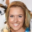

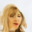

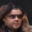

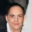

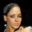

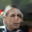

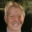

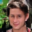

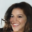

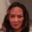

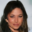

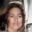

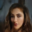

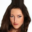

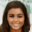

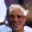

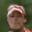

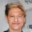

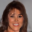

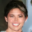

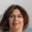

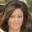

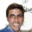

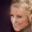

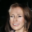

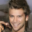

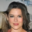

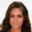

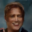

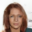

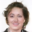

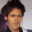

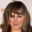

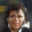

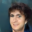

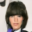

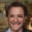

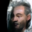

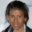

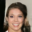

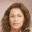

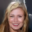

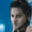

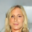

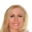

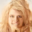

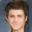

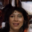

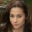

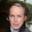

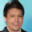

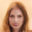

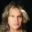

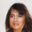

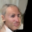

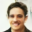

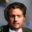

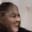

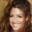

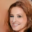

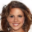

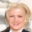

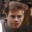

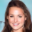

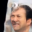

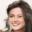

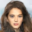

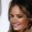

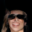

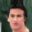

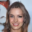

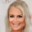

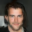

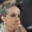

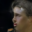

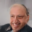

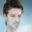

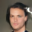

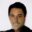

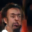

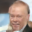

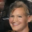

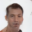

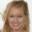

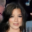

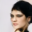

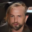

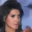

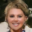

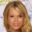

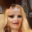

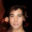

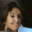

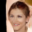

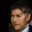

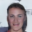

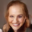

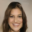

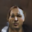

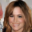

Inception Score: 2.133696402541158


In [13]:
# Actually train the model

ema_decay = 0.998

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.


def eval_loss(model, rng, reals):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    weights = log_snrs.exp() / log_snrs.exp().add(1)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    with torch.cuda.amp.autocast():
        v = model(noised_reals, log_snrs)
        return (v - targets).pow(2).mean([1, 2, 3]).mul(weights).mean()


def train():
    for i, reals in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)

def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, reals in enumerate(tqdm(val_dl)):
        reals = reals.to(device)

        loss = eval_loss(model_ema, rng, reals)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')

@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')

    torch.manual_seed(42)

    noise = torch.randn([100, 3, 32, 32], device=device)
    fakes = sample(model_ema, noise, steps, eta)
    state = evaluator.run([fakes.data])

    for i, fake in enumerate(fakes):
        img_normalized = (fake.add(1).div(2).clamp(0, 1)).cpu()  # Normalize
        filename = f'StableDiffusion_CelebA_Out/{epoch:03}_{i:03}.png'

        save_image(img_normalized, filename)

        display.display(display.Image(filename))

    tqdm.write(f'Inception Score: {state.metrics["is"]}')
    


def save():
    filename = 'celeba_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


try:
    val()
    while epoch <= 250:
        print('Epoch', epoch)
        train()
        epoch += 1
        if epoch % 5 == 0:
            val()
        save()
    demo()  
except KeyboardInterrupt:
    pass


In [14]:
from cleanfid import fid

fdir1 = "StableDiffusion_CelebA_Out"
fdir2 = "data/img_align_celeba"

score = fid.compute_fid(fdir1, fdir2, dataset_res=32)

print(score)

compute FID between two folders
Found 100 images in the folder StableDiffusion_CelebA_Out


FID StableDiffusion_CelebA_Out : 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Found 60000 images in the folder data/img_align_celeba


FID img_align_celeba : 100%|██████████| 1875/1875 [02:59<00:00, 10.43it/s]


169.7237714222573
